In [3]:
import numpy, pandas
import conntility
import os
import connalysis
import tqdm

from scipy.spatial import distance
from matplotlib import pyplot as plt


In [25]:
# Connectivity matrix to use
fn_mat = "/gpfs/bbp.cscs.ch/project/proj159/home/barros/conn_matrix/Human_960um_squared_funct_conmat_filtered_compressed.h5"
M = conntility.ConnectivityMatrix.from_h5(fn_mat)

## Patch sample and analysis helpers

Functions to patch sample and evaluate triads and connection probabilities

In [4]:
def partition_model_into_subvolumes(M, decomposition_plane, decomposition_sz, min_column_sz):
    grps = conntility.circuit_models.neuron_groups.group_by_grid(M.vertices, decomposition_plane, decomposition_sz)
    grps = grps.groupby("grid-subtarget")["node_ids"].apply(list)

    Ms = []
    for grp in grps:
        m = M.subpopulation(grp)
        if len(m) > min_column_sz:
            Ms.append(m)
    return Ms

In [5]:
col_slc = ["slice_x", "slice_y"]

def number_expected_er(P, N):
    from connalysis.network.topology import triad_combinations
    from scipy.stats import binom
    num_edge_per_triad = numpy.array([2, 2, 2, 3, 3, 3, 3, 4, 4 ,4 ,4, 5, 6])
    num_edge_per_non_triad = numpy.array([0, 1, 2])
    non_triad_combinations = numpy.array([1, 6, 3])

    p_er = triad_combinations * (P ** num_edge_per_triad) * ((1 - P) ** (6 - num_edge_per_triad))
    p_er_non = non_triad_combinations * (P ** num_edge_per_non_triad) * ((1 - P) ** (6 - num_edge_per_non_triad))
    assert numpy.abs(1 - (p_er.sum() + p_er_non.sum())) < 1E-6

    distr_er = binom(N, (p_er / p_er.sum()))
    return distr_er.mean(), distr_er.std()

def sample_and_count_triads(m, mv_cv, n_patch=12, n_samples=25, slice_thickness=150):
    counts = []
    sum_pairs = 0
    sum_connected = 0
    sum_rc = 0
    delta_rec = []
    delta_con = []
    delta_unc = []
    for _ in tqdm.tqdm(range(n_samples)):
        try:
            s = m.slice(numpy.random.rand() * numpy.pi, (numpy.random.rand() - 0.5) * 50, slice_thickness)
            s = s.patch_sample(n_patch, [0, 0], mv_cv, columns_xy=col_slc)
            sum_pairs += (len(s) * (len(s) - 1))
            sum_connected += s.matrix.nnz
            sum_rc += s.to_reciprocal().matrix.nnz
            counts.append(connalysis.network.topology.count_triads_fully_connected(s.matrix > 0, return_normalized=False))
            D = s.vertices[col_slc].values.reshape((1, -1, 2)) - s.vertices[col_slc].values.reshape((-1, 1, 2))
            delta_rec.append(pandas.DataFrame(
                D[(s.array > 0) & (s.array.transpose() > 0)], columns=["horizontal", "vertical"]
            ))
            delta_con.append(pandas.DataFrame(
                D[(s.array > 0) & (s.array.transpose() == 0)], columns=["horizontal", "vertical"]
            ))
            delta_unc.append(pandas.DataFrame(
                D[(s.array == 0)], columns=["horizontal", "vertical"]
            ))
        except:
            pass
    P = sum_connected / sum_pairs
    Prec = sum_rc / sum_pairs
    deltas = pandas.concat([
        pandas.concat(delta_rec, axis=0, names=["sample"], keys=range(len(delta_rec))),
        pandas.concat(delta_con, axis=0, names=["sample"], keys=range(len(delta_con))),
        pandas.concat(delta_unc, axis=0, names=["sample"], keys=range(len(delta_unc)))
    ], axis=0, keys=["reciprocal", "unidirectional", "unconnected"])
    counts = numpy.vstack(counts).sum(axis=0)
    return counts, (P, Prec), deltas


Main entry point

In [6]:
def execute_slice_and_patch_campaign(M, param_dict):
    if "decomposition_plane" in param_dict:
        Ms = partition_model_into_subvolumes(M, param_dict["decomposition_plane"],
                                             param_dict["decomposition_sz"], param_dict["min_column_sz"])
    else:
        Ms = [M]
    
    all_counts = []
    all_er = []
    all_deltas = []

    mv_cv = numpy.array(param_dict["mv_cv"])
    patch_kwargs = param_dict["patch_kwargs"]
    allP_u = []; allP_rc = []
    for m in Ms:
        counts, P, deltas = sample_and_count_triads(m, mv_cv, **patch_kwargs)
        allP_u.append(P[0]); allP_rc.append(P[1])
        count_er_mn, count_er_sd = number_expected_er(P[0], counts.sum())
        all_counts.append((counts - count_er_mn) / count_er_sd)
        all_deltas.append(deltas)

    all_counts = pandas.DataFrame(all_counts,
                     index=pandas.RangeIndex(len(all_counts), name="subvolume"),
                     columns=pandas.RangeIndex(13, name="motif"))
    all_deltas = pandas.concat(all_deltas, axis=0, names=["subvolume"], keys=range(len(all_deltas)))
    return all_counts, all_deltas, pandas.DataFrame({"unidirectional": allP_u,
                                                     "reciprocal": allP_rc})
    

## EXECUTE!

### Part I: Triad motifs for a realistic sampling
Note: If you are only interested in part II, you can skip execution of this part.

In [ ]:
campaign_cfg = {
    "decomposition_plane": ["x", "z"], # What are the horizontal axes of the volume?Decomposition will happen in this plane.
    "decomposition_sz": 250,
    "min_column_sz": 500, # After decomposition, columns smaller than this will be discarded,
    "mv_cv": [[145**2, 0], [0, 150**2]], # Describes the patch sampling spatial dimensions. 40 ** 2 will sample neuron pairs up to ~100 um.
    "patch_kwargs": {
        "slice_thickness": 200,
        "n_samples": 55, # The number of times the patch sampling procedure will be applied
        "n_patch": 12 # Up to this number of neurons will be sampled together
    }
}

all_counts, all_deltas, P = execute_slice_and_patch_campaign(M, campaign_cfg)

  4%|▎         | 2/55 [00:00<00:06,  8.60it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0039310455322265625
Found 146 connected triads
Time spent classifying triads: 0.009203433990478516
Testing 66 potential triadic pairs
Time spent finding triads: 0.001363515853881836
Found 152 connected triads
Time spent classifying triads: 0.0062563419342041016


  7%|▋         | 4/55 [00:00<00:05,  8.73it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001508474349975586
Found 197 connected triads
Time spent classifying triads: 0.011262178421020508
Testing 65 potential triadic pairs
Time spent finding triads: 0.0014414787292480469
Found 163 connected triads
Time spent classifying triads: 0.006545543670654297


 11%|█         | 6/55 [00:00<00:05,  9.00it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.001071929931640625
Found 40 connected triads
Time spent classifying triads: 0.003850698471069336
Testing 65 potential triadic pairs
Time spent finding triads: 0.0013453960418701172
Found 148 connected triads
Time spent classifying triads: 0.0059375762939453125


 15%|█▍        | 8/55 [00:00<00:05,  8.78it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014157295227050781
Found 170 connected triads
Time spent classifying triads: 0.015735387802124023
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013766288757324219
Found 184 connected triads
Time spent classifying triads: 0.007283687591552734


 18%|█▊        | 10/55 [00:01<00:04,  9.17it/s]

Testing 38 potential triadic pairs
Time spent finding triads: 0.0010859966278076172
Found 36 connected triads
Time spent classifying triads: 0.0034046173095703125
Testing 55 potential triadic pairs
Time spent finding triads: 0.0013468265533447266
Found 90 connected triads
Time spent classifying triads: 0.00360870361328125
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013630390167236328
Found 175 connected triads


 22%|██▏       | 12/55 [00:01<00:04,  9.13it/s]

Time spent classifying triads: 0.015317678451538086
Testing 61 potential triadic pairs
Time spent finding triads: 0.0011603832244873047
Found 89 connected triads
Time spent classifying triads: 0.0035924911499023438


 25%|██▌       | 14/55 [00:01<00:04,  9.37it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.001567840576171875
Found 40 connected triads
Time spent classifying triads: 0.0036678314208984375
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013272762298583984
Found 147 connected triads
Time spent classifying triads: 0.007956743240356445
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009355545043945312
Found 30 connected triads
Time spent classifying triads: 0.0012500286102294922


 31%|███       | 17/55 [00:01<00:04,  9.31it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014238357543945312
Found 179 connected triads
Time spent classifying triads: 0.01626420021057129
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013074874877929688
Found 142 connected triads
Time spent classifying triads: 0.005606651306152344


 35%|███▍      | 19/55 [00:02<00:03,  9.25it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.002227783203125
Found 91 connected triads
Time spent classifying triads: 0.008600950241088867
Testing 66 potential triadic pairs
Time spent finding triads: 0.0014274120330810547
Found 189 connected triads
Time spent classifying triads: 0.008028984069824219


 38%|███▊      | 21/55 [00:02<00:03,  9.36it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0020530223846435547
Found 120 connected triads
Time spent classifying triads: 0.007304191589355469
Testing 61 potential triadic pairs
Time spent finding triads: 0.0011680126190185547
Found 86 connected triads
Time spent classifying triads: 0.007128238677978516


 42%|████▏     | 23/55 [00:02<00:03,  9.44it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012536048889160156
Found 97 connected triads
Time spent classifying triads: 0.0047473907470703125
Testing 34 potential triadic pairs
Time spent finding triads: 0.001071929931640625
Found 44 connected triads
Time spent classifying triads: 0.004122257232666016


 44%|████▎     | 24/55 [00:02<00:03,  9.40it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0026793479919433594
Found 162 connected triads
Time spent classifying triads: 0.008574247360229492
Testing 22 potential triadic pairs
Time spent finding triads: 0.0010437965393066406
Found 26 connected triads
Time spent classifying triads: 0.001111745834350586


 49%|████▉     | 27/55 [00:02<00:02,  9.44it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0026366710662841797
Found 196 connected triads
Time spent classifying triads: 0.0102081298828125
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013422966003417969
Found 175 connected triads
Time spent classifying triads: 0.0069732666015625


 53%|█████▎    | 29/55 [00:03<00:02,  9.46it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013971328735351562
Found 149 connected triads
Time spent classifying triads: 0.007734060287475586
Testing 54 potential triadic pairs
Time spent finding triads: 0.0011701583862304688
Found 85 connected triads
Time spent classifying triads: 0.0034742355346679688


 56%|█████▋    | 31/55 [00:03<00:02,  9.54it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0020906925201416016
Found 121 connected triads
Time spent classifying triads: 0.00595855712890625
Testing 55 potential triadic pairs
Time spent finding triads: 0.0013120174407958984
Found 72 connected triads
Time spent classifying triads: 0.0029420852661132812


 60%|██████    | 33/55 [00:03<00:02,  9.32it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.001026153564453125
Found 41 connected triads
Time spent classifying triads: 0.003896951675415039
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013086795806884766
Found 140 connected triads
Time spent classifying triads: 0.005548000335693359


 62%|██████▏   | 34/55 [00:03<00:02,  9.08it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013926029205322266
Found 171 connected triads
Time spent classifying triads: 0.015851974487304688
Testing 61 potential triadic pairs
Time spent finding triads: 0.0012030601501464844
Found 84 connected triads
Time spent classifying triads: 0.003421306610107422
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013992786407470703
Found 173 connected triads


#### Plot triads


In [ ]:
fig = plt.figure(figsize=(5, 3))
ax = fig.gca()

ax.bar(all_counts.columns, all_counts.mean())
x = numpy.repeat(all_counts.columns.values.reshape((1, -1)), len(all_counts), axis=0)
x = x + 0.25 * (numpy.random.rand(*x.shape) - 0.5)
ax.plot(x, all_counts.values, color="black", ls="None", marker='s', ms=2)
ax.plot([0, 13], [0, 0], color="grey", lw=0.5)
ax.set_frame_on(False)
ax.set_xlabel("Triad #")
ax.set_ylabel("Z-score")

In [ ]:
i = 0
d = all_deltas.loc[i]
d["distance"] = numpy.linalg.norm(d, axis=1)
dists = d.reset_index().groupby("level_0")["distance"].mean()

fig = plt.figure(figsize=(5, 3))
ax = fig.add_axes([0.1, 0.1, 0.5, 0.85])

def sample_random_fraction(arr_in, frac):
    assert frac <= 1
    b = numpy.random.choice(len(arr_in), int(len(arr_in) * frac), replace=False)
    return arr_in.iloc[b]["horizontal"], arr_in.iloc[b]["vertical"]

cols_use = [[0.6, 0.6, 1.0], [0.1, 0.1, 0.7], [0.9, 0.3, 0.0]]

ax.scatter(*sample_random_fraction(d.loc["unconnected"], 0.5), color=cols_use[0], s=3, alpha=0.3, label="Unconnected")
ax.scatter(*sample_random_fraction(d.loc["unidirectional"], 0.5), color=cols_use[1], s=3, alpha=0.6, label="Unidirectional")
ax.scatter(*sample_random_fraction(d.loc["reciprocal"], 0.5), color=cols_use[2], s=3, alpha=0.8, label="Reciprocal")
ax.plot(0, 0, marker="^", ms=8, color="black")
ax.set_xlabel("Horizontal offset (um)")
ax.set_ylabel("Vertical offset (um)")
ax.set_frame_on(False)
# plt.axis("equal")
ax.set_xlim([-300, 300]); ax.set_xticks([-300, -150, 0, 150, 300]); ax.set_xticklabels([300, 150, 0, 150, 300])
ax.set_ylim([-300, 300]); ax.set_yticks([-300, -150, 0, 150, 300]); ax.set_yticklabels([300, 150, 0, 150, 300])
plt.legend()

ax = fig.add_axes([0.725, 0.35, 0.275, 0.35])
ax.bar(2, dists["reciprocal"], color=cols_use[2])
ax.bar(1, dists["unidirectional"], color=cols_use[1])
ax.bar(0, dists["unconnected"], color=cols_use[0])
ax.set_xticks([0, 1, 2]); ax.set_xticklabels(["Unconnected", "Unidirectional", "Reciprocal"], rotation="vertical")
ax.set_ylabel("Mean distance (um)")
ax.set_frame_on(False)

The purpose of the plot above is to show our sampling, and that it resembles in vitro sampling.
To be compared to Peng et al., Figure 2A

Also, we see that at this scale there is a bit of distance-dependence, but not much: Unconnected, unidirectionally connected and reciprocally connected pairs are at slightly different distances.

## Part II: How the scale over which we sample affects things
This part includes a look at reciprocal connectivity: Is it over- or under-expressed?

#### Validate connection probabilites
To be compared to Peng et al., Figure 1B

First panel showing that we closely match Peng et al. connection probabilities. But only with "s2f" pruning.


In [20]:
fns = {
    "s2f": "/gpfs/bbp.cscs.ch/project/proj159/home/barros/conn_matrix/Human_NEWfunct_conmat_filtered_compressed.h5",
    "E to T": "/gpfs/bbp.cscs.ch/project/proj159/home/barros/conn_matrix/Human_pruned_edges_to_touches.h5",
    "T to T": "/gpfs/bbp.cscs.ch/project/proj159/home/barros/conn_matrix/Human_pruned_touches_to_touches.h5",
    "E to E": "/gpfs/bbp.cscs.ch/project/proj159/home/barros/conn_matrix/Human_prunedEdges_conmat.h5",
    "T to E": "/gpfs/bbp.cscs.ch/project/proj159/home/barros/conn_matrix/Human_prunedTouches_conmat.h5"
}

Ms = dict([(k, conntility.ConnectivityMatrix.from_h5(v))
           for k, v in fns.items()])

For context: Sampling at scales that resemble Peng et al (see above).

In [21]:
def patch_result_to_con_probs(deltas):
    deltas = deltas[(deltas != 0).any(axis=1)]

    tst = deltas.reset_index().groupby("subvolume")["level_1"].value_counts().unstack("level_1")
    tst["connected"] = tst["reciprocal"] + tst["unidirectional"]
    tst["reciprocal_pairs"] = tst["reciprocal"] / 2 # Because the original analysis counts rc pairs twice, once for each direction
    tst["sorted_pairs"] = tst["connected"] + tst["unconnected"]
    tst["pairs"] = tst["sorted_pairs"] / 2

    count_srt = int(tst["sorted_pairs"][0]) # All samplings have the same number. Just using the first.
    count_unsrt = int(tst["pairs"][0])
    
    return tst, count_srt, count_unsrt

campaign_cfg = {
    "decomposition_plane": ["x", "z"], # What are the horizontal axes of the volume?Decomposition will happen in this plane.
    "decomposition_sz": 250,
    "min_column_sz": 500, # After decomposition, columns smaller than this will be discarded,
    "mv_cv": [[145**2, 0], [0, 150**2]], # Describes the patch sampling spatial dimensions. 40 ** 2 will sample neuron pairs up to ~100 um.
    "patch_kwargs": {
        "slice_thickness": 200,
        "n_samples": 55, # The number of times the patch sampling procedure will be applied
        "n_patch": 12 # Up to this number of neurons will be sampled together
    }
}

df_Ps = []; counts_srt = []; counts_unsrt = []
for k, M in Ms.items():
    counts, deltas, P = execute_slice_and_patch_campaign(M, campaign_cfg)
    df_P, c_srt, c_un = patch_result_to_con_probs(deltas)
    df_Ps.append((k, df_P)); counts_srt.append((k, c_srt)); counts_unsrt.append((k, c_un))
df_Ps = dict(df_Ps); counts_srt = dict(counts_srt); counts_unsrt = dict(counts_unsrt)

  7%|▋         | 4/55 [00:00<00:03, 15.90it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0009121894836425781
Found 20 connected triads
Time spent classifying triads: 0.0019435882568359375
Testing 28 potential triadic pairs
Time spent finding triads: 0.0009007453918457031
Found 27 connected triads
Time spent classifying triads: 0.0011031627655029297
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008757114410400391
Found 39 connected triads
Time spent classifying triads: 0.0015549659729003906
Testing 48 potential triadic pairs
Time spent finding triads: 0.001016855239868164
Found 56 connected triads
Time spent classifying triads: 0.002210855484008789


 15%|█▍        | 8/55 [00:00<00:02, 16.06it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.001065969467163086
Found 57 connected triads
Time spent classifying triads: 0.0052967071533203125
Testing 45 potential triadic pairs
Time spent finding triads: 0.0009920597076416016
Found 49 connected triads
Time spent classifying triads: 0.0019321441650390625
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007317066192626953
Found 2 connected triads
Time spent classifying triads: 0.00018024444580078125
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007762908935546875
Found 9 connected triads
Time spent classifying triads: 0.00044798851013183594


 22%|██▏       | 12/55 [00:00<00:02, 15.94it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.00098419189453125
Found 39 connected triads
Time spent classifying triads: 0.0036411285400390625
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011527538299560547
Found 109 connected triads
Time spent classifying triads: 0.004158735275268555
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008726119995117188
Found 20 connected triads
Time spent classifying triads: 0.0008571147918701172
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008523464202880859
Found 31 connected triads
Time spent classifying triads: 0.0012552738189697266


 29%|██▉       | 16/55 [00:01<00:02, 15.77it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.0010495185852050781
Found 44 connected triads
Time spent classifying triads: 0.004107236862182617
Testing 57 potential triadic pairs
Time spent finding triads: 0.0011031627655029297
Found 90 connected triads
Time spent classifying triads: 0.0034728050231933594
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008351802825927734
Found 18 connected triads
Time spent classifying triads: 0.0007798671722412109
Testing 55 potential triadic pairs
Time spent finding triads: 0.001094818115234375
Found 81 connected triads
Time spent classifying triads: 0.003111124038696289


 36%|███▋      | 20/55 [00:01<00:02, 15.89it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009393692016601562
Found 25 connected triads
Time spent classifying triads: 0.002396106719970703
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009489059448242188
Found 40 connected triads
Time spent classifying triads: 0.0016050338745117188
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008549690246582031
Found 20 connected triads
Time spent classifying triads: 0.0008537769317626953
Testing 29 potential triadic pairs
Time spent finding triads: 0.0008966922760009766
Found 39 connected triads
Time spent classifying triads: 0.0015330314636230469


 44%|████▎     | 24/55 [00:01<00:01, 15.79it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0008783340454101562
Found 22 connected triads
Time spent classifying triads: 0.002099752426147461
Testing 59 potential triadic pairs
Time spent finding triads: 0.001077413558959961
Found 66 connected triads
Time spent classifying triads: 0.002566099166870117
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007810592651367188
Found 10 connected triads
Time spent classifying triads: 0.00047206878662109375
Testing 62 potential triadic pairs
Time spent finding triads: 0.001155853271484375
Found 108 connected triads
Time spent classifying triads: 0.0041348934173583984


 51%|█████     | 28/55 [00:01<00:01, 15.64it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0011715888977050781
Found 85 connected triads
Time spent classifying triads: 0.00783085823059082
Testing 61 potential triadic pairs
Time spent finding triads: 0.001138925552368164
Found 95 connected triads
Time spent classifying triads: 0.0036399364471435547
Testing 57 potential triadic pairs
Time spent finding triads: 0.001093149185180664
Found 82 connected triads
Time spent classifying triads: 0.0031566619873046875
Testing 29 potential triadic pairs
Time spent finding triads: 0.0008969306945800781
Found 28 connected triads
Time spent classifying triads: 0.0011487007141113281


 58%|█████▊    | 32/55 [00:02<00:01, 15.94it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.0010805130004882812
Found 51 connected triads
Time spent classifying triads: 0.002538919448852539
Testing 10 potential triadic pairs
Time spent finding triads: 0.000774383544921875
Found 10 connected triads
Time spent classifying triads: 0.0004684925079345703
Testing 27 potential triadic pairs
Time spent finding triads: 0.0008823871612548828
Found 30 connected triads
Time spent classifying triads: 0.0012073516845703125
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008230209350585938
Found 15 connected triads
Time spent classifying triads: 0.0006537437438964844


 65%|██████▌   | 36/55 [00:02<00:01, 15.85it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.001001119613647461
Found 42 connected triads
Time spent classifying triads: 0.0038988590240478516
Testing 39 potential triadic pairs
Time spent finding triads: 0.0009517669677734375
Found 37 connected triads
Time spent classifying triads: 0.0014908313751220703
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011453628540039062
Found 91 connected triads
Time spent classifying triads: 0.0034749507904052734
Testing 23 potential triadic pairs
Time spent finding triads: 0.000865936279296875
Found 21 connected triads
Time spent classifying triads: 0.0008952617645263672


 73%|███████▎  | 40/55 [00:02<00:00, 15.78it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.0010952949523925781
Found 67 connected triads
Time spent classifying triads: 0.006207704544067383
Testing 43 potential triadic pairs
Time spent finding triads: 0.0009751319885253906
Found 48 connected triads
Time spent classifying triads: 0.001901865005493164
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011436939239501953
Found 106 connected triads
Time spent classifying triads: 0.0040073394775390625
Testing 58 potential triadic pairs
Time spent finding triads: 0.0010972023010253906
Found 81 connected triads
Time spent classifying triads: 0.003108501434326172


 80%|████████  | 44/55 [00:02<00:00, 15.67it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0010974407196044922
Found 72 connected triads
Time spent classifying triads: 0.006666898727416992
Testing 53 potential triadic pairs
Time spent finding triads: 0.0010726451873779297
Found 67 connected triads
Time spent classifying triads: 0.0025970935821533203
Testing 46 potential triadic pairs
Time spent finding triads: 0.0010089874267578125
Found 60 connected triads
Time spent classifying triads: 0.0023376941680908203
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008816719055175781
Found 23 connected triads
Time spent classifying triads: 0.0009706020355224609


 87%|████████▋ | 48/55 [00:03<00:00, 15.65it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0008914470672607422
Found 19 connected triads
Time spent classifying triads: 0.001828908920288086
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011036396026611328
Found 85 connected triads
Time spent classifying triads: 0.0032384395599365234
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009186267852783203
Found 34 connected triads
Time spent classifying triads: 0.0013837814331054688
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009419918060302734
Found 38 connected triads
Time spent classifying triads: 0.0015153884887695312


 95%|█████████▍| 52/55 [00:03<00:00, 15.62it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0009920597076416016
Found 38 connected triads
Time spent classifying triads: 0.0035796165466308594
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009586811065673828
Found 36 connected triads
Time spent classifying triads: 0.0014722347259521484
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009484291076660156
Found 44 connected triads
Time spent classifying triads: 0.0017621517181396484
Testing 42 potential triadic pairs
Time spent finding triads: 0.0009605884552001953
Found 48 connected triads
Time spent classifying triads: 0.0018765926361083984


100%|██████████| 55/55 [00:03<00:00, 15.71it/s]


Testing 53 potential triadic pairs
Time spent finding triads: 0.0010857582092285156
Found 55 connected triads
Time spent classifying triads: 0.005092144012451172
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008358955383300781
Found 20 connected triads
Time spent classifying triads: 0.0008482933044433594
Testing 45 potential triadic pairs
Time spent finding triads: 0.0010173320770263672
Found 59 connected triads
Time spent classifying triads: 0.0023069381713867188


  4%|▎         | 2/55 [00:00<00:03, 15.07it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0009469985961914062
Found 31 connected triads
Time spent classifying triads: 0.0029268264770507812
Testing 53 potential triadic pairs
Time spent finding triads: 0.0010683536529541016
Found 70 connected triads
Time spent classifying triads: 0.0026967525482177734
Testing 55 potential triadic pairs
Time spent finding triads: 0.0011165142059326172
Found 88 connected triads
Time spent classifying triads: 0.003369569778442383
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010466575622558594
Found 68 connected triads
Time spent classifying triads: 0.002627134323120117


 11%|█         | 6/55 [00:00<00:03, 14.98it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.001028299331665039
Found 35 connected triads
Time spent classifying triads: 0.003305196762084961
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008466243743896484
Found 18 connected triads
Time spent classifying triads: 0.0007870197296142578
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009489059448242188
Found 48 connected triads
Time spent classifying triads: 0.0018858909606933594
Testing 56 potential triadic pairs
Time spent finding triads: 0.0011281967163085938
Found 89 connected triads
Time spent classifying triads: 0.003429889678955078


 22%|██▏       | 12/55 [00:00<00:02, 15.13it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0011150836944580078
Found 79 connected triads
Time spent classifying triads: 0.0072689056396484375
Testing 12 potential triadic pairs
Time spent finding triads: 0.0007975101470947266
Found 12 connected triads
Time spent classifying triads: 0.0005521774291992188
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010271072387695312
Found 60 connected triads
Time spent classifying triads: 0.0023343563079833984
Testing 39 potential triadic pairs
Time spent finding triads: 0.0009543895721435547
Found 40 connected triads
Time spent classifying triads: 0.0015854835510253906


 29%|██▉       | 16/55 [00:01<00:02, 15.31it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0011811256408691406
Found 90 connected triads
Time spent classifying triads: 0.008296489715576172
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008740425109863281
Found 21 connected triads
Time spent classifying triads: 0.0008862018585205078
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008375644683837891
Found 24 connected triads
Time spent classifying triads: 0.001003265380859375
Testing 51 potential triadic pairs
Time spent finding triads: 0.001028299331665039
Found 60 connected triads
Time spent classifying triads: 0.0023424625396728516


 36%|███▋      | 20/55 [00:01<00:02, 15.36it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.000843048095703125
Found 11 connected triads
Time spent classifying triads: 0.0011115074157714844
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011372566223144531
Found 95 connected triads
Time spent classifying triads: 0.0036106109619140625
Testing 46 potential triadic pairs
Time spent finding triads: 0.0010030269622802734
Found 55 connected triads
Time spent classifying triads: 0.00213623046875
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009644031524658203
Found 52 connected triads
Time spent classifying triads: 0.0020422935485839844


 40%|████      | 22/55 [00:01<00:02, 15.03it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0011000633239746094
Found 57 connected triads
Time spent classifying triads: 0.005297660827636719
Testing 65 potential triadic pairs
Time spent finding triads: 0.0011658668518066406
Found 113 connected triads
Time spent classifying triads: 0.0042726993560791016
Testing 55 potential triadic pairs
Time spent finding triads: 0.0011005401611328125
Found 68 connected triads
Time spent classifying triads: 0.0062983036041259766
Testing 50 potential triadic pairs
Time spent finding triads: 0.0011043548583984375
Found 58 connected triads
Time spent classifying triads: 0.005397319793701172


 51%|█████     | 28/55 [00:01<00:01, 15.08it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008213520050048828
Found 7 connected triads
Time spent classifying triads: 0.0007448196411132812
Testing 53 potential triadic pairs
Time spent finding triads: 0.0010645389556884766
Found 67 connected triads
Time spent classifying triads: 0.0026133060455322266
Testing 55 potential triadic pairs
Time spent finding triads: 0.0010929107666015625
Found 83 connected triads
Time spent classifying triads: 0.0031638145446777344
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010654926300048828
Found 84 connected triads
Time spent classifying triads: 0.0032227039337158203


 58%|█████▊    | 32/55 [00:02<00:01, 15.10it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0011856555938720703
Found 96 connected triads
Time spent classifying triads: 0.00884103775024414
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008690357208251953
Found 26 connected triads
Time spent classifying triads: 0.0010750293731689453
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009453296661376953
Found 38 connected triads
Time spent classifying triads: 0.0015180110931396484
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010378360748291016
Found 66 connected triads
Time spent classifying triads: 0.0025789737701416016


 65%|██████▌   | 36/55 [00:02<00:01, 15.26it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.0010707378387451172
Found 53 connected triads
Time spent classifying triads: 0.004935264587402344
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007770061492919922
Found 8 connected triads
Time spent classifying triads: 0.00041103363037109375
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010025501251220703
Found 57 connected triads
Time spent classifying triads: 0.002213716506958008
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007774829864501953
Found 7 connected triads
Time spent classifying triads: 0.00036215782165527344


 69%|██████▉   | 38/55 [00:02<00:01, 14.72it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.001256704330444336
Found 144 connected triads
Time spent classifying triads: 0.013223409652709961
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010352134704589844
Found 68 connected triads
Time spent classifying triads: 0.0026035308837890625
Testing 47 potential triadic pairs
Time spent finding triads: 0.0010387897491455078
Found 71 connected triads
Time spent classifying triads: 0.0027551651000976562
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011985301971435547
Found 122 connected triads
Time spent classifying triads: 0.004909038543701172


 80%|████████  | 44/55 [00:02<00:00, 15.33it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007681846618652344
Found 0 connected triads
Time spent classifying triads: 7.510185241699219e-05
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008633136749267578
Found 19 connected triads
Time spent classifying triads: 0.0008180141448974609
Testing 30 potential triadic pairs
Time spent finding triads: 0.0009047985076904297
Found 41 connected triads
Time spent classifying triads: 0.0016293525695800781
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009522438049316406
Found 43 connected triads
Time spent classifying triads: 0.0017173290252685547


 87%|████████▋ | 48/55 [00:03<00:00, 15.42it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008342266082763672
Found 11 connected triads
Time spent classifying triads: 0.001125335693359375
Testing 57 potential triadic pairs
Time spent finding triads: 0.0011050701141357422
Found 87 connected triads
Time spent classifying triads: 0.0033397674560546875
Testing 27 potential triadic pairs
Time spent finding triads: 0.0008981227874755859
Found 27 connected triads
Time spent classifying triads: 0.0011131763458251953
Testing 42 potential triadic pairs
Time spent finding triads: 0.0009837150573730469
Found 48 connected triads
Time spent classifying triads: 0.0018773078918457031


 95%|█████████▍| 52/55 [00:03<00:00, 15.46it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0010995864868164062
Found 67 connected triads
Time spent classifying triads: 0.003120899200439453
Testing 55 potential triadic pairs
Time spent finding triads: 0.001135110855102539
Found 109 connected triads
Time spent classifying triads: 0.004151821136474609
Testing 16 potential triadic pairs
Time spent finding triads: 0.0008144378662109375
Found 14 connected triads
Time spent classifying triads: 0.0006244182586669922
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008401870727539062
Found 23 connected triads
Time spent classifying triads: 0.0009710788726806641


100%|██████████| 55/55 [00:03<00:00, 15.13it/s]


Testing 18 potential triadic pairs
Time spent finding triads: 0.0008959770202636719
Found 16 connected triads
Time spent classifying triads: 0.0015926361083984375
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011053085327148438
Found 80 connected triads
Time spent classifying triads: 0.003079652786254883
Testing 39 potential triadic pairs
Time spent finding triads: 0.0009791851043701172
Found 60 connected triads
Time spent classifying triads: 0.0023272037506103516


  7%|▋         | 4/55 [00:00<00:03, 16.79it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.0011374950408935547
Found 88 connected triads
Time spent classifying triads: 0.006365776062011719
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008480548858642578
Found 20 connected triads
Time spent classifying triads: 0.0008459091186523438
Testing 28 potential triadic pairs
Time spent finding triads: 0.0010416507720947266
Found 33 connected triads
Time spent classifying triads: 0.0013484954833984375
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008282661437988281
Found 20 connected triads
Time spent classifying triads: 0.0008559226989746094


 15%|█▍        | 8/55 [00:00<00:02, 16.62it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.0009922981262207031
Found 42 connected triads
Time spent classifying triads: 0.003924846649169922
Testing 28 potential triadic pairs
Time spent finding triads: 0.0008935928344726562
Found 28 connected triads
Time spent classifying triads: 0.0011532306671142578
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010480880737304688
Found 59 connected triads
Time spent classifying triads: 0.0022916793823242188
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009093284606933594
Found 37 connected triads
Time spent classifying triads: 0.0014891624450683594


 22%|██▏       | 12/55 [00:00<00:02, 17.05it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.0010905265808105469
Found 56 connected triads
Time spent classifying triads: 0.0030279159545898438
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009434223175048828
Found 38 connected triads
Time spent classifying triads: 0.0015187263488769531
Testing 0 potential triadic pairs
Time spent finding triads: 0.0007040500640869141
Found 0 connected triads
Time spent classifying triads: 6.771087646484375e-05
Testing 54 potential triadic pairs
Time spent finding triads: 0.0010755062103271484
Found 81 connected triads
Time spent classifying triads: 0.003114938735961914


 29%|██▉       | 16/55 [00:00<00:02, 16.69it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0010714530944824219
Found 58 connected triads
Time spent classifying triads: 0.0039937496185302734
Testing 66 potential triadic pairs
Time spent finding triads: 0.0011913776397705078
Found 133 connected triads
Time spent classifying triads: 0.00502777099609375
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007345676422119141
Found 4 connected triads
Time spent classifying triads: 0.0002486705780029297
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011620521545410156
Found 118 connected triads
Time spent classifying triads: 0.004467487335205078


 36%|███▋      | 20/55 [00:01<00:02, 16.80it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008065700531005859
Found 7 connected triads
Time spent classifying triads: 0.0007560253143310547
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007681846618652344
Found 8 connected triads
Time spent classifying triads: 0.00040268898010253906
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009243488311767578
Found 33 connected triads
Time spent classifying triads: 0.0013384819030761719
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007817745208740234
Found 13 connected triads
Time spent classifying triads: 0.0005831718444824219


 44%|████▎     | 24/55 [00:01<00:01, 16.80it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012199878692626953
Found 113 connected triads
Time spent classifying triads: 0.010378599166870117
Testing 40 potential triadic pairs
Time spent finding triads: 0.0009493827819824219
Found 38 connected triads
Time spent classifying triads: 0.0015201568603515625
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010387897491455078
Found 65 connected triads
Time spent classifying triads: 0.0025272369384765625
Testing 43 potential triadic pairs
Time spent finding triads: 0.0009894371032714844
Found 51 connected triads
Time spent classifying triads: 0.0020134449005126953


 51%|█████     | 28/55 [00:01<00:01, 16.73it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.0010766983032226562
Found 71 connected triads
Time spent classifying triads: 0.00655055046081543
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009250640869140625
Found 30 connected triads
Time spent classifying triads: 0.0012369155883789062
Testing 44 potential triadic pairs
Time spent finding triads: 0.0009894371032714844
Found 54 connected triads
Time spent classifying triads: 0.0021085739135742188
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012001991271972656
Found 119 connected triads
Time spent classifying triads: 0.004525899887084961


 58%|█████▊    | 32/55 [00:01<00:01, 17.30it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0011899471282958984
Found 98 connected triads
Time spent classifying triads: 0.0053920745849609375
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011096000671386719
Found 95 connected triads
Time spent classifying triads: 0.003606557846069336
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009410381317138672
Found 44 connected triads
Time spent classifying triads: 0.0017375946044921875
Testing 38 potential triadic pairs
Time spent finding triads: 0.00093841552734375
Found 42 connected triads
Time spent classifying triads: 0.0016734600067138672


 65%|██████▌   | 36/55 [00:02<00:01, 16.93it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0011708736419677734
Found 98 connected triads
Time spent classifying triads: 0.009021759033203125
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011310577392578125
Found 96 connected triads
Time spent classifying triads: 0.0036573410034179688
Testing 55 potential triadic pairs
Time spent finding triads: 0.0010542869567871094
Found 65 connected triads
Time spent classifying triads: 0.0024940967559814453
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008094310760498047
Found 18 connected triads
Time spent classifying triads: 0.0007727146148681641


 73%|███████▎  | 40/55 [00:02<00:00, 16.56it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0011157989501953125
Found 71 connected triads
Time spent classifying triads: 0.006563425064086914
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008254051208496094
Found 24 connected triads
Time spent classifying triads: 0.0009932518005371094
Testing 61 potential triadic pairs
Time spent finding triads: 0.0011434555053710938
Found 96 connected triads
Time spent classifying triads: 0.003692626953125
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011072158813476562
Found 80 connected triads
Time spent classifying triads: 0.003080129623413086


 80%|████████  | 44/55 [00:02<00:00, 16.65it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0011854171752929688
Found 97 connected triads
Time spent classifying triads: 0.008972883224487305
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007789134979248047
Found 8 connected triads
Time spent classifying triads: 0.00040435791015625
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008449554443359375
Found 20 connected triads
Time spent classifying triads: 0.0008561611175537109
Testing 61 potential triadic pairs
Time spent finding triads: 0.0010867118835449219
Found 73 connected triads
Time spent classifying triads: 0.0028252601623535156


 87%|████████▋ | 48/55 [00:02<00:00, 16.85it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0009548664093017578
Found 36 connected triads
Time spent classifying triads: 0.003382444381713867
Testing 58 potential triadic pairs
Time spent finding triads: 0.0010688304901123047
Found 75 connected triads
Time spent classifying triads: 0.002855539321899414
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008170604705810547
Found 16 connected triads
Time spent classifying triads: 0.00070953369140625
Testing 1 potential triadic pairs
Time spent finding triads: 0.0007216930389404297
Found 1 connected triads
Time spent classifying triads: 0.0001266002655029297


 95%|█████████▍| 52/55 [00:03<00:00, 16.42it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.0010869503021240234
Found 66 connected triads
Time spent classifying triads: 0.006131887435913086
Testing 56 potential triadic pairs
Time spent finding triads: 0.0011069774627685547
Found 85 connected triads
Time spent classifying triads: 0.0032875537872314453
Testing 30 potential triadic pairs
Time spent finding triads: 0.0009050369262695312
Found 30 connected triads
Time spent classifying triads: 0.0012273788452148438
Testing 38 potential triadic pairs
Time spent finding triads: 0.000946044921875
Found 36 connected triads
Time spent classifying triads: 0.001461029052734375


100%|██████████| 55/55 [00:03<00:00, 16.72it/s]


Testing 33 potential triadic pairs
Time spent finding triads: 0.0009696483612060547
Found 33 connected triads
Time spent classifying triads: 0.003121614456176758
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010254383087158203
Found 61 connected triads
Time spent classifying triads: 0.0023784637451171875
Testing 40 potential triadic pairs
Time spent finding triads: 0.0009496212005615234
Found 41 connected triads
Time spent classifying triads: 0.0016312599182128906


  4%|▎         | 2/55 [00:00<00:03, 14.16it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008327960968017578
Found 13 connected triads
Time spent classifying triads: 0.0012955665588378906
Testing 50 potential triadic pairs
Time spent finding triads: 0.0010561943054199219
Found 61 connected triads
Time spent classifying triads: 0.00240325927734375
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008523464202880859
Found 21 connected triads
Time spent classifying triads: 0.0008914470672607422


 11%|█         | 6/55 [00:00<00:03, 13.96it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0013523101806640625
Found 107 connected triads
Time spent classifying triads: 0.009879112243652344
Testing 41 potential triadic pairs
Time spent finding triads: 0.0009891986846923828
Found 42 connected triads
Time spent classifying triads: 0.0016589164733886719
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009608268737792969
Found 40 connected triads
Time spent classifying triads: 0.0015883445739746094


 15%|█▍        | 8/55 [00:00<00:03, 14.15it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0010788440704345703
Found 20 connected triads
Time spent classifying triads: 0.0019292831420898438
Testing 13 potential triadic pairs
Time spent finding triads: 0.0008020401000976562
Found 11 connected triads
Time spent classifying triads: 0.0005166530609130859
Testing 7 potential triadic pairs
Time spent finding triads: 0.0009200572967529297
Found 7 connected triads
Time spent classifying triads: 0.00036406517028808594
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008766651153564453
Found 24 connected triads
Time spent classifying triads: 0.000997781753540039


 22%|██▏       | 12/55 [00:00<00:03, 14.20it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0008943080902099609
Found 16 connected triads
Time spent classifying triads: 0.0015599727630615234
Testing 60 potential triadic pairs
Time spent finding triads: 0.001155853271484375
Found 92 connected triads
Time spent classifying triads: 0.003509521484375
Testing 48 potential triadic pairs
Time spent finding triads: 0.001018524169921875
Found 55 connected triads
Time spent classifying triads: 0.0021734237670898438


 29%|██▉       | 16/55 [00:01<00:02, 14.08it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.001088857650756836
Found 56 connected triads
Time spent classifying triads: 0.0051937103271484375
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011615753173828125
Found 111 connected triads
Time spent classifying triads: 0.004218578338623047
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009517669677734375
Found 44 connected triads
Time spent classifying triads: 0.00173187255859375


 33%|███▎      | 18/55 [00:01<00:02, 14.00it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0011487007141113281
Found 77 connected triads
Time spent classifying triads: 0.007091522216796875
Testing 13 potential triadic pairs
Time spent finding triads: 0.0007991790771484375
Found 11 connected triads
Time spent classifying triads: 0.0005221366882324219
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010590553283691406
Found 58 connected triads
Time spent classifying triads: 0.002269268035888672


 40%|████      | 22/55 [00:01<00:02, 14.14it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0013434886932373047
Found 23 connected triads
Time spent classifying triads: 0.002201080322265625
Testing 34 potential triadic pairs
Time spent finding triads: 0.0010640621185302734
Found 35 connected triads
Time spent classifying triads: 0.0014052391052246094
Testing 33 potential triadic pairs
Time spent finding triads: 0.0009245872497558594
Found 41 connected triads
Time spent classifying triads: 0.0016300678253173828


 44%|████▎     | 24/55 [00:01<00:02, 14.01it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.0011248588562011719
Found 68 connected triads
Time spent classifying triads: 0.006273746490478516
Testing 39 potential triadic pairs
Time spent finding triads: 0.0009598731994628906
Found 37 connected triads
Time spent classifying triads: 0.0015039443969726562
Testing 29 potential triadic pairs
Time spent finding triads: 0.0008885860443115234
Found 27 connected triads
Time spent classifying triads: 0.0011169910430908203
Testing 28 potential triadic pairs
Time spent finding triads: 0.0009551048278808594
Found 31 connected triads
Time spent classifying triads: 0.0029230117797851562


 51%|█████     | 28/55 [00:01<00:01, 13.93it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.0011453628540039062
Found 69 connected triads
Time spent classifying triads: 0.006375789642333984
Testing 40 potential triadic pairs
Time spent finding triads: 0.000989675521850586
Found 53 connected triads
Time spent classifying triads: 0.0020630359649658203
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008594989776611328
Found 21 connected triads
Time spent classifying triads: 0.0008931159973144531


 58%|█████▊    | 32/55 [00:02<00:01, 14.14it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0014946460723876953
Found 13 connected triads
Time spent classifying triads: 0.001293182373046875
Testing 33 potential triadic pairs
Time spent finding triads: 0.0009424686431884766
Found 35 connected triads
Time spent classifying triads: 0.0014102458953857422
Testing 49 potential triadic pairs
Time spent finding triads: 0.001035451889038086
Found 66 connected triads
Time spent classifying triads: 0.0025501251220703125


 62%|██████▏   | 34/55 [00:02<00:01, 14.09it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.0015518665313720703
Found 47 connected triads
Time spent classifying triads: 0.004134416580200195
Testing 28 potential triadic pairs
Time spent finding triads: 0.0008857250213623047
Found 28 connected triads
Time spent classifying triads: 0.0011472702026367188
Testing 46 potential triadic pairs
Time spent finding triads: 0.0010304450988769531
Found 70 connected triads
Time spent classifying triads: 0.0026950836181640625


 69%|██████▉   | 38/55 [00:02<00:01, 14.01it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0016934871673583984
Found 130 connected triads
Time spent classifying triads: 0.011861324310302734
Testing 37 potential triadic pairs
Time spent finding triads: 0.00093841552734375
Found 40 connected triads
Time spent classifying triads: 0.0015912055969238281
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007569789886474609
Found 5 connected triads
Time spent classifying triads: 0.00029587745666503906


 73%|███████▎  | 40/55 [00:02<00:01, 14.08it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0017726421356201172
Found 19 connected triads
Time spent classifying triads: 0.0015406608581542969
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008609294891357422
Found 20 connected triads
Time spent classifying triads: 0.0008616447448730469
Testing 47 potential triadic pairs
Time spent finding triads: 0.0010097026824951172
Found 54 connected triads
Time spent classifying triads: 0.0021288394927978516
Testing 9 potential triadic pairs
Time spent finding triads: 0.0014286041259765625
Found 7 connected triads
Time spent classifying triads: 0.0007619857788085938


 80%|████████  | 44/55 [00:03<00:00, 13.41it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0010349750518798828
Found 47 connected triads
Time spent classifying triads: 0.004369497299194336
Testing 46 potential triadic pairs
Time spent finding triads: 0.0016045570373535156
Found 67 connected triads
Time spent classifying triads: 0.003233194351196289
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009183883666992188
Found 31 connected triads
Time spent classifying triads: 0.0012600421905517578


 87%|████████▋ | 48/55 [00:03<00:00, 13.97it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0012149810791015625
Found 18 connected triads
Time spent classifying triads: 0.0014438629150390625
Testing 27 potential triadic pairs
Time spent finding triads: 0.0008931159973144531
Found 28 connected triads
Time spent classifying triads: 0.0011487007141113281
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008385181427001953
Found 21 connected triads
Time spent classifying triads: 0.0009000301361083984


 91%|█████████ | 50/55 [00:03<00:00, 13.97it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0016055107116699219
Found 34 connected triads
Time spent classifying triads: 0.0032083988189697266
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010797977447509766
Found 76 connected triads
Time spent classifying triads: 0.0029311180114746094
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008285045623779297
Found 17 connected triads
Time spent classifying triads: 0.0007498264312744141
Testing 59 potential triadic pairs
Time spent finding triads: 0.001134634017944336
Found 95 connected triads
Time spent classifying triads: 0.0076253414154052734


100%|██████████| 55/55 [00:03<00:00, 13.99it/s]


Testing 65 potential triadic pairs
Time spent finding triads: 0.0012328624725341797
Found 111 connected triads
Time spent classifying triads: 0.005318880081176758
Testing 50 potential triadic pairs
Time spent finding triads: 0.001024484634399414
Found 60 connected triads
Time spent classifying triads: 0.0023195743560791016
Testing 48 potential triadic pairs
Time spent finding triads: 0.001012563705444336
Found 54 connected triads
Time spent classifying triads: 0.0021085739135742188


  7%|▋         | 4/55 [00:00<00:02, 17.76it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008041858673095703
Found 8 connected triads
Time spent classifying triads: 0.0008461475372314453
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007774829864501953
Found 8 connected triads
Time spent classifying triads: 0.0004024505615234375
Testing 62 potential triadic pairs
Time spent finding triads: 0.001154184341430664
Found 104 connected triads
Time spent classifying triads: 0.003980875015258789
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008614063262939453
Found 22 connected triads
Time spent classifying triads: 0.0009458065032958984


 15%|█▍        | 8/55 [00:00<00:02, 16.61it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.0011641979217529297
Found 86 connected triads
Time spent classifying triads: 0.007948637008666992
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008242130279541016
Found 18 connected triads
Time spent classifying triads: 0.0007758140563964844
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009415149688720703
Found 38 connected triads
Time spent classifying triads: 0.0015273094177246094
Testing 50 potential triadic pairs
Time spent finding triads: 0.0010366439819335938
Found 68 connected triads
Time spent classifying triads: 0.0025963783264160156


 22%|██▏       | 12/55 [00:00<00:02, 17.26it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0011866092681884766
Found 107 connected triads
Time spent classifying triads: 0.004700899124145508
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008165836334228516
Found 16 connected triads
Time spent classifying triads: 0.0007047653198242188
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009024143218994141
Found 31 connected triads
Time spent classifying triads: 0.0012655258178710938
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010445117950439453
Found 62 connected triads
Time spent classifying triads: 0.002413511276245117


 29%|██▉       | 16/55 [00:00<00:02, 16.97it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0011658668518066406
Found 85 connected triads
Time spent classifying triads: 0.007804393768310547
Testing 35 potential triadic pairs
Time spent finding triads: 0.0009315013885498047
Found 42 connected triads
Time spent classifying triads: 0.0016644001007080078
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011475086212158203
Found 103 connected triads
Time spent classifying triads: 0.003918170928955078
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008301734924316406
Found 18 connected triads
Time spent classifying triads: 0.0007755756378173828


 36%|███▋      | 20/55 [00:01<00:02, 16.95it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0011985301971435547
Found 101 connected triads
Time spent classifying triads: 0.009301424026489258
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010046958923339844
Found 59 connected triads
Time spent classifying triads: 0.0022797584533691406
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007786750793457031
Found 9 connected triads
Time spent classifying triads: 0.0004374980926513672
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008795261383056641
Found 31 connected triads
Time spent classifying triads: 0.00124359130859375


 44%|████▎     | 24/55 [00:01<00:01, 16.91it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008466243743896484
Found 12 connected triads
Time spent classifying triads: 0.0012149810791015625
Testing 41 potential triadic pairs
Time spent finding triads: 0.0009586811065673828
Found 39 connected triads
Time spent classifying triads: 0.0015528202056884766
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010344982147216797
Found 64 connected triads
Time spent classifying triads: 0.002470254898071289
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010447502136230469
Found 70 connected triads
Time spent classifying triads: 0.002712726593017578


 51%|█████     | 28/55 [00:01<00:01, 17.15it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.00078582763671875
Found 2 connected triads
Time spent classifying triads: 0.0002799034118652344
Testing 41 potential triadic pairs
Time spent finding triads: 0.0009779930114746094
Found 47 connected triads
Time spent classifying triads: 0.0018393993377685547
Testing 62 potential triadic pairs
Time spent finding triads: 0.001142263412475586
Found 99 connected triads
Time spent classifying triads: 0.0037992000579833984
Testing 44 potential triadic pairs
Time spent finding triads: 0.0010008811950683594
Found 60 connected triads
Time spent classifying triads: 0.0023224353790283203


 58%|█████▊    | 32/55 [00:01<00:01, 17.34it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012416839599609375
Found 115 connected triads
Time spent classifying triads: 0.007398366928100586
Testing 35 potential triadic pairs
Time spent finding triads: 0.0009179115295410156
Found 40 connected triads
Time spent classifying triads: 0.0015919208526611328
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007412433624267578
Found 5 connected triads
Time spent classifying triads: 0.00028777122497558594
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008435249328613281
Found 20 connected triads
Time spent classifying triads: 0.0008566379547119141


 65%|██████▌   | 36/55 [00:02<00:01, 17.32it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0010902881622314453
Found 76 connected triads
Time spent classifying triads: 0.00699615478515625
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011479854583740234
Found 102 connected triads
Time spent classifying triads: 0.0038771629333496094
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009670257568359375
Found 42 connected triads
Time spent classifying triads: 0.0016658306121826172
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008487701416015625
Found 20 connected triads
Time spent classifying triads: 0.0008504390716552734


 73%|███████▎  | 40/55 [00:02<00:00, 17.09it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.0011355876922607422
Found 80 connected triads
Time spent classifying triads: 0.007382869720458984
Testing 47 potential triadic pairs
Time spent finding triads: 0.0010018348693847656
Found 50 connected triads
Time spent classifying triads: 0.001987457275390625
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011243820190429688
Found 90 connected triads
Time spent classifying triads: 0.0034673213958740234
Testing 45 potential triadic pairs
Time spent finding triads: 0.000988006591796875
Found 56 connected triads
Time spent classifying triads: 0.0021791458129882812


 80%|████████  | 44/55 [00:02<00:00, 17.28it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0009527206420898438
Found 32 connected triads
Time spent classifying triads: 0.0030138492584228516
Testing 46 potential triadic pairs
Time spent finding triads: 0.0010406970977783203
Found 70 connected triads
Time spent classifying triads: 0.0027103424072265625
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010399818420410156
Found 65 connected triads
Time spent classifying triads: 0.0025060176849365234
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009074211120605469
Found 32 connected triads
Time spent classifying triads: 0.0012917518615722656


 87%|████████▋ | 48/55 [00:02<00:00, 16.96it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.0010576248168945312
Found 51 connected triads
Time spent classifying triads: 0.004742145538330078
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011272430419921875
Found 80 connected triads
Time spent classifying triads: 0.003101825714111328
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008294582366943359
Found 17 connected triads
Time spent classifying triads: 0.0007476806640625
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008654594421386719
Found 22 connected triads
Time spent classifying triads: 0.0009281635284423828


 95%|█████████▍| 52/55 [00:03<00:00, 16.88it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008499622344970703
Found 10 connected triads
Time spent classifying triads: 0.001032114028930664
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010592937469482422
Found 72 connected triads
Time spent classifying triads: 0.002780437469482422
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009427070617675781
Found 53 connected triads
Time spent classifying triads: 0.002079010009765625
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009274482727050781
Found 38 connected triads
Time spent classifying triads: 0.001516580581665039


100%|██████████| 55/55 [00:03<00:00, 17.01it/s]


Testing 52 potential triadic pairs
Time spent finding triads: 0.0010988712310791016
Found 68 connected triads
Time spent classifying triads: 0.006278514862060547
Testing 16 potential triadic pairs
Time spent finding triads: 0.0007975101470947266
Found 14 connected triads
Time spent classifying triads: 0.0006325244903564453
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008633136749267578
Found 25 connected triads
Time spent classifying triads: 0.0010352134704589844


  7%|▋         | 4/55 [00:00<00:03, 15.57it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0013620853424072266
Found 133 connected triads
Time spent classifying triads: 0.0066547393798828125
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010437965393066406
Found 68 connected triads
Time spent classifying triads: 0.0026268959045410156
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010247230529785156
Found 51 connected triads
Time spent classifying triads: 0.0020024776458740234
Testing 50 potential triadic pairs
Time spent finding triads: 0.0010223388671875
Found 60 connected triads
Time spent classifying triads: 0.0023577213287353516


 15%|█▍        | 8/55 [00:00<00:02, 15.80it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009589195251464844
Found 26 connected triads
Time spent classifying triads: 0.0024993419647216797
Testing 54 potential triadic pairs
Time spent finding triads: 0.0010857582092285156
Found 73 connected triads
Time spent classifying triads: 0.0028200149536132812
Testing 33 potential triadic pairs
Time spent finding triads: 0.0009210109710693359
Found 34 connected triads
Time spent classifying triads: 0.0013842582702636719
Testing 57 potential triadic pairs
Time spent finding triads: 0.0010728836059570312
Found 71 connected triads
Time spent classifying triads: 0.002768278121948242


 22%|██▏       | 12/55 [00:00<00:02, 15.87it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008618831634521484
Found 12 connected triads
Time spent classifying triads: 0.0012140274047851562
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009138584136962891
Found 33 connected triads
Time spent classifying triads: 0.0013475418090820312
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010151863098144531
Found 51 connected triads
Time spent classifying triads: 0.002013683319091797
Testing 45 potential triadic pairs
Time spent finding triads: 0.0010101795196533203
Found 64 connected triads
Time spent classifying triads: 0.0024814605712890625


 29%|██▉       | 16/55 [00:01<00:02, 16.00it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.001140594482421875
Found 76 connected triads
Time spent classifying triads: 0.00702977180480957
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008761882781982422
Found 28 connected triads
Time spent classifying triads: 0.0011522769927978516
Testing 35 potential triadic pairs
Time spent finding triads: 0.0009267330169677734
Found 38 connected triads
Time spent classifying triads: 0.001940011978149414
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007700920104980469
Found 10 connected triads
Time spent classifying triads: 0.0004780292510986328


 36%|███▋      | 20/55 [00:01<00:02, 13.04it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.0009846687316894531
Found 34 connected triads
Time spent classifying triads: 0.003212451934814453
Testing 16 potential triadic pairs
Time spent finding triads: 0.0008111000061035156
Found 18 connected triads
Time spent classifying triads: 0.0007808208465576172
Testing 14 potential triadic pairs
Time spent finding triads: 0.0007958412170410156
Found 14 connected triads
Time spent classifying triads: 0.0006310939788818359
Testing 55 potential triadic pairs
Time spent finding triads: 0.0010685920715332031
Found 79 connected triads
Time spent classifying triads: 0.0030345916748046875


 44%|████▎     | 24/55 [00:01<00:02, 14.17it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0011665821075439453
Found 84 connected triads
Time spent classifying triads: 0.007737636566162109
Testing 61 potential triadic pairs
Time spent finding triads: 0.001140594482421875
Found 100 connected triads
Time spent classifying triads: 0.0038344860076904297
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009188652038574219
Found 34 connected triads
Time spent classifying triads: 0.0013761520385742188
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009317398071289062
Found 48 connected triads
Time spent classifying triads: 0.0018918514251708984


 51%|█████     | 28/55 [00:01<00:01, 14.95it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0009694099426269531
Found 38 connected triads
Time spent classifying triads: 0.0035660266876220703
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011494159698486328
Found 109 connected triads
Time spent classifying triads: 0.0041162967681884766
Testing 65 potential triadic pairs
Time spent finding triads: 0.001196146011352539
Found 124 connected triads
Time spent classifying triads: 0.004674673080444336
Testing 12 potential triadic pairs
Time spent finding triads: 0.0007908344268798828
Found 12 connected triads
Time spent classifying triads: 0.0005528926849365234


 58%|█████▊    | 32/55 [00:02<00:01, 15.54it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0010268688201904297
Found 36 connected triads
Time spent classifying triads: 0.0033822059631347656
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009458065032958984
Found 41 connected triads
Time spent classifying triads: 0.0016493797302246094
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008411407470703125
Found 19 connected triads
Time spent classifying triads: 0.0008130073547363281
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008544921875
Found 19 connected triads
Time spent classifying triads: 0.0008261203765869141


 65%|██████▌   | 36/55 [00:02<00:01, 15.80it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0008845329284667969
Found 21 connected triads
Time spent classifying triads: 0.0020296573638916016
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009126663208007812
Found 32 connected triads
Time spent classifying triads: 0.0012891292572021484
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009310245513916016
Found 34 connected triads
Time spent classifying triads: 0.0013818740844726562
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010662078857421875
Found 81 connected triads
Time spent classifying triads: 0.003100156784057617


 73%|███████▎  | 40/55 [00:02<00:00, 15.81it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.001119375228881836
Found 71 connected triads
Time spent classifying triads: 0.006568431854248047
Testing 55 potential triadic pairs
Time spent finding triads: 0.0010569095611572266
Found 69 connected triads
Time spent classifying triads: 0.0026586055755615234
Testing 13 potential triadic pairs
Time spent finding triads: 0.0008020401000976562
Found 11 connected triads
Time spent classifying triads: 0.0005202293395996094
Testing 61 potential triadic pairs
Time spent finding triads: 0.0011448860168457031
Found 105 connected triads
Time spent classifying triads: 0.0039899349212646484


 80%|████████  | 44/55 [00:02<00:00, 15.85it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0009372234344482422
Found 23 connected triads
Time spent classifying triads: 0.002362966537475586
Testing 13 potential triadic pairs
Time spent finding triads: 0.0008006095886230469
Found 11 connected triads
Time spent classifying triads: 0.0005273818969726562
Testing 45 potential triadic pairs
Time spent finding triads: 0.001003265380859375
Found 58 connected triads
Time spent classifying triads: 0.0022902488708496094
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009300708770751953
Found 35 connected triads
Time spent classifying triads: 0.001415252685546875


 87%|████████▋ | 48/55 [00:03<00:00, 15.63it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0010805130004882812
Found 50 connected triads
Time spent classifying triads: 0.004650115966796875
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007770061492919922
Found 11 connected triads
Time spent classifying triads: 0.0005104541778564453
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009162425994873047
Found 35 connected triads
Time spent classifying triads: 0.0014183521270751953
Testing 62 potential triadic pairs
Time spent finding triads: 0.0011286735534667969
Found 94 connected triads
Time spent classifying triads: 0.003592967987060547


 95%|█████████▍| 52/55 [00:03<00:00, 15.65it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.001069784164428711
Found 57 connected triads
Time spent classifying triads: 0.005277156829833984
Testing 40 potential triadic pairs
Time spent finding triads: 0.0009675025939941406
Found 41 connected triads
Time spent classifying triads: 0.0016374588012695312
Testing 35 potential triadic pairs
Time spent finding triads: 0.00093841552734375
Found 37 connected triads
Time spent classifying triads: 0.0014848709106445312
Testing 36 potential triadic pairs
Time spent finding triads: 0.00093841552734375
Found 43 connected triads
Time spent classifying triads: 0.0017092227935791016


100%|██████████| 55/55 [00:03<00:00, 15.17it/s]


Testing 62 potential triadic pairs
Time spent finding triads: 0.0012288093566894531
Found 125 connected triads
Time spent classifying triads: 0.011495828628540039
Testing 47 potential triadic pairs
Time spent finding triads: 0.0009961128234863281
Found 44 connected triads
Time spent classifying triads: 0.0017499923706054688
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011096000671386719
Found 93 connected triads
Time spent classifying triads: 0.003590822219848633


  7%|▋         | 4/55 [00:00<00:03, 16.40it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.0010378360748291016
Found 54 connected triads
Time spent classifying triads: 0.005015850067138672
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009362697601318359
Found 39 connected triads
Time spent classifying triads: 0.0015625953674316406
Testing 49 potential triadic pairs
Time spent finding triads: 0.001035928726196289
Found 71 connected triads
Time spent classifying triads: 0.002749204635620117
Testing 6 potential triadic pairs
Time spent finding triads: 0.0007519721984863281
Found 6 connected triads
Time spent classifying triads: 0.0003368854522705078


 15%|█▍        | 8/55 [00:00<00:02, 16.23it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0010042190551757812
Found 41 connected triads
Time spent classifying triads: 0.0038309097290039062
Testing 29 potential triadic pairs
Time spent finding triads: 0.0008919239044189453
Found 32 connected triads
Time spent classifying triads: 0.0012938976287841797
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008380413055419922
Found 18 connected triads
Time spent classifying triads: 0.0007755756378173828
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010941028594970703
Found 63 connected triads
Time spent classifying triads: 0.002521038055419922


 22%|██▏       | 12/55 [00:00<00:02, 16.16it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010190010070800781
Found 41 connected triads
Time spent classifying triads: 0.0038383007049560547
Testing 31 potential triadic pairs
Time spent finding triads: 0.0008873939514160156
Found 29 connected triads
Time spent classifying triads: 0.0011856555938720703
Testing 30 potential triadic pairs
Time spent finding triads: 0.0008940696716308594
Found 29 connected triads
Time spent classifying triads: 0.001188039779663086
Testing 61 potential triadic pairs
Time spent finding triads: 0.0011534690856933594
Found 120 connected triads
Time spent classifying triads: 0.0045397281646728516


 29%|██▉       | 16/55 [00:00<00:02, 16.28it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.0011990070343017578
Found 90 connected triads
Time spent classifying triads: 0.008285045623779297
Testing 56 potential triadic pairs
Time spent finding triads: 0.001073598861694336
Found 77 connected triads
Time spent classifying triads: 0.0029773712158203125
Testing 41 potential triadic pairs
Time spent finding triads: 0.0010607242584228516
Found 54 connected triads
Time spent classifying triads: 0.002118349075317383
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009417533874511719
Found 44 connected triads
Time spent classifying triads: 0.0017523765563964844


 36%|███▋      | 20/55 [00:01<00:02, 15.98it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.0011391639709472656
Found 76 connected triads
Time spent classifying triads: 0.007010936737060547
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008745193481445312
Found 26 connected triads
Time spent classifying triads: 0.001088857650756836
Testing 40 potential triadic pairs
Time spent finding triads: 0.0009672641754150391
Found 46 connected triads
Time spent classifying triads: 0.0018227100372314453
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008752346038818359
Found 24 connected triads
Time spent classifying triads: 0.0010042190551757812


 44%|████▎     | 24/55 [00:01<00:01, 15.84it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.0010552406311035156
Found 58 connected triads
Time spent classifying triads: 0.005382537841796875
Testing 39 potential triadic pairs
Time spent finding triads: 0.0009548664093017578
Found 44 connected triads
Time spent classifying triads: 0.001733541488647461
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011591911315917969
Found 108 connected triads
Time spent classifying triads: 0.004058837890625
Testing 39 potential triadic pairs
Time spent finding triads: 0.0009417533874511719
Found 35 connected triads
Time spent classifying triads: 0.00140380859375


 51%|█████     | 28/55 [00:01<00:01, 15.79it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.0011472702026367188
Found 82 connected triads
Time spent classifying triads: 0.007520914077758789
Testing 65 potential triadic pairs
Time spent finding triads: 0.0011644363403320312
Found 103 connected triads
Time spent classifying triads: 0.003911256790161133
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009372234344482422
Found 35 connected triads
Time spent classifying triads: 0.0014009475708007812
Testing 33 potential triadic pairs
Time spent finding triads: 0.0009222030639648438
Found 32 connected triads
Time spent classifying triads: 0.0013027191162109375


 58%|█████▊    | 32/55 [00:02<00:01, 15.69it/s]

Testing 41 potential triadic pairs
Time spent finding triads: 0.0010406970977783203
Found 53 connected triads
Time spent classifying triads: 0.004904747009277344
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010747909545898438
Found 78 connected triads
Time spent classifying triads: 0.003007173538208008
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011966228485107422
Found 115 connected triads
Time spent classifying triads: 0.0044078826904296875
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009479522705078125
Found 45 connected triads
Time spent classifying triads: 0.0017764568328857422


 65%|██████▌   | 36/55 [00:02<00:01, 16.00it/s]

Testing 44 potential triadic pairs
Time spent finding triads: 0.0010242462158203125
Found 48 connected triads
Time spent classifying triads: 0.004462242126464844
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008373260498046875
Found 17 connected triads
Time spent classifying triads: 0.0007383823394775391
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007283687591552734
Found 3 connected triads
Time spent classifying triads: 0.00021028518676757812
Testing 56 potential triadic pairs
Time spent finding triads: 0.0010640621185302734
Found 76 connected triads
Time spent classifying triads: 0.002932310104370117


 73%|███████▎  | 40/55 [00:02<00:00, 16.19it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008015632629394531
Found 7 connected triads
Time spent classifying triads: 0.0007522106170654297
Testing 57 potential triadic pairs
Time spent finding triads: 0.0011148452758789062
Found 93 connected triads
Time spent classifying triads: 0.0035622119903564453
Testing 30 potential triadic pairs
Time spent finding triads: 0.000904083251953125
Found 31 connected triads
Time spent classifying triads: 0.0012667179107666016
Testing 29 potential triadic pairs
Time spent finding triads: 0.0008909702301025391
Found 27 connected triads
Time spent classifying triads: 0.0011107921600341797


 80%|████████  | 44/55 [00:02<00:00, 15.74it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.0010991096496582031
Found 68 connected triads
Time spent classifying triads: 0.0063037872314453125
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010755062103271484
Found 60 connected triads
Time spent classifying triads: 0.0023272037506103516
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011217594146728516
Found 80 connected triads
Time spent classifying triads: 0.003053426742553711
Testing 44 potential triadic pairs
Time spent finding triads: 0.0010161399841308594
Found 57 connected triads
Time spent classifying triads: 0.0022361278533935547


 87%|████████▋ | 48/55 [00:03<00:00, 15.68it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.001180410385131836
Found 89 connected triads
Time spent classifying triads: 0.005698442459106445
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008592605590820312
Found 21 connected triads
Time spent classifying triads: 0.0008845329284667969
Testing 43 potential triadic pairs
Time spent finding triads: 0.000988006591796875
Found 57 connected triads
Time spent classifying triads: 0.0022139549255371094
Testing 53 potential triadic pairs
Time spent finding triads: 0.00107574462890625
Found 73 connected triads
Time spent classifying triads: 0.002834796905517578


 95%|█████████▍| 52/55 [00:03<00:00, 15.85it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.0010747909545898438
Found 65 connected triads
Time spent classifying triads: 0.006020307540893555
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008547306060791016
Found 23 connected triads
Time spent classifying triads: 0.0009565353393554688
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009520053863525391
Found 48 connected triads
Time spent classifying triads: 0.0018875598907470703
Testing 6 potential triadic pairs
Time spent finding triads: 0.0007529258728027344
Found 4 connected triads
Time spent classifying triads: 0.0002589225769042969


100%|██████████| 55/55 [00:03<00:00, 15.90it/s]


Testing 36 potential triadic pairs
Time spent finding triads: 0.000988006591796875
Found 39 connected triads
Time spent classifying triads: 0.0036444664001464844
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009391307830810547
Found 36 connected triads
Time spent classifying triads: 0.0014557838439941406
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009374618530273438
Found 43 connected triads
Time spent classifying triads: 0.0017275810241699219


  7%|▋         | 4/55 [00:00<00:03, 15.25it/s]

Testing 44 potential triadic pairs
Time spent finding triads: 0.0010521411895751953
Found 53 connected triads
Time spent classifying triads: 0.004953622817993164
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007598400115966797
Found 8 connected triads
Time spent classifying triads: 0.0004100799560546875
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008306503295898438
Found 20 connected triads
Time spent classifying triads: 0.0008571147918701172
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008568763732910156
Found 25 connected triads
Time spent classifying triads: 0.001050710678100586


 15%|█▍        | 8/55 [00:00<00:03, 15.29it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009195804595947266
Found 21 connected triads
Time spent classifying triads: 0.0020253658294677734
Testing 5 potential triadic pairs
Time spent finding triads: 0.000759124755859375
Found 5 connected triads
Time spent classifying triads: 0.0002913475036621094
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007808208465576172
Found 7 connected triads
Time spent classifying triads: 0.00036454200744628906
Testing 29 potential triadic pairs
Time spent finding triads: 0.0008988380432128906
Found 29 connected triads
Time spent classifying triads: 0.0012044906616210938


 22%|██▏       | 12/55 [00:00<00:02, 15.36it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0008831024169921875
Found 16 connected triads
Time spent classifying triads: 0.0014221668243408203
Testing 43 potential triadic pairs
Time spent finding triads: 0.000993490219116211
Found 53 connected triads
Time spent classifying triads: 0.0020682811737060547
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008361339569091797
Found 14 connected triads
Time spent classifying triads: 0.0006270408630371094
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009493827819824219
Found 40 connected triads
Time spent classifying triads: 0.0015869140625


 29%|██▉       | 16/55 [00:01<00:02, 15.30it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008289813995361328
Found 7 connected triads
Time spent classifying triads: 0.0007524490356445312
Testing 44 potential triadic pairs
Time spent finding triads: 0.0009951591491699219
Found 51 connected triads
Time spent classifying triads: 0.0020041465759277344
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008714199066162109
Found 20 connected triads
Time spent classifying triads: 0.0008561611175537109
Testing 30 potential triadic pairs
Time spent finding triads: 0.0009202957153320312
Found 35 connected triads
Time spent classifying triads: 0.001405477523803711


 36%|███▋      | 20/55 [00:01<00:02, 15.21it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0008955001831054688
Found 18 connected triads
Time spent classifying triads: 0.0017626285552978516
Testing 16 potential triadic pairs
Time spent finding triads: 0.0008196830749511719
Found 21 connected triads
Time spent classifying triads: 0.0019953250885009766
Testing 29 potential triadic pairs
Time spent finding triads: 0.0008938312530517578
Found 27 connected triads
Time spent classifying triads: 0.0011217594146728516
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008389949798583984
Found 21 connected triads
Time spent classifying triads: 0.0008876323699951172


 44%|████▎     | 24/55 [00:01<00:02, 15.19it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008900165557861328
Found 15 connected triads
Time spent classifying triads: 0.0014908313751220703
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008611679077148438
Found 23 connected triads
Time spent classifying triads: 0.0009677410125732422
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008544921875
Found 20 connected triads
Time spent classifying triads: 0.000873565673828125
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007781982421875
Found 8 connected triads
Time spent classifying triads: 0.0004010200500488281


 51%|█████     | 28/55 [00:01<00:01, 15.24it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0009450912475585938
Found 29 connected triads
Time spent classifying triads: 0.0027480125427246094
Testing 15 potential triadic pairs
Time spent finding triads: 0.0008153915405273438
Found 14 connected triads
Time spent classifying triads: 0.0006275177001953125
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008718967437744141
Found 25 connected triads
Time spent classifying triads: 0.001039266586303711
Testing 27 potential triadic pairs
Time spent finding triads: 0.0008823871612548828
Found 29 connected triads
Time spent classifying triads: 0.0011792182922363281


 58%|█████▊    | 32/55 [00:02<00:01, 15.21it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008807182312011719
Found 12 connected triads
Time spent classifying triads: 0.0009300708770751953
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008635520935058594
Found 22 connected triads
Time spent classifying triads: 0.0009341239929199219
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009057521820068359
Found 40 connected triads
Time spent classifying triads: 0.001596689224243164
Testing 28 potential triadic pairs
Time spent finding triads: 0.0009050369262695312
Found 40 connected triads
Time spent classifying triads: 0.0015938282012939453


 65%|██████▌   | 36/55 [00:02<00:01, 15.35it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008749961853027344
Found 13 connected triads
Time spent classifying triads: 0.0010004043579101562
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009124279022216797
Found 30 connected triads
Time spent classifying triads: 0.0012259483337402344
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008642673492431641
Found 24 connected triads
Time spent classifying triads: 0.0010077953338623047
Testing 16 potential triadic pairs
Time spent finding triads: 0.0008196830749511719
Found 16 connected triads
Time spent classifying triads: 0.0007159709930419922


 73%|███████▎  | 40/55 [00:02<00:00, 15.23it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0008819103240966797
Found 21 connected triads
Time spent classifying triads: 0.0020186901092529297
Testing 29 potential triadic pairs
Time spent finding triads: 0.0009014606475830078
Found 41 connected triads
Time spent classifying triads: 0.0016326904296875
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009541511535644531
Found 39 connected triads
Time spent classifying triads: 0.001573801040649414
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008912086486816406
Found 26 connected triads
Time spent classifying triads: 0.0010819435119628906


 80%|████████  | 44/55 [00:02<00:00, 15.17it/s]

Testing 38 potential triadic pairs
Time spent finding triads: 0.000997304916381836
Found 36 connected triads
Time spent classifying triads: 0.0033779144287109375
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008587837219238281
Found 23 connected triads
Time spent classifying triads: 0.0009708404541015625
Testing 27 potential triadic pairs
Time spent finding triads: 0.0008785724639892578
Found 23 connected triads
Time spent classifying triads: 0.0009715557098388672
Testing 16 potential triadic pairs
Time spent finding triads: 0.0008039474487304688
Found 16 connected triads
Time spent classifying triads: 0.0007030963897705078


 87%|████████▋ | 48/55 [00:03<00:00, 15.24it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008060932159423828
Found 6 connected triads
Time spent classifying triads: 0.0006725788116455078
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009405612945556641
Found 42 connected triads
Time spent classifying triads: 0.0016565322875976562
Testing 15 potential triadic pairs
Time spent finding triads: 0.0008149147033691406
Found 17 connected triads
Time spent classifying triads: 0.0007486343383789062
Testing 12 potential triadic pairs
Time spent finding triads: 0.0007951259613037109
Found 12 connected triads
Time spent classifying triads: 0.00054931640625


 95%|█████████▍| 52/55 [00:03<00:00, 15.26it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008335113525390625
Found 9 connected triads
Time spent classifying triads: 0.0009324550628662109
Testing 29 potential triadic pairs
Time spent finding triads: 0.00089263916015625
Found 23 connected triads
Time spent classifying triads: 0.0009608268737792969
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007734298706054688
Found 6 connected triads
Time spent classifying triads: 0.0003387928009033203
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009415149688720703
Found 45 connected triads
Time spent classifying triads: 0.001779317855834961


100%|██████████| 55/55 [00:03<00:00, 15.21it/s]


Testing 20 potential triadic pairs
Time spent finding triads: 0.0008955001831054688
Found 20 connected triads
Time spent classifying triads: 0.0019447803497314453
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008435249328613281
Found 29 connected triads
Time spent classifying triads: 0.0011990070343017578
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009427070617675781
Found 42 connected triads
Time spent classifying triads: 0.0016777515411376953


  4%|▎         | 2/55 [00:00<00:03, 14.62it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008373260498046875
Found 14 connected triads
Time spent classifying triads: 0.0013933181762695312
Testing 12 potential triadic pairs
Time spent finding triads: 0.0007996559143066406
Found 12 connected triads
Time spent classifying triads: 0.0005552768707275391
Testing 29 potential triadic pairs
Time spent finding triads: 0.0008974075317382812
Found 25 connected triads
Time spent classifying triads: 0.0019578933715820312
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009362697601318359
Found 33 connected triads
Time spent classifying triads: 0.001340627670288086


 11%|█         | 6/55 [00:00<00:03, 14.56it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.001062154769897461
Found 55 connected triads
Time spent classifying triads: 0.005125761032104492
Testing 14 potential triadic pairs
Time spent finding triads: 0.0008087158203125
Found 12 connected triads
Time spent classifying triads: 0.0005524158477783203
Testing 17 potential triadic pairs
Time spent finding triads: 0.0009734630584716797
Found 15 connected triads
Time spent classifying triads: 0.0006844997406005859
Testing 43 potential triadic pairs
Time spent finding triads: 0.0011250972747802734
Found 50 connected triads
Time spent classifying triads: 0.0046617984771728516


 18%|█▊        | 10/55 [00:00<00:03, 14.36it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.0009551048278808594
Found 32 connected triads
Time spent classifying triads: 0.0030319690704345703
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008738040924072266
Found 25 connected triads
Time spent classifying triads: 0.0010514259338378906
Testing 45 potential triadic pairs
Time spent finding triads: 0.0010237693786621094
Found 59 connected triads
Time spent classifying triads: 0.002307891845703125


 25%|██▌       | 14/55 [00:00<00:02, 14.47it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0014071464538574219
Found 30 connected triads
Time spent classifying triads: 0.0028374195098876953
Testing 19 potential triadic pairs
Time spent finding triads: 0.000843048095703125
Found 21 connected triads
Time spent classifying triads: 0.0008931159973144531
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008258819580078125
Found 19 connected triads
Time spent classifying triads: 0.0008137226104736328
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008413791656494141
Found 27 connected triads
Time spent classifying triads: 0.0011157989501953125


 33%|███▎      | 18/55 [00:01<00:02, 14.84it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009136199951171875
Found 22 connected triads
Time spent classifying triads: 0.0021088123321533203
Testing 30 potential triadic pairs
Time spent finding triads: 0.0009205341339111328
Found 38 connected triads
Time spent classifying triads: 0.0015304088592529297
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007786750793457031
Found 7 connected triads
Time spent classifying triads: 0.0003674030303955078
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009169578552246094
Found 32 connected triads
Time spent classifying triads: 0.0012874603271484375


 40%|████      | 22/55 [00:01<00:02, 14.77it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.00090789794921875
Found 23 connected triads
Time spent classifying triads: 0.002215147018432617
Testing 1 potential triadic pairs
Time spent finding triads: 0.0007517337799072266
Found 1 connected triads
Time spent classifying triads: 0.00018477439880371094
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010154247283935547
Found 59 connected triads
Time spent classifying triads: 0.0022802352905273438
Testing 14 potential triadic pairs
Time spent finding triads: 0.0008070468902587891
Found 16 connected triads
Time spent classifying triads: 0.0006997585296630859


 47%|████▋     | 26/55 [00:01<00:01, 14.67it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009665489196777344
Found 29 connected triads
Time spent classifying triads: 0.0027544498443603516
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007543563842773438
Found 5 connected triads
Time spent classifying triads: 0.00029206275939941406
Testing 26 potential triadic pairs
Time spent finding triads: 0.00087738037109375
Found 28 connected triads
Time spent classifying triads: 0.0011479854583740234
Testing 30 potential triadic pairs
Time spent finding triads: 0.0009100437164306641
Found 28 connected triads
Time spent classifying triads: 0.0011544227600097656


 55%|█████▍    | 30/55 [00:02<00:01, 14.71it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009224414825439453
Found 20 connected triads
Time spent classifying triads: 0.0019483566284179688
Testing 45 potential triadic pairs
Time spent finding triads: 0.0010027885437011719
Found 55 connected triads
Time spent classifying triads: 0.0025446414947509766
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009427070617675781
Found 40 connected triads
Time spent classifying triads: 0.0016057491302490234
Testing 46 potential triadic pairs
Time spent finding triads: 0.0011181831359863281
Found 52 connected triads
Time spent classifying triads: 0.004834890365600586


 62%|██████▏   | 34/55 [00:02<00:01, 14.51it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009462833404541016
Found 29 connected triads
Time spent classifying triads: 0.0027396678924560547
Testing 39 potential triadic pairs
Time spent finding triads: 0.0009555816650390625
Found 43 connected triads
Time spent classifying triads: 0.0017113685607910156
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007700920104980469
Found 7 connected triads
Time spent classifying triads: 0.0003654956817626953
Testing 12 potential triadic pairs
Time spent finding triads: 0.000804901123046875
Found 10 connected triads
Time spent classifying triads: 0.0004794597625732422


 69%|██████▉   | 38/55 [00:02<00:01, 14.69it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.000850677490234375
Found 13 connected triads
Time spent classifying triads: 0.0012907981872558594
Testing 29 potential triadic pairs
Time spent finding triads: 0.0008909702301025391
Found 27 connected triads
Time spent classifying triads: 0.0011107921600341797
Testing 15 potential triadic pairs
Time spent finding triads: 0.0008220672607421875
Found 15 connected triads
Time spent classifying triads: 0.0006749629974365234


 76%|███████▋  | 42/55 [00:02<00:00, 14.73it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0014259815216064453
Found 9 connected triads
Time spent classifying triads: 0.0009386539459228516
Testing 28 potential triadic pairs
Time spent finding triads: 0.0009000301361083984
Found 33 connected triads
Time spent classifying triads: 0.001325845718383789
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007901191711425781
Found 10 connected triads
Time spent classifying triads: 0.0004868507385253906
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007691383361816406
Found 7 connected triads
Time spent classifying triads: 0.00037550926208496094


 80%|████████  | 44/55 [00:03<00:00, 14.67it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008096694946289062
Found 5 connected triads
Time spent classifying triads: 0.0005681514739990234
Testing 40 potential triadic pairs
Time spent finding triads: 0.0009746551513671875
Found 44 connected triads
Time spent classifying triads: 0.0017421245574951172
Testing 42 potential triadic pairs
Time spent finding triads: 0.0009799003601074219
Found 50 connected triads
Time spent classifying triads: 0.0024292469024658203
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007579326629638672
Found 7 connected triads
Time spent classifying triads: 0.0003750324249267578


 87%|████████▋ | 48/55 [00:03<00:00, 14.58it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0012581348419189453
Found 28 connected triads
Time spent classifying triads: 0.0011773109436035156
Testing 44 potential triadic pairs
Time spent finding triads: 0.0010249614715576172
Found 64 connected triads
Time spent classifying triads: 0.0024938583374023438
Testing 43 potential triadic pairs
Time spent finding triads: 0.0010044574737548828
Found 46 connected triads
Time spent classifying triads: 0.0018224716186523438


 95%|█████████▍| 52/55 [00:03<00:00, 14.58it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.001505136489868164
Found 33 connected triads
Time spent classifying triads: 0.0026979446411132812
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007548332214355469
Found 4 connected triads
Time spent classifying triads: 0.0002486705780029297
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008761882781982422
Found 24 connected triads
Time spent classifying triads: 0.0009982585906982422


100%|██████████| 55/55 [00:03<00:00, 14.59it/s]


Testing 11 potential triadic pairs
Time spent finding triads: 0.0013611316680908203
Found 9 connected triads
Time spent classifying triads: 0.0007996559143066406
Testing 15 potential triadic pairs
Time spent finding triads: 0.0008063316345214844
Found 13 connected triads
Time spent classifying triads: 0.0005977153778076172
Testing 27 potential triadic pairs
Time spent finding triads: 0.0008862018585205078
Found 29 connected triads
Time spent classifying triads: 0.0011887550354003906


  7%|▋         | 4/55 [00:00<00:03, 16.66it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0008788108825683594
Found 16 connected triads
Time spent classifying triads: 0.001577615737915039
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009164810180664062
Found 30 connected triads
Time spent classifying triads: 0.0012271404266357422
Testing 42 potential triadic pairs
Time spent finding triads: 0.0009772777557373047
Found 55 connected triads
Time spent classifying triads: 0.0021767616271972656
Testing 30 potential triadic pairs
Time spent finding triads: 0.0008940696716308594
Found 30 connected triads
Time spent classifying triads: 0.0012302398681640625


 15%|█▍        | 8/55 [00:00<00:02, 16.65it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009396076202392578
Found 28 connected triads
Time spent classifying triads: 0.0027141571044921875
Testing 29 potential triadic pairs
Time spent finding triads: 0.0008990764617919922
Found 37 connected triads
Time spent classifying triads: 0.0014770030975341797
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009057521820068359
Found 30 connected triads
Time spent classifying triads: 0.001245260238647461
Testing 8 potential triadic pairs
Time spent finding triads: 0.000759124755859375
Found 8 connected triads
Time spent classifying triads: 0.0004000663757324219


 22%|██▏       | 12/55 [00:00<00:02, 16.54it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0009286403656005859
Found 26 connected triads
Time spent classifying triads: 0.0024509429931640625
Testing 42 potential triadic pairs
Time spent finding triads: 0.0009725093841552734
Found 43 connected triads
Time spent classifying triads: 0.0017209053039550781
Testing 29 potential triadic pairs
Time spent finding triads: 0.0008969306945800781
Found 31 connected triads
Time spent classifying triads: 0.0012786388397216797
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009267330169677734
Found 32 connected triads
Time spent classifying triads: 0.0013003349304199219


 29%|██▉       | 16/55 [00:00<00:02, 16.82it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009050369262695312
Found 31 connected triads
Time spent classifying triads: 0.0029294490814208984
Testing 40 potential triadic pairs
Time spent finding triads: 0.0009601116180419922
Found 47 connected triads
Time spent classifying triads: 0.0018687248229980469
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008413791656494141
Found 20 connected triads
Time spent classifying triads: 0.0008530616760253906
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008540153503417969
Found 23 connected triads
Time spent classifying triads: 0.0009615421295166016


 36%|███▋      | 20/55 [00:01<00:02, 16.94it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.00093841552734375
Found 28 connected triads
Time spent classifying triads: 0.002681255340576172
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007758140563964844
Found 7 connected triads
Time spent classifying triads: 0.0003743171691894531
Testing 27 potential triadic pairs
Time spent finding triads: 0.0008645057678222656
Found 27 connected triads
Time spent classifying triads: 0.0011212825775146484
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007522106170654297
Found 7 connected triads
Time spent classifying triads: 0.00036144256591796875


 44%|████▎     | 24/55 [00:01<00:01, 16.90it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.000989675521850586
Found 36 connected triads
Time spent classifying triads: 0.0033826828002929688
Testing 33 potential triadic pairs
Time spent finding triads: 0.0009109973907470703
Found 34 connected triads
Time spent classifying triads: 0.0013780593872070312
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008628368377685547
Found 26 connected triads
Time spent classifying triads: 0.0010688304901123047
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007605552673339844
Found 7 connected triads
Time spent classifying triads: 0.0003631114959716797


 51%|█████     | 28/55 [00:01<00:01, 16.56it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008232593536376953
Found 10 connected triads
Time spent classifying triads: 0.0010223388671875
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008533000946044922
Found 21 connected triads
Time spent classifying triads: 0.0009026527404785156
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009572505950927734
Found 43 connected triads
Time spent classifying triads: 0.0017268657684326172
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008807182312011719
Found 29 connected triads
Time spent classifying triads: 0.0011894702911376953


 58%|█████▊    | 32/55 [00:01<00:01, 16.31it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008473396301269531
Found 11 connected triads
Time spent classifying triads: 0.0011165142059326172
Testing 50 potential triadic pairs
Time spent finding triads: 0.0010132789611816406
Found 63 connected triads
Time spent classifying triads: 0.002459287643432617
Testing 41 potential triadic pairs
Time spent finding triads: 0.0009624958038330078
Found 49 connected triads
Time spent classifying triads: 0.0019245147705078125
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010352134704589844
Found 65 connected triads
Time spent classifying triads: 0.0025243759155273438


 65%|██████▌   | 36/55 [00:02<00:01, 16.98it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0008857250213623047
Found 16 connected triads
Time spent classifying triads: 0.0015673637390136719
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009210109710693359
Found 32 connected triads
Time spent classifying triads: 0.0013244152069091797
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010097026824951172
Found 50 connected triads
Time spent classifying triads: 0.001973867416381836
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007269382476806641
Found 3 connected triads
Time spent classifying triads: 0.00022149085998535156


 73%|███████▎  | 40/55 [00:02<00:00, 16.47it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.0009462833404541016
Found 30 connected triads
Time spent classifying triads: 0.002839326858520508
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008587837219238281
Found 21 connected triads
Time spent classifying triads: 0.0008924007415771484
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007748603820800781
Found 9 connected triads
Time spent classifying triads: 0.0004355907440185547
Testing 14 potential triadic pairs
Time spent finding triads: 0.0007963180541992188
Found 12 connected triads
Time spent classifying triads: 0.0005631446838378906


 80%|████████  | 44/55 [00:02<00:00, 16.28it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.001070261001586914
Found 54 connected triads
Time spent classifying triads: 0.0040187835693359375
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008418560028076172
Found 23 connected triads
Time spent classifying triads: 0.0009582042694091797
Testing 13 potential triadic pairs
Time spent finding triads: 0.0008077621459960938
Found 13 connected triads
Time spent classifying triads: 0.0005979537963867188
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007314682006835938
Found 4 connected triads
Time spent classifying triads: 0.0002617835998535156


 87%|████████▋ | 48/55 [00:02<00:00, 16.73it/s]

Testing 25 potential triadic pairs
Time spent finding triads: 0.0009329319000244141
Found 33 connected triads
Time spent classifying triads: 0.003129243850708008
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007548332214355469
Found 6 connected triads
Time spent classifying triads: 0.00033545494079589844
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008714199066162109
Found 23 connected triads
Time spent classifying triads: 0.0009753704071044922
Testing 42 potential triadic pairs
Time spent finding triads: 0.0009655952453613281
Found 46 connected triads
Time spent classifying triads: 0.0018227100372314453


 95%|█████████▍| 52/55 [00:03<00:00, 16.43it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0007929801940917969
Found 3 connected triads
Time spent classifying triads: 0.0003802776336669922
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007350444793701172
Found 3 connected triads
Time spent classifying triads: 0.0002117156982421875
Testing 42 potential triadic pairs
Time spent finding triads: 0.0009753704071044922
Found 58 connected triads
Time spent classifying triads: 0.0022597312927246094
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008304119110107422
Found 21 connected triads
Time spent classifying triads: 0.0008974075317382812


100%|██████████| 55/55 [00:03<00:00, 16.55it/s]


Testing 47 potential triadic pairs
Time spent finding triads: 0.001066446304321289
Found 56 connected triads
Time spent classifying triads: 0.005206584930419922
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008580684661865234
Found 35 connected triads
Time spent classifying triads: 0.0014107227325439453
Testing 29 potential triadic pairs
Time spent finding triads: 0.0009007453918457031
Found 32 connected triads
Time spent classifying triads: 0.0013017654418945312


  4%|▎         | 2/55 [00:00<00:03, 13.37it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0008914470672607422
Found 20 connected triads
Time spent classifying triads: 0.0013446807861328125
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008580684661865234
Found 30 connected triads
Time spent classifying triads: 0.0012252330780029297
Testing 15 potential triadic pairs
Time spent finding triads: 0.00081634521484375
Found 15 connected triads
Time spent classifying triads: 0.0006718635559082031


 11%|█         | 6/55 [00:00<00:03, 13.22it/s]

Testing 41 potential triadic pairs
Time spent finding triads: 0.0010344982147216797
Found 53 connected triads
Time spent classifying triads: 0.0049211978912353516
Testing 15 potential triadic pairs
Time spent finding triads: 0.00081634521484375
Found 11 connected triads
Time spent classifying triads: 0.0005176067352294922
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008587837219238281
Found 27 connected triads
Time spent classifying triads: 0.0011060237884521484


 15%|█▍        | 8/55 [00:00<00:03, 13.15it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0009980201721191406
Found 43 connected triads
Time spent classifying triads: 0.00402069091796875
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009338855743408203
Found 38 connected triads
Time spent classifying triads: 0.001529693603515625
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007560253143310547
Found 5 connected triads
Time spent classifying triads: 0.0002923011779785156


 22%|██▏       | 12/55 [00:00<00:03, 13.25it/s]

Testing 41 potential triadic pairs
Time spent finding triads: 0.0010349750518798828
Found 46 connected triads
Time spent classifying triads: 0.004294157028198242
Testing 29 potential triadic pairs
Time spent finding triads: 0.0009016990661621094
Found 29 connected triads
Time spent classifying triads: 0.0011954307556152344
Testing 17 potential triadic pairs
Time spent finding triads: 0.000823974609375
Found 15 connected triads
Time spent classifying triads: 0.0006804466247558594


 25%|██▌       | 14/55 [00:01<00:03, 13.28it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009033679962158203
Found 18 connected triads
Time spent classifying triads: 0.001752614974975586
Testing 33 potential triadic pairs
Time spent finding triads: 0.0009295940399169922
Found 42 connected triads
Time spent classifying triads: 0.0016765594482421875
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008442401885986328
Found 19 connected triads
Time spent classifying triads: 0.0008258819580078125


 33%|███▎      | 18/55 [00:01<00:02, 13.31it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0008988380432128906
Found 19 connected triads
Time spent classifying triads: 0.001842498779296875
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009367465972900391
Found 30 connected triads
Time spent classifying triads: 0.0012323856353759766
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009257793426513672
Found 38 connected triads
Time spent classifying triads: 0.0015244483947753906


 36%|███▋      | 20/55 [00:01<00:02, 13.23it/s]

Testing 25 potential triadic pairs
Time spent finding triads: 0.0009284019470214844
Found 29 connected triads
Time spent classifying triads: 0.002739429473876953
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009396076202392578
Found 41 connected triads
Time spent classifying triads: 0.001641988754272461
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008556842803955078
Found 18 connected triads
Time spent classifying triads: 0.0007796287536621094


 44%|████▎     | 24/55 [00:01<00:02, 13.22it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009031295776367188
Found 21 connected triads
Time spent classifying triads: 0.002036571502685547
Testing 30 potential triadic pairs
Time spent finding triads: 0.0009181499481201172
Found 33 connected triads
Time spent classifying triads: 0.001325368881225586
Testing 39 potential triadic pairs
Time spent finding triads: 0.0009791851043701172
Found 42 connected triads
Time spent classifying triads: 0.0016963481903076172


 47%|████▋     | 26/55 [00:01<00:02, 13.12it/s]

Testing 41 potential triadic pairs
Time spent finding triads: 0.001016378402709961
Found 39 connected triads
Time spent classifying triads: 0.0036275386810302734
Testing 44 potential triadic pairs
Time spent finding triads: 0.0009984970092773438
Found 46 connected triads
Time spent classifying triads: 0.0018231868743896484
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008244514465332031
Found 15 connected triads
Time spent classifying triads: 0.0006589889526367188


 55%|█████▍    | 30/55 [00:02<00:01, 13.10it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.001001596450805664
Found 39 connected triads
Time spent classifying triads: 0.0036478042602539062
Testing 47 potential triadic pairs
Time spent finding triads: 0.0010259151458740234
Found 59 connected triads
Time spent classifying triads: 0.002305746078491211
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007662773132324219
Found 6 connected triads
Time spent classifying triads: 0.00033855438232421875


 58%|█████▊    | 32/55 [00:02<00:01, 13.14it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0009670257568359375
Found 28 connected triads
Time spent classifying triads: 0.0026590824127197266
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007851123809814453
Found 7 connected triads
Time spent classifying triads: 0.0003693103790283203
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009615421295166016
Found 45 connected triads
Time spent classifying triads: 0.0017821788787841797


 65%|██████▌   | 36/55 [00:02<00:01, 13.25it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0011053085327148438
Found 51 connected triads
Time spent classifying triads: 0.003692150115966797
Testing 6 potential triadic pairs
Time spent finding triads: 0.0007700920104980469
Found 6 connected triads
Time spent classifying triads: 0.00032806396484375
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008726119995117188
Found 23 connected triads
Time spent classifying triads: 0.0009717941284179688


 69%|██████▉   | 38/55 [00:02<00:01, 13.17it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009431838989257812
Found 30 connected triads
Time spent classifying triads: 0.0028486251831054688
Testing 24 potential triadic pairs
Time spent finding triads: 0.000865936279296875
Found 22 connected triads
Time spent classifying triads: 0.0009238719940185547
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007987022399902344
Found 9 connected triads
Time spent classifying triads: 0.0004401206970214844


 76%|███████▋  | 42/55 [00:03<00:00, 13.19it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009424686431884766
Found 25 connected triads
Time spent classifying triads: 0.002397775650024414
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008716583251953125
Found 22 connected triads
Time spent classifying triads: 0.0009233951568603516
Testing 33 potential triadic pairs
Time spent finding triads: 0.0009429454803466797
Found 40 connected triads
Time spent classifying triads: 0.0015909671783447266


 80%|████████  | 44/55 [00:03<00:00, 13.17it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.00078582763671875
Found 3 connected triads
Time spent classifying triads: 0.0003898143768310547
Testing 46 potential triadic pairs
Time spent finding triads: 0.0010020732879638672
Found 51 connected triads
Time spent classifying triads: 0.0020062923431396484
Testing 28 potential triadic pairs
Time spent finding triads: 0.0009014606475830078
Found 32 connected triads
Time spent classifying triads: 0.0013132095336914062


 87%|████████▋ | 48/55 [00:03<00:00, 13.30it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008363723754882812
Found 9 connected triads
Time spent classifying triads: 0.0009446144104003906
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007460117340087891
Found 5 connected triads
Time spent classifying triads: 0.00029969215393066406
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008308887481689453
Found 14 connected triads
Time spent classifying triads: 0.0006341934204101562


 91%|█████████ | 50/55 [00:03<00:00, 13.24it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008609294891357422
Found 13 connected triads
Time spent classifying triads: 0.0012917518615722656
Testing 47 potential triadic pairs
Time spent finding triads: 0.0010247230529785156
Found 49 connected triads
Time spent classifying triads: 0.0019409656524658203
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007734298706054688
Found 7 connected triads
Time spent classifying triads: 0.0003628730773925781


 98%|█████████▊| 54/55 [00:04<00:00, 13.29it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008571147918701172
Found 10 connected triads
Time spent classifying triads: 0.0010352134704589844
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008783340454101562
Found 26 connected triads
Time spent classifying triads: 0.0010786056518554688
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009329319000244141
Found 31 connected triads
Time spent classifying triads: 0.0012617111206054688


100%|██████████| 55/55 [00:04<00:00, 13.19it/s]


Testing 47 potential triadic pairs
Time spent finding triads: 0.001051187515258789
Found 50 connected triads
Time spent classifying triads: 0.004517316818237305


  4%|▎         | 2/55 [00:00<00:03, 16.95it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009186267852783203
Found 22 connected triads
Time spent classifying triads: 0.002115964889526367
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009081363677978516
Found 32 connected triads
Time spent classifying triads: 0.0012917518615722656


  7%|▋         | 4/55 [00:00<00:03, 16.44it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0010716915130615234
Found 5 connected triads
Time spent classifying triads: 0.0003008842468261719
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008561611175537109
Found 18 connected triads
Time spent classifying triads: 0.0007774829864501953


 11%|█         | 6/55 [00:00<00:02, 16.88it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0008783340454101562
Found 14 connected triads
Time spent classifying triads: 0.0013935565948486328
Testing 4 potential triadic pairs
Time spent finding triads: 0.00074005126953125
Found 4 connected triads
Time spent classifying triads: 0.0002522468566894531


 15%|█▍        | 8/55 [00:00<00:02, 17.12it/s]

Testing 44 potential triadic pairs
Time spent finding triads: 0.001031637191772461
Found 38 connected triads
Time spent classifying triads: 0.0035867691040039062
Testing 41 potential triadic pairs
Time spent finding triads: 0.0009682178497314453
Found 50 connected triads
Time spent classifying triads: 0.0019636154174804688


 18%|█▊        | 10/55 [00:00<00:02, 16.60it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0009679794311523438
Found 33 connected triads
Time spent classifying triads: 0.0031158924102783203
Testing 13 potential triadic pairs
Time spent finding triads: 0.0008013248443603516
Found 13 connected triads
Time spent classifying triads: 0.0005908012390136719


 22%|██▏       | 12/55 [00:00<00:02, 16.75it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0007882118225097656
Found 2 connected triads
Time spent classifying triads: 0.0002949237823486328
Testing 27 potential triadic pairs
Time spent finding triads: 0.0008881092071533203
Found 37 connected triads
Time spent classifying triads: 0.0015077590942382812


 25%|██▌       | 14/55 [00:00<00:02, 16.91it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008544921875
Found 15 connected triads
Time spent classifying triads: 0.0014925003051757812
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008654594421386719
Found 23 connected triads
Time spent classifying triads: 0.0009627342224121094


 29%|██▉       | 16/55 [00:00<00:02, 17.14it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008091926574707031
Found 8 connected triads
Time spent classifying triads: 0.0008435249328613281
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008580684661865234
Found 23 connected triads
Time spent classifying triads: 0.0009720325469970703


 33%|███▎      | 18/55 [00:01<00:02, 17.20it/s]

Testing 25 potential triadic pairs
Time spent finding triads: 0.0009181499481201172
Found 33 connected triads
Time spent classifying triads: 0.0031168460845947266
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008466243743896484
Found 21 connected triads
Time spent classifying triads: 0.0008962154388427734


 36%|███▋      | 20/55 [00:01<00:02, 16.59it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0009768009185791016
Found 33 connected triads
Time spent classifying triads: 0.003154277801513672
Testing 40 potential triadic pairs
Time spent finding triads: 0.0009615421295166016
Found 44 connected triads
Time spent classifying triads: 0.0017538070678710938


 40%|████      | 22/55 [00:01<00:01, 16.51it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0009696483612060547
Found 31 connected triads
Time spent classifying triads: 0.002935647964477539
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008528232574462891
Found 20 connected triads
Time spent classifying triads: 0.0008618831634521484


 44%|████▎     | 24/55 [00:01<00:01, 16.58it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0010104179382324219
Found 44 connected triads
Time spent classifying triads: 0.00410914421081543
Testing 40 potential triadic pairs
Time spent finding triads: 0.0009577274322509766
Found 42 connected triads
Time spent classifying triads: 0.001661539077758789


 47%|████▋     | 26/55 [00:01<00:01, 16.25it/s]

Testing 38 potential triadic pairs
Time spent finding triads: 0.0009925365447998047
Found 40 connected triads
Time spent classifying triads: 0.0037436485290527344
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007507801055908203
Found 5 connected triads
Time spent classifying triads: 0.00028777122497558594


 51%|█████     | 28/55 [00:01<00:01, 16.47it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.0010924339294433594
Found 70 connected triads
Time spent classifying triads: 0.006444692611694336
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008401870727539062
Found 18 connected triads
Time spent classifying triads: 0.0007810592651367188


 55%|█████▍    | 30/55 [00:01<00:01, 16.61it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0008933544158935547
Found 18 connected triads
Time spent classifying triads: 0.0017371177673339844
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007910728454589844
Found 10 connected triads
Time spent classifying triads: 0.0004832744598388672


 58%|█████▊    | 32/55 [00:01<00:01, 16.38it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008618831634521484
Found 15 connected triads
Time spent classifying triads: 0.0014843940734863281
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009162425994873047
Found 37 connected triads
Time spent classifying triads: 0.0014870166778564453


 62%|██████▏   | 34/55 [00:02<00:01, 16.58it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009529590606689453
Found 27 connected triads
Time spent classifying triads: 0.002604246139526367
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008456707000732422
Found 21 connected triads
Time spent classifying triads: 0.0008852481842041016


 65%|██████▌   | 36/55 [00:02<00:01, 16.96it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008330345153808594
Found 16 connected triads
Time spent classifying triads: 0.0015690326690673828
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007636547088623047
Found 7 connected triads
Time spent classifying triads: 0.00037217140197753906


 69%|██████▉   | 38/55 [00:02<00:01, 16.58it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008580684661865234
Found 15 connected triads
Time spent classifying triads: 0.0014872550964355469
Testing 25 potential triadic pairs
Time spent finding triads: 0.000881195068359375
Found 29 connected triads
Time spent classifying triads: 0.0011823177337646484


 73%|███████▎  | 40/55 [00:02<00:00, 16.38it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0008776187896728516
Found 19 connected triads
Time spent classifying triads: 0.0018253326416015625
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009083747863769531
Found 34 connected triads
Time spent classifying triads: 0.0013718605041503906


 76%|███████▋  | 42/55 [00:02<00:00, 16.30it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008063316345214844
Found 6 connected triads
Time spent classifying triads: 0.0006585121154785156
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008406639099121094
Found 18 connected triads
Time spent classifying triads: 0.0007729530334472656


 80%|████████  | 44/55 [00:02<00:00, 16.58it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0008845329284667969
Found 23 connected triads
Time spent classifying triads: 0.002209901809692383
Testing 14 potential triadic pairs
Time spent finding triads: 0.0008006095886230469
Found 18 connected triads
Time spent classifying triads: 0.0007722377777099609


 84%|████████▎ | 46/55 [00:02<00:00, 16.57it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0008645057678222656
Found 16 connected triads
Time spent classifying triads: 0.0015745162963867188
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008451938629150391
Found 27 connected triads
Time spent classifying triads: 0.00110626220703125


 87%|████████▋ | 48/55 [00:02<00:00, 16.61it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0007853507995605469
Found 5 connected triads
Time spent classifying triads: 0.0005750656127929688
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008385181427001953
Found 22 connected triads
Time spent classifying triads: 0.0009293556213378906


 91%|█████████ | 50/55 [00:03<00:00, 16.37it/s]

Testing 43 potential triadic pairs
Time spent finding triads: 0.0010271072387695312
Found 41 connected triads
Time spent classifying triads: 0.0038259029388427734
Testing 33 potential triadic pairs
Time spent finding triads: 0.0009174346923828125
Found 31 connected triads
Time spent classifying triads: 0.0012714862823486328


 95%|█████████▍| 52/55 [00:03<00:00, 16.55it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008482933044433594
Found 16 connected triads
Time spent classifying triads: 0.0015869140625
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007839202880859375
Found 8 connected triads
Time spent classifying triads: 0.0004093647003173828


 98%|█████████▊| 54/55 [00:03<00:00, 16.21it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0010073184967041016
Found 47 connected triads
Time spent classifying triads: 0.004374504089355469
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008285045623779297
Found 15 connected triads
Time spent classifying triads: 0.0006697177886962891


100%|██████████| 55/55 [00:03<00:00, 16.57it/s]


Testing 38 potential triadic pairs
Time spent finding triads: 0.0010111331939697266
Found 38 connected triads
Time spent classifying triads: 0.0035736560821533203


  4%|▎         | 2/55 [00:00<00:03, 15.09it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0009779930114746094
Found 35 connected triads
Time spent classifying triads: 0.0033087730407714844
Testing 28 potential triadic pairs
Time spent finding triads: 0.0008921623229980469
Found 30 connected triads
Time spent classifying triads: 0.0012302398681640625
Testing 33 potential triadic pairs
Time spent finding triads: 0.0013272762298583984
Found 34 connected triads
Time spent classifying triads: 0.003211498260498047
Testing 30 potential triadic pairs
Time spent finding triads: 0.0008997917175292969
Found 28 connected triads
Time spent classifying triads: 0.001155853271484375


  7%|▋         | 4/55 [00:00<00:03, 14.87it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.0010194778442382812
Found 47 connected triads
Time spent classifying triads: 0.004427671432495117
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008807182312011719
Found 23 connected triads
Time spent classifying triads: 0.0017926692962646484


 15%|█▍        | 8/55 [00:00<00:03, 14.94it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0007975101470947266
Found 3 connected triads
Time spent classifying triads: 0.0003867149353027344
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007753372192382812
Found 8 connected triads
Time spent classifying triads: 0.0004203319549560547


 18%|█▊        | 10/55 [00:00<00:02, 15.20it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007729530334472656
Found 1 connected triads
Time spent classifying triads: 0.00018167495727539062
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008440017700195312
Found 22 connected triads
Time spent classifying triads: 0.0009224414825439453


 22%|██▏       | 12/55 [00:00<00:02, 15.29it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008203983306884766
Found 6 connected triads
Time spent classifying triads: 0.0006690025329589844
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007414817810058594
Found 4 connected triads
Time spent classifying triads: 0.0002522468566894531
Testing 55 potential triadic pairs
Time spent finding triads: 0.0011186599731445312
Found 64 connected triads
Time spent classifying triads: 0.005942821502685547
Testing 44 potential triadic pairs
Time spent finding triads: 0.0009949207305908203
Found 49 connected triads
Time spent classifying triads: 0.0019326210021972656


 25%|██▌       | 14/55 [00:00<00:02, 14.88it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0009753704071044922
Found 31 connected triads
Time spent classifying triads: 0.002938985824584961
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010514259338378906
Found 54 connected triads


 29%|██▉       | 16/55 [00:01<00:02, 14.69it/s]

Time spent classifying triads: 0.00531315803527832
Testing 49 potential triadic pairs
Time spent finding triads: 0.001155853271484375
Found 52 connected triads
Time spent classifying triads: 0.002049684524536133
Testing 45 potential triadic pairs
Time spent finding triads: 0.000993967056274414
Found 49 connected triads
Time spent classifying triads: 0.002347230911254883


 33%|███▎      | 18/55 [00:01<00:02, 14.86it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0008873939514160156
Found 17 connected triads
Time spent classifying triads: 0.0016684532165527344


 40%|████      | 22/55 [00:01<00:02, 15.01it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0010237693786621094
Found 41 connected triads
Time spent classifying triads: 0.0038487911224365234
Testing 16 potential triadic pairs
Time spent finding triads: 0.0008230209350585938
Found 16 connected triads
Time spent classifying triads: 0.0007090568542480469
Testing 15 potential triadic pairs
Time spent finding triads: 0.0008058547973632812
Found 15 connected triads
Time spent classifying triads: 0.0006570816040039062
Testing 13 potential triadic pairs
Time spent finding triads: 0.0008606910705566406
Found 15 connected triads
Time spent classifying triads: 0.0014808177947998047


 47%|████▋     | 26/55 [00:01<00:01, 15.09it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008041858673095703
Found 5 connected triads
Time spent classifying triads: 0.0005750656127929688
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008497238159179688
Found 20 connected triads
Time spent classifying triads: 0.0008504390716552734
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008757114410400391
Found 24 connected triads
Time spent classifying triads: 0.0010118484497070312
Testing 29 potential triadic pairs
Time spent finding triads: 0.0009717941284179688
Found 32 connected triads
Time spent classifying triads: 0.0030393600463867188


 55%|█████▍    | 30/55 [00:02<00:01, 15.15it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009598731994628906
Found 27 connected triads
Time spent classifying triads: 0.002591371536254883
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008590221405029297
Found 24 connected triads
Time spent classifying triads: 0.0010085105895996094
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008206367492675781
Found 15 connected triads
Time spent classifying triads: 0.0006668567657470703
Testing 39 potential triadic pairs
Time spent finding triads: 0.0010249614715576172
Found 42 connected triads
Time spent classifying triads: 0.003955364227294922


 62%|██████▏   | 34/55 [00:02<00:01, 15.21it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009198188781738281
Found 26 connected triads
Time spent classifying triads: 0.0024802684783935547
Testing 27 potential triadic pairs
Time spent finding triads: 0.00087738037109375
Found 29 connected triads
Time spent classifying triads: 0.0011856555938720703
Testing 39 potential triadic pairs
Time spent finding triads: 0.0009584426879882812
Found 42 connected triads
Time spent classifying triads: 0.0016753673553466797
Testing 30 potential triadic pairs
Time spent finding triads: 0.0009653568267822266
Found 38 connected triads
Time spent classifying triads: 0.0018613338470458984


 69%|██████▉   | 38/55 [00:02<00:01, 15.39it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009343624114990234
Found 27 connected triads
Time spent classifying triads: 0.0025594234466552734
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007915496826171875
Found 16 connected triads
Time spent classifying triads: 0.0007112026214599609
Testing 29 potential triadic pairs
Time spent finding triads: 0.0009131431579589844
Found 27 connected triads
Time spent classifying triads: 0.0011143684387207031
Testing 15 potential triadic pairs
Time spent finding triads: 0.0008826255798339844
Found 19 connected triads
Time spent classifying triads: 0.0018491744995117188


 76%|███████▋  | 42/55 [00:02<00:00, 15.29it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.00096893310546875
Found 24 connected triads
Time spent classifying triads: 0.0023119449615478516
Testing 49 potential triadic pairs
Time spent finding triads: 0.001062154769897461
Found 77 connected triads
Time spent classifying triads: 0.0029754638671875
Testing 60 potential triadic pairs
Time spent finding triads: 0.001104593276977539
Found 82 connected triads
Time spent classifying triads: 0.0031795501708984375
Testing 5 potential triadic pairs
Time spent finding triads: 0.0008103847503662109
Found 5 connected triads
Time spent classifying triads: 0.0005695819854736328


 80%|████████  | 44/55 [00:02<00:00, 14.96it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.0010578632354736328
Found 54 connected triads
Time spent classifying triads: 0.005012989044189453
Testing 28 potential triadic pairs
Time spent finding triads: 0.0010335445404052734
Found 28 connected triads
Time spent classifying triads: 0.001150369644165039


 84%|████████▎ | 46/55 [00:03<00:00, 14.91it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0014421939849853516
Found 46 connected triads
Time spent classifying triads: 0.0042743682861328125
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010058879852294922
Found 49 connected triads
Time spent classifying triads: 0.0019428730010986328


 87%|████████▋ | 48/55 [00:03<00:00, 14.96it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0008819103240966797
Found 18 connected triads
Time spent classifying triads: 0.0017547607421875
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009553432464599609
Found 41 connected triads
Time spent classifying triads: 0.0016336441040039062


 91%|█████████ | 50/55 [00:03<00:00, 15.10it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009377002716064453
Found 29 connected triads
Time spent classifying triads: 0.0027871131896972656
Testing 32 potential triadic pairs
Time spent finding triads: 0.000926971435546875
Found 30 connected triads
Time spent classifying triads: 0.001238107681274414


 95%|█████████▍| 52/55 [00:03<00:00, 14.94it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0009760856628417969
Found 36 connected triads
Time spent classifying triads: 0.00337982177734375
Testing 27 potential triadic pairs
Time spent finding triads: 0.000881195068359375
Found 28 connected triads
Time spent classifying triads: 0.0011439323425292969


 98%|█████████▊| 54/55 [00:03<00:00, 14.92it/s]

Testing 38 potential triadic pairs
Time spent finding triads: 0.0010123252868652344
Found 41 connected triads
Time spent classifying triads: 0.0038449764251708984
Testing 23 potential triadic pairs
Time spent finding triads: 0.0009217262268066406
Found 21 connected triads
Time spent classifying triads: 0.002026081085205078


  0%|          | 0/55 [00:00<?, ?it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0008935928344726562
Found 21 connected triads
Time spent classifying triads: 0.0020325183868408203


  7%|▋         | 4/55 [00:00<00:03, 15.78it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008680820465087891
Found 12 connected triads
Time spent classifying triads: 0.0012080669403076172
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008502006530761719
Found 26 connected triads
Time spent classifying triads: 0.0010869503021240234
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008625984191894531
Found 20 connected triads
Time spent classifying triads: 0.0008633136749267578
Testing 24 potential triadic pairs
Time spent finding triads: 0.0009324550628662109
Found 24 connected triads
Time spent classifying triads: 0.0023145675659179688


 15%|█▍        | 8/55 [00:00<00:03, 15.35it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010342597961425781
Found 46 connected triads
Time spent classifying triads: 0.0043163299560546875
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010523796081542969
Found 66 connected triads
Time spent classifying triads: 0.0025796890258789062
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009174346923828125
Found 31 connected triads
Time spent classifying triads: 0.0012669563293457031
Testing 36 potential triadic pairs
Time spent finding triads: 0.001004934310913086
Found 46 connected triads
Time spent classifying triads: 0.0043010711669921875


 22%|██▏       | 12/55 [00:00<00:02, 15.46it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009396076202392578
Found 28 connected triads
Time spent classifying triads: 0.002663850784301758
Testing 28 potential triadic pairs
Time spent finding triads: 0.000896453857421875
Found 26 connected triads
Time spent classifying triads: 0.0010905265808105469
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007717609405517578
Found 8 connected triads
Time spent classifying triads: 0.00040435791015625
Testing 28 potential triadic pairs
Time spent finding triads: 0.0009543895721435547
Found 30 connected triads
Time spent classifying triads: 0.0028488636016845703


 29%|██▉       | 16/55 [00:01<00:02, 15.32it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009603500366210938
Found 34 connected triads
Time spent classifying triads: 0.0031995773315429688
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008759498596191406
Found 22 connected triads
Time spent classifying triads: 0.0009446144104003906
Testing 39 potential triadic pairs
Time spent finding triads: 0.0009593963623046875
Found 41 connected triads
Time spent classifying triads: 0.0016317367553710938
Testing 20 potential triadic pairs
Time spent finding triads: 0.0009002685546875
Found 20 connected triads
Time spent classifying triads: 0.001941680908203125


 36%|███▋      | 20/55 [00:01<00:02, 15.46it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009255409240722656
Found 27 connected triads
Time spent classifying triads: 0.0025322437286376953
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008492469787597656
Found 19 connected triads
Time spent classifying triads: 0.0008189678192138672
Testing 32 potential triadic pairs
Time spent finding triads: 0.00092315673828125
Found 41 connected triads
Time spent classifying triads: 0.0016434192657470703
Testing 53 potential triadic pairs
Time spent finding triads: 0.0011088848114013672
Found 67 connected triads
Time spent classifying triads: 0.0040912628173828125


 44%|████▎     | 24/55 [00:01<00:02, 15.49it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008366107940673828
Found 8 connected triads
Time spent classifying triads: 0.0008475780487060547
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009112358093261719
Found 36 connected triads
Time spent classifying triads: 0.001461029052734375
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007579326629638672
Found 6 connected triads
Time spent classifying triads: 0.0003306865692138672
Testing 30 potential triadic pairs
Time spent finding triads: 0.0009605884552001953
Found 28 connected triads
Time spent classifying triads: 0.002646207809448242


 51%|█████     | 28/55 [00:01<00:01, 15.54it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008070468902587891
Found 5 connected triads
Time spent classifying triads: 0.0005791187286376953
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007774829864501953
Found 8 connected triads
Time spent classifying triads: 0.00040221214294433594
Testing 42 potential triadic pairs
Time spent finding triads: 0.0009860992431640625
Found 57 connected triads
Time spent classifying triads: 0.0022199153900146484
Testing 27 potential triadic pairs
Time spent finding triads: 0.0009369850158691406
Found 31 connected triads
Time spent classifying triads: 0.0029201507568359375


 55%|█████▍    | 30/55 [00:01<00:01, 15.12it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009074211120605469
Found 21 connected triads
Time spent classifying triads: 0.0020093917846679688
Testing 16 potential triadic pairs
Time spent finding triads: 0.0008709430694580078
Found 16 connected triads
Time spent classifying triads: 0.0015714168548583984


 62%|██████▏   | 34/55 [00:02<00:01, 12.90it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0009419918060302734
Found 39 connected triads
Time spent classifying triads: 0.003665924072265625
Testing 43 potential triadic pairs
Time spent finding triads: 0.0009789466857910156
Found 55 connected triads
Time spent classifying triads: 0.0021309852600097656
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008320808410644531
Found 21 connected triads
Time spent classifying triads: 0.0008988380432128906
Testing 47 potential triadic pairs
Time spent finding triads: 0.0010695457458496094
Found 60 connected triads
Time spent classifying triads: 0.00554656982421875


 69%|██████▉   | 38/55 [00:02<00:01, 14.09it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0008766651153564453
Found 21 connected triads
Time spent classifying triads: 0.002025127410888672
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007748603820800781
Found 8 connected triads
Time spent classifying triads: 0.0004067420959472656
Testing 44 potential triadic pairs
Time spent finding triads: 0.0009982585906982422
Found 59 connected triads
Time spent classifying triads: 0.002291440963745117
Testing 30 potential triadic pairs
Time spent finding triads: 0.0009601116180419922
Found 26 connected triads
Time spent classifying triads: 0.0024690628051757812


 76%|███████▋  | 42/55 [00:02<00:00, 14.82it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0009589195251464844
Found 31 connected triads
Time spent classifying triads: 0.002931833267211914
Testing 29 potential triadic pairs
Time spent finding triads: 0.0008845329284667969
Found 27 connected triads
Time spent classifying triads: 0.0011229515075683594
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007879734039306641
Found 16 connected triads
Time spent classifying triads: 0.0007100105285644531
Testing 14 potential triadic pairs
Time spent finding triads: 0.0008528232574462891
Found 12 connected triads
Time spent classifying triads: 0.0012142658233642578


 84%|████████▎ | 46/55 [00:03<00:00, 15.23it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008611679077148438
Found 15 connected triads
Time spent classifying triads: 0.0014760494232177734
Testing 44 potential triadic pairs
Time spent finding triads: 0.0009806156158447266
Found 43 connected triads
Time spent classifying triads: 0.0017249584197998047
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010151863098144531
Found 53 connected triads
Time spent classifying triads: 0.0020761489868164062
Testing 27 potential triadic pairs
Time spent finding triads: 0.0009372234344482422
Found 27 connected triads
Time spent classifying triads: 0.002572774887084961


 91%|█████████ | 50/55 [00:03<00:00, 15.37it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0008900165557861328
Found 16 connected triads
Time spent classifying triads: 0.0015761852264404297
Testing 2 potential triadic pairs
Time spent finding triads: 0.0007257461547851562
Found 2 connected triads
Time spent classifying triads: 0.00017142295837402344
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008730888366699219
Found 23 connected triads
Time spent classifying triads: 0.0009641647338867188
Testing 6 potential triadic pairs
Time spent finding triads: 0.0008149147033691406
Found 6 connected triads
Time spent classifying triads: 0.0006582736968994141


 95%|█████████▍| 52/55 [00:03<00:00, 15.30it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010306835174560547
Found 47 connected triads
Time spent classifying triads: 0.0043904781341552734
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009596347808837891
Found 49 connected triads
Time spent classifying triads: 0.0019097328186035156
Testing 40 potential triadic pairs
Time spent finding triads: 0.0009670257568359375
Found 45 connected triads
Time spent classifying triads: 0.0017635822296142578


100%|██████████| 55/55 [00:03<00:00, 14.90it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0008029937744140625
Found 3 connected triads
Time spent classifying triads: 0.00038743019104003906



  5%|▌         | 3/55 [00:00<00:05, 10.17it/s]

Testing 41 potential triadic pairs
Time spent finding triads: 0.0010497570037841797
Found 46 connected triads
Time spent classifying triads: 0.004269599914550781
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012254714965820312
Found 129 connected triads
Time spent classifying triads: 0.004891157150268555
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012080669403076172
Found 123 connected triads
Time spent classifying triads: 0.004671573638916016


  9%|▉         | 5/55 [00:00<00:05, 10.00it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.0012328624725341797
Found 100 connected triads
Time spent classifying triads: 0.006346464157104492
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013303756713867188
Found 189 connected triads
Time spent classifying triads: 0.0062143802642822266
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013432502746582031
Found 189 connected triads
Time spent classifying triads: 0.014923572540283203


 15%|█▍        | 8/55 [00:00<00:04,  9.64it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0015299320220947266
Found 188 connected triads
Time spent classifying triads: 0.008605241775512695
Testing 64 potential triadic pairs
Time spent finding triads: 0.0012497901916503906
Found 154 connected triads
Time spent classifying triads: 0.008268117904663086


 18%|█▊        | 10/55 [00:01<00:04,  9.64it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0023522377014160156
Found 130 connected triads
Time spent classifying triads: 0.011630773544311523
Testing 44 potential triadic pairs
Time spent finding triads: 0.0009970664978027344
Found 50 connected triads
Time spent classifying triads: 0.001973867416381836
Testing 65 potential triadic pairs
Time spent finding triads: 0.0011444091796875
Found 84 connected triads
Time spent classifying triads: 0.0032126903533935547


 25%|██▌       | 14/55 [00:01<00:04,  9.85it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013675689697265625
Found 174 connected triads
Time spent classifying triads: 0.015878677368164062
Testing 40 potential triadic pairs
Time spent finding triads: 0.0009677410125732422
Found 38 connected triads
Time spent classifying triads: 0.0015270709991455078
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012581348419189453
Found 156 connected triads
Time spent classifying triads: 0.005959033966064453


 29%|██▉       | 16/55 [00:01<00:04,  9.67it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013675689697265625
Found 168 connected triads
Time spent classifying triads: 0.015090227127075195
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012969970703125
Found 163 connected triads
Time spent classifying triads: 0.006159305572509766
Testing 40 potential triadic pairs
Time spent finding triads: 0.000993490219116211
Found 56 connected triads
Time spent classifying triads: 0.002195596694946289


 35%|███▍      | 19/55 [00:01<00:03,  9.56it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014317035675048828
Found 191 connected triads
Time spent classifying triads: 0.017441511154174805
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009400844573974609
Found 43 connected triads
Time spent classifying triads: 0.0016977787017822266
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011913776397705078
Found 107 connected triads
Time spent classifying triads: 0.009811162948608398


 40%|████      | 22/55 [00:02<00:03,  9.44it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0011935234069824219
Found 97 connected triads
Time spent classifying triads: 0.0059664249420166016
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013301372528076172
Found 179 connected triads
Time spent classifying triads: 0.011353254318237305


 44%|████▎     | 24/55 [00:02<00:03,  9.45it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.0011925697326660156
Found 99 connected triads
Time spent classifying triads: 0.00908803939819336
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011112689971923828
Found 81 connected triads
Time spent classifying triads: 0.007393836975097656
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011169910430908203
Found 74 connected triads
Time spent classifying triads: 0.003506183624267578


 51%|█████     | 28/55 [00:02<00:02, 10.10it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.0011086463928222656
Found 62 connected triads
Time spent classifying triads: 0.005734682083129883
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008611679077148438
Found 22 connected triads
Time spent classifying triads: 0.000919342041015625
Testing 41 potential triadic pairs
Time spent finding triads: 0.0009930133819580078
Found 51 connected triads
Time spent classifying triads: 0.0020101070404052734


 55%|█████▍    | 30/55 [00:03<00:02,  9.55it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013186931610107422
Found 161 connected triads
Time spent classifying triads: 0.014766693115234375
Testing 47 potential triadic pairs
Time spent finding triads: 0.0010132789611816406
Found 58 connected triads
Time spent classifying triads: 0.0022678375244140625


 58%|█████▊    | 32/55 [00:03<00:02,  9.47it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001878976821899414
Found 127 connected triads
Time spent classifying triads: 0.011413335800170898
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012714862823486328
Found 156 connected triads
Time spent classifying triads: 0.010857343673706055
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011837482452392578
Found 109 connected triads
Time spent classifying triads: 0.009250879287719727


 64%|██████▎   | 35/55 [00:03<00:02,  9.64it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0011742115020751953
Found 79 connected triads
Time spent classifying triads: 0.00729680061340332
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012891292572021484
Found 157 connected triads
Time spent classifying triads: 0.005982637405395508
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011506080627441406
Found 100 connected triads
Time spent classifying triads: 0.0038652420043945312


 69%|██████▉   | 38/55 [00:03<00:01,  9.50it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014233589172363281
Found 188 connected triads
Time spent classifying triads: 0.01721930503845215
Testing 66 potential triadic pairs
Time spent finding triads: 0.001207113265991211
Found 136 connected triads
Time spent classifying triads: 0.005220890045166016
Testing 61 potential triadic pairs
Time spent finding triads: 0.0011348724365234375
Found 92 connected triads


 73%|███████▎  | 40/55 [00:04<00:01,  9.69it/s]

Time spent classifying triads: 0.0042324066162109375
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012822151184082031
Found 158 connected triads
Time spent classifying triads: 0.005984783172607422
Testing 44 potential triadic pairs
Time spent finding triads: 0.001008749008178711
Found 56 connected triads
Time spent classifying triads: 0.003239154815673828


 78%|███████▊  | 43/55 [00:04<00:01,  9.87it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008816719055175781
Found 13 connected triads
Time spent classifying triads: 0.001294851303100586
Testing 66 potential triadic pairs
Time spent finding triads: 0.001287221908569336
Found 157 connected triads
Time spent classifying triads: 0.005978822708129883
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012900829315185547
Found 156 connected triads
Time spent classifying triads: 0.006058692932128906


 85%|████████▌ | 47/55 [00:04<00:00,  9.87it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001322031021118164
Found 150 connected triads
Time spent classifying triads: 0.013755559921264648
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010499954223632812
Found 70 connected triads
Time spent classifying triads: 0.004061460494995117
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012612342834472656
Found 154 connected triads
Time spent classifying triads: 0.0058863162994384766


 89%|████████▉ | 49/55 [00:05<00:00,  9.63it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0013082027435302734
Found 143 connected triads
Time spent classifying triads: 0.013116598129272461
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013594627380371094
Found 193 connected triads
Time spent classifying triads: 0.007334709167480469
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013682842254638672
Found 207 connected triads


 93%|█████████▎| 51/55 [00:05<00:00,  9.37it/s]

Time spent classifying triads: 0.015210628509521484
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013256072998046875
Found 193 connected triads
Time spent classifying triads: 0.0072824954986572266


 95%|█████████▍| 52/55 [00:05<00:00,  9.17it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0025992393493652344
Found 169 connected triads
Time spent classifying triads: 0.015175580978393555
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009510517120361328
Found 45 connected triads
Time spent classifying triads: 0.001796722412109375
Testing 66 potential triadic pairs
Time spent finding triads: 0.0014274120330810547
Found 213 connected triads
Time spent classifying triads: 0.008072137832641602


100%|██████████| 55/55 [00:05<00:00,  9.60it/s]


Testing 66 potential triadic pairs
Time spent finding triads: 0.0014190673828125
Found 176 connected triads
Time spent classifying triads: 0.015874862670898438


  2%|▏         | 1/55 [00:00<00:05,  9.53it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0011065006256103516
Found 63 connected triads
Time spent classifying triads: 0.005846977233886719


  4%|▎         | 2/55 [00:00<00:05,  9.32it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.0011391639709472656
Found 81 connected triads
Time spent classifying triads: 0.00748133659362793


  5%|▌         | 3/55 [00:00<00:05,  9.20it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014853477478027344
Found 161 connected triads
Time spent classifying triads: 0.008732318878173828


  7%|▋         | 4/55 [00:00<00:05,  8.92it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001617431640625
Found 190 connected triads
Time spent classifying triads: 0.017299175262451172


  9%|▉         | 5/55 [00:00<00:05,  8.94it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014481544494628906
Found 206 connected triads
Time spent classifying triads: 0.009118795394897461


 11%|█         | 6/55 [00:00<00:05,  8.57it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0010845661163330078
Found 60 connected triads
Time spent classifying triads: 0.005551576614379883


 13%|█▎        | 7/55 [00:00<00:05,  8.58it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013399124145507812
Found 168 connected triads
Time spent classifying triads: 0.015312433242797852
Testing 49 potential triadic pairs
Time spent finding triads: 0.001092672348022461
Found 75 connected triads
Time spent classifying triads: 0.0031952857971191406
Testing 66 potential triadic pairs
Time spent finding triads: 0.001325845718383789
Found 176 connected triads
Time spent classifying triads: 0.006639003753662109


 20%|██        | 11/55 [00:01<00:04,  9.25it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0012373924255371094
Found 114 connected triads
Time spent classifying triads: 0.010415792465209961
Testing 53 potential triadic pairs
Time spent finding triads: 0.0010662078857421875
Found 58 connected triads
Time spent classifying triads: 0.002293825149536133
Testing 52 potential triadic pairs
Time spent finding triads: 0.00104522705078125
Found 60 connected triads
Time spent classifying triads: 0.0024039745330810547


 25%|██▌       | 14/55 [00:01<00:04,  9.31it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013630390167236328
Found 171 connected triads
Time spent classifying triads: 0.008923768997192383
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012204647064208984
Found 129 connected triads
Time spent classifying triads: 0.011770486831665039


 29%|██▉       | 16/55 [00:01<00:04,  9.03it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0015513896942138672
Found 201 connected triads
Time spent classifying triads: 0.018357038497924805
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011589527130126953
Found 100 connected triads
Time spent classifying triads: 0.0038344860076904297


 33%|███▎      | 18/55 [00:01<00:04,  8.88it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013663768768310547
Found 180 connected triads
Time spent classifying triads: 0.01653599739074707
Testing 61 potential triadic pairs
Time spent finding triads: 0.0012602806091308594
Found 122 connected triads
Time spent classifying triads: 0.005419015884399414


 36%|███▋      | 20/55 [00:02<00:04,  8.25it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013630390167236328
Found 174 connected triads
Time spent classifying triads: 0.014859199523925781
Testing 65 potential triadic pairs
Time spent finding triads: 0.0013461112976074219
Found 125 connected triads
Time spent classifying triads: 0.006319761276245117


 38%|███▊      | 21/55 [00:02<00:04,  8.42it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012826919555664062
Found 139 connected triads
Time spent classifying triads: 0.008618593215942383
Testing 58 potential triadic pairs
Time spent finding triads: 0.001245260238647461
Found 69 connected triads
Time spent classifying triads: 0.002705097198486328
Testing 66 potential triadic pairs
Time spent finding triads: 0.0014109611511230469
Found 209 connected triads


 44%|████▎     | 24/55 [00:02<00:03,  8.96it/s]

Time spent classifying triads: 0.015260696411132812
Testing 56 potential triadic pairs
Time spent finding triads: 0.0011091232299804688
Found 86 connected triads
Time spent classifying triads: 0.0033195018768310547


 47%|████▋     | 26/55 [00:02<00:03,  8.90it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.002106189727783203
Found 62 connected triads
Time spent classifying triads: 0.005793571472167969
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012912750244140625
Found 165 connected triads
Time spent classifying triads: 0.006322622299194336


 51%|█████     | 28/55 [00:03<00:03,  8.61it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013942718505859375
Found 188 connected triads
Time spent classifying triads: 0.014968395233154297
Testing 66 potential triadic pairs
Time spent finding triads: 0.0014262199401855469
Found 206 connected triads
Time spent classifying triads: 0.007836580276489258


 55%|█████▍    | 30/55 [00:03<00:02,  8.80it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.001209259033203125
Found 109 connected triads
Time spent classifying triads: 0.010007143020629883
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013661384582519531
Found 190 connected triads
Time spent classifying triads: 0.007246732711791992


 58%|█████▊    | 32/55 [00:03<00:02,  8.89it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0025665760040283203
Found 166 connected triads
Time spent classifying triads: 0.014547586441040039
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013434886932373047
Found 184 connected triads
Time spent classifying triads: 0.006999015808105469


 62%|██████▏   | 34/55 [00:03<00:02,  9.23it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.0010766983032226562
Found 54 connected triads
Time spent classifying triads: 0.005035400390625
Testing 44 potential triadic pairs
Time spent finding triads: 0.0011241436004638672
Found 55 connected triads
Time spent classifying triads: 0.004566669464111328


 65%|██████▌   | 36/55 [00:04<00:02,  8.98it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013785362243652344
Found 171 connected triads
Time spent classifying triads: 0.015544652938842773
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012612342834472656
Found 151 connected triads
Time spent classifying triads: 0.0057828426361083984


 69%|██████▉   | 38/55 [00:04<00:01,  8.86it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013325214385986328
Found 173 connected triads
Time spent classifying triads: 0.01580047607421875
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012950897216796875
Found 166 connected triads
Time spent classifying triads: 0.006343364715576172


 73%|███████▎  | 40/55 [00:04<00:01,  9.19it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0023436546325683594
Found 159 connected triads
Time spent classifying triads: 0.014492273330688477
Testing 58 potential triadic pairs
Time spent finding triads: 0.0011005401611328125
Found 71 connected triads
Time spent classifying triads: 0.0027701854705810547
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013921260833740234
Found 203 connected triads


 76%|███████▋  | 42/55 [00:04<00:01,  9.23it/s]

Time spent classifying triads: 0.015228748321533203
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012421607971191406
Found 138 connected triads
Time spent classifying triads: 0.0052700042724609375
Testing 57 potential triadic pairs
Time spent finding triads: 0.0011742115020751953
Found 74 connected triads
Time spent classifying triads: 0.002885580062866211


 82%|████████▏ | 45/55 [00:05<00:01,  9.30it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0012269020080566406
Found 93 connected triads
Time spent classifying triads: 0.006299734115600586
Testing 55 potential triadic pairs
Time spent finding triads: 0.0011887550354003906
Found 122 connected triads
Time spent classifying triads: 0.011050939559936523


 85%|████████▌ | 47/55 [00:05<00:00,  9.45it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.001108407974243164
Found 55 connected triads
Time spent classifying triads: 0.005083799362182617
Testing 57 potential triadic pairs
Time spent finding triads: 0.001260995864868164
Found 81 connected triads
Time spent classifying triads: 0.0031464099884033203


 87%|████████▋ | 48/55 [00:05<00:00,  8.98it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012776851654052734
Found 147 connected triads
Time spent classifying triads: 0.012609243392944336
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012176036834716797
Found 121 connected triads
Time spent classifying triads: 0.004609823226928711
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012459754943847656
Found 144 connected triads
Time spent classifying triads: 0.005572080612182617


 95%|█████████▍| 52/55 [00:05<00:00,  9.26it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013976097106933594
Found 169 connected triads
Time spent classifying triads: 0.015557289123535156
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012836456298828125
Found 142 connected triads
Time spent classifying triads: 0.005408287048339844


 98%|█████████▊| 54/55 [00:05<00:00,  9.21it/s]

Testing 41 potential triadic pairs
Time spent finding triads: 0.0010399818420410156
Found 51 connected triads
Time spent classifying triads: 0.004736900329589844
Testing 65 potential triadic pairs
Time spent finding triads: 0.001184701919555664
Found 107 connected triads
Time spent classifying triads: 0.00415492057800293


100%|██████████| 55/55 [00:06<00:00,  8.99it/s]


Testing 66 potential triadic pairs
Time spent finding triads: 0.001333475112915039
Found 163 connected triads
Time spent classifying triads: 0.014943599700927734


  2%|▏         | 1/55 [00:00<00:05,  9.73it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.0011761188507080078
Found 90 connected triads
Time spent classifying triads: 0.008297920227050781


  4%|▎         | 2/55 [00:00<00:05,  9.85it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001489877700805664
Found 196 connected triads
Time spent classifying triads: 0.017908096313476562
Testing 66 potential triadic pairs
Time spent finding triads: 0.001374959945678711
Found 192 connected triads
Time spent classifying triads: 0.007307767868041992


  7%|▋         | 4/55 [00:00<00:05, 10.17it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012886524200439453
Found 128 connected triads
Time spent classifying triads: 0.009371519088745117
Testing 66 potential triadic pairs
Time spent finding triads: 0.0014507770538330078
Found 196 connected triads
Time spent classifying triads: 0.017919301986694336
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013377666473388672
Found 190 connected triads
Time spent classifying triads: 0.007160186767578125


 11%|█         | 6/55 [00:00<00:04, 10.11it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013785362243652344
Found 177 connected triads
Time spent classifying triads: 0.016247987747192383


 15%|█▍        | 8/55 [00:00<00:04,  9.91it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012705326080322266
Found 117 connected triads
Time spent classifying triads: 0.010742902755737305
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013167858123779297
Found 184 connected triads
Time spent classifying triads: 0.006984710693359375


 18%|█▊        | 10/55 [00:00<00:04, 10.44it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013413429260253906
Found 167 connected triads
Time spent classifying triads: 0.01530146598815918


 22%|██▏       | 12/55 [00:01<00:04, 10.44it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012488365173339844
Found 109 connected triads
Time spent classifying triads: 0.010017156600952148
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013127326965332031
Found 163 connected triads
Time spent classifying triads: 0.0061550140380859375
Testing 65 potential triadic pairs
Time spent finding triads: 0.0013794898986816406
Found 175 connected triads
Time spent classifying triads: 0.008758544921875


 25%|██▌       | 14/55 [00:01<00:03, 10.67it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013651847839355469
Found 170 connected triads
Time spent classifying triads: 0.01015019416809082
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013632774353027344
Found 186 connected triads
Time spent classifying triads: 0.007054805755615234


 29%|██▉       | 16/55 [00:01<00:03, 10.75it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0015132427215576172
Found 209 connected triads
Time spent classifying triads: 0.00869894027709961


 33%|███▎      | 18/55 [00:01<00:03, 10.86it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014276504516601562
Found 196 connected triads
Time spent classifying triads: 0.017928123474121094
Testing 50 potential triadic pairs
Time spent finding triads: 0.0010538101196289062
Found 70 connected triads
Time spent classifying triads: 0.002734661102294922
Testing 51 potential triadic pairs
Time spent finding triads: 0.0011157989501953125
Found 73 connected triads
Time spent classifying triads: 0.0067424774169921875


 36%|███▋      | 20/55 [00:01<00:03, 10.87it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0012135505676269531
Found 94 connected triads
Time spent classifying triads: 0.00866556167602539
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013802051544189453
Found 196 connected triads
Time spent classifying triads: 0.007492542266845703


 40%|████      | 22/55 [00:02<00:03, 10.75it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0010123252868652344
Found 38 connected triads
Time spent classifying triads: 0.003583192825317383


 44%|████▎     | 24/55 [00:02<00:02, 10.80it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009255409240722656
Found 25 connected triads
Time spent classifying triads: 0.002374410629272461
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012538433074951172
Found 146 connected triads
Time spent classifying triads: 0.005553245544433594
Testing 66 potential triadic pairs
Time spent finding triads: 0.0014028549194335938
Found 177 connected triads
Time spent classifying triads: 0.016164541244506836


 47%|████▋     | 26/55 [00:02<00:02, 10.32it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0013265609741210938
Found 154 connected triads
Time spent classifying triads: 0.014078617095947266
Testing 28 potential triadic pairs
Time spent finding triads: 0.0009105205535888672
Found 26 connected triads
Time spent classifying triads: 0.0010759830474853516


 51%|█████     | 28/55 [00:02<00:02, 10.66it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0011315345764160156
Found 67 connected triads
Time spent classifying triads: 0.0032684803009033203


 55%|█████▍    | 30/55 [00:02<00:02, 10.75it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0012459754943847656
Found 120 connected triads
Time spent classifying triads: 0.007205486297607422
Testing 59 potential triadic pairs
Time spent finding triads: 0.001287698745727539
Found 85 connected triads
Time spent classifying triads: 0.0032579898834228516
Testing 50 potential triadic pairs
Time spent finding triads: 0.0010721683502197266
Found 51 connected triads
Time spent classifying triads: 0.0047454833984375


 58%|█████▊    | 32/55 [00:03<00:02, 10.75it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013821125030517578
Found 178 connected triads
Time spent classifying triads: 0.01633930206298828
Testing 66 potential triadic pairs
Time spent finding triads: 0.001466989517211914
Found 204 connected triads
Time spent classifying triads: 0.017622947692871094
Testing 43 potential triadic pairs
Time spent finding triads: 0.0010023117065429688
Found 54 connected triads


 62%|██████▏   | 34/55 [00:03<00:02, 10.42it/s]

Time spent classifying triads: 0.0046234130859375
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010476112365722656
Found 77 connected triads
Time spent classifying triads: 0.002986907958984375


 65%|██████▌   | 36/55 [00:03<00:01, 10.66it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014514923095703125
Found 202 connected triads
Time spent classifying triads: 0.012978076934814453


 69%|██████▉   | 38/55 [00:03<00:01, 10.72it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.0011632442474365234
Found 84 connected triads
Time spent classifying triads: 0.007735013961791992
Testing 66 potential triadic pairs
Time spent finding triads: 0.00131988525390625
Found 176 connected triads
Time spent classifying triads: 0.0067331790924072266
Testing 63 potential triadic pairs
Time spent finding triads: 0.0012619495391845703
Found 116 connected triads
Time spent classifying triads: 0.010677099227905273


 73%|███████▎  | 40/55 [00:03<00:01, 10.43it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001432657241821289
Found 203 connected triads
Time spent classifying triads: 0.018681049346923828
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010571479797363281
Found 70 connected triads
Time spent classifying triads: 0.002853870391845703


 76%|███████▋  | 42/55 [00:03<00:01, 10.87it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.0009737014770507812
Found 26 connected triads
Time spent classifying triads: 0.002498626708984375


 80%|████████  | 44/55 [00:04<00:01, 10.83it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.0011794567108154297
Found 85 connected triads
Time spent classifying triads: 0.00785684585571289
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011630058288574219
Found 107 connected triads
Time spent classifying triads: 0.0040435791015625
Testing 61 potential triadic pairs
Time spent finding triads: 0.0012018680572509766
Found 91 connected triads
Time spent classifying triads: 0.008381366729736328


 84%|████████▎ | 46/55 [00:04<00:00, 10.75it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013010501861572266
Found 143 connected triads
Time spent classifying triads: 0.01310420036315918
Testing 53 potential triadic pairs
Time spent finding triads: 0.0011279582977294922
Found 89 connected triads
Time spent classifying triads: 0.003403186798095703


 87%|████████▋ | 48/55 [00:04<00:00, 10.75it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012516975402832031
Found 106 connected triads
Time spent classifying triads: 0.009786605834960938


 91%|█████████ | 50/55 [00:04<00:00, 10.79it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013532638549804688
Found 162 connected triads
Time spent classifying triads: 0.008446216583251953
Testing 66 potential triadic pairs
Time spent finding triads: 0.0014040470123291016
Found 207 connected triads
Time spent classifying triads: 0.0088043212890625
Testing 64 potential triadic pairs
Time spent finding triads: 0.0012407302856445312
Found 92 connected triads
Time spent classifying triads: 0.008476495742797852


 95%|█████████▍| 52/55 [00:04<00:00,  9.69it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0023186206817626953
Found 179 connected triads
Time spent classifying triads: 0.01450204849243164


 98%|█████████▊| 54/55 [00:05<00:00, 10.32it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013706684112548828
Found 189 connected triads
Time spent classifying triads: 0.008050680160522461
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010228157043457031
Found 60 connected triads
Time spent classifying triads: 0.002352476119995117


100%|██████████| 55/55 [00:05<00:00, 10.54it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012710094451904297
Found 128 connected triads
Time spent classifying triads: 0.007208824157714844



  2%|▏         | 1/55 [00:00<00:06,  8.32it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.001201629638671875
Found 101 connected triads
Time spent classifying triads: 0.005120754241943359


  4%|▎         | 2/55 [00:00<00:06,  8.22it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010263919830322266
Found 38 connected triads
Time spent classifying triads: 0.0035636425018310547


  5%|▌         | 3/55 [00:00<00:06,  8.14it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.000946044921875
Found 28 connected triads
Time spent classifying triads: 0.002649545669555664


  7%|▋         | 4/55 [00:00<00:06,  7.87it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014171600341796875
Found 183 connected triads
Time spent classifying triads: 0.016660451889038086


  9%|▉         | 5/55 [00:00<00:06,  7.58it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0015108585357666016
Found 211 connected triads
Time spent classifying triads: 0.019322633743286133


 11%|█         | 6/55 [00:00<00:06,  7.73it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001340627670288086
Found 157 connected triads
Time spent classifying triads: 0.006308555603027344


 13%|█▎        | 7/55 [00:00<00:06,  7.69it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010313987731933594
Found 51 connected triads
Time spent classifying triads: 0.004759788513183594


 15%|█▍        | 8/55 [00:01<00:06,  7.63it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012421607971191406
Found 106 connected triads
Time spent classifying triads: 0.009728193283081055


 16%|█▋        | 9/55 [00:01<00:05,  7.69it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.0011649131774902344
Found 85 connected triads
Time spent classifying triads: 0.00658106803894043


 18%|█▊        | 10/55 [00:01<00:06,  7.25it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012311935424804688
Found 115 connected triads
Time spent classifying triads: 0.010437726974487305


 20%|██        | 11/55 [00:01<00:05,  7.39it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001299142837524414
Found 144 connected triads
Time spent classifying triads: 0.011695623397827148


 22%|██▏       | 12/55 [00:01<00:05,  7.43it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014271736145019531
Found 208 connected triads
Time spent classifying triads: 0.018960237503051758


 24%|██▎       | 13/55 [00:01<00:05,  7.47it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014095306396484375
Found 190 connected triads
Time spent classifying triads: 0.015056133270263672


 25%|██▌       | 14/55 [00:01<00:05,  7.61it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012230873107910156
Found 111 connected triads
Time spent classifying triads: 0.010156869888305664


 27%|██▋       | 15/55 [00:01<00:05,  7.61it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0013017654418945312
Found 143 connected triads
Time spent classifying triads: 0.013067245483398438


 29%|██▉       | 16/55 [00:02<00:05,  7.76it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0011620521545410156
Found 74 connected triads
Time spent classifying triads: 0.006807565689086914


 31%|███       | 17/55 [00:02<00:04,  7.97it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.0010571479797363281
Found 56 connected triads
Time spent classifying triads: 0.005248546600341797


 33%|███▎      | 18/55 [00:02<00:04,  8.02it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0011153221130371094
Found 73 connected triads
Time spent classifying triads: 0.006770610809326172


 35%|███▍      | 19/55 [00:02<00:04,  7.77it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014448165893554688
Found 202 connected triads
Time spent classifying triads: 0.01843571662902832


 36%|███▋      | 20/55 [00:02<00:04,  7.66it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001318216323852539
Found 151 connected triads
Time spent classifying triads: 0.013770103454589844


 38%|███▊      | 21/55 [00:02<00:04,  7.56it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014379024505615234
Found 204 connected triads
Time spent classifying triads: 0.018547773361206055


 40%|████      | 22/55 [00:02<00:04,  7.58it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0013248920440673828
Found 155 connected triads
Time spent classifying triads: 0.014186859130859375


 42%|████▏     | 23/55 [00:02<00:04,  7.62it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013515949249267578
Found 170 connected triads
Time spent classifying triads: 0.015532732009887695


 44%|████▎     | 24/55 [00:03<00:04,  6.90it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0027594566345214844
Found 153 connected triads
Time spent classifying triads: 0.012122154235839844
Testing 44 potential triadic pairs
Time spent finding triads: 0.0019237995147705078
Found 46 connected triads
Time spent classifying triads: 0.0036902427673339844


 47%|████▋     | 26/55 [00:03<00:06,  4.65it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0024085044860839844
Found 136 connected triads
Time spent classifying triads: 0.01445627212524414


 49%|████▉     | 27/55 [00:03<00:06,  4.33it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.002591371536254883
Found 173 connected triads
Time spent classifying triads: 0.017537593841552734
Testing 53 potential triadic pairs
Time spent finding triads: 0.0021457672119140625
Found 93 connected triads
Time spent classifying triads: 0.007666826248168945


 53%|█████▎    | 29/55 [00:04<00:05,  4.59it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.002176523208618164
Found 81 connected triads
Time spent classifying triads: 0.006582736968994141
Testing 66 potential triadic pairs
Time spent finding triads: 0.0023398399353027344
Found 139 connected triads
Time spent classifying triads: 0.011108875274658203


 58%|█████▊    | 32/55 [00:04<00:04,  5.04it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0024263858795166016
Found 175 connected triads
Time spent classifying triads: 0.013974428176879883
Testing 66 potential triadic pairs
Time spent finding triads: 0.0011897087097167969
Found 107 connected triads
Time spent classifying triads: 0.0041065216064453125


 62%|██████▏   | 34/55 [00:05<00:03,  6.40it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0009808540344238281
Found 32 connected triads
Time spent classifying triads: 0.0030364990234375
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011341571807861328
Found 87 connected triads
Time spent classifying triads: 0.0033407211303710938


 65%|██████▌   | 36/55 [00:05<00:02,  7.09it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013501644134521484
Found 176 connected triads
Time spent classifying triads: 0.016056537628173828
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013260841369628906
Found 172 connected triads
Time spent classifying triads: 0.006463289260864258


 69%|██████▉   | 38/55 [00:05<00:02,  7.64it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012667179107666016
Found 134 connected triads
Time spent classifying triads: 0.006088733673095703
Testing 63 potential triadic pairs
Time spent finding triads: 0.0012013912200927734
Found 117 connected triads
Time spent classifying triads: 0.00446319580078125


 73%|███████▎  | 40/55 [00:05<00:01,  8.03it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0010368824005126953
Found 47 connected triads
Time spent classifying triads: 0.004384279251098633
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010921955108642578
Found 85 connected triads
Time spent classifying triads: 0.0033769607543945312


 76%|███████▋  | 42/55 [00:06<00:01,  7.98it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0012335777282714844
Found 108 connected triads
Time spent classifying triads: 0.009876251220703125
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012683868408203125
Found 154 connected triads
Time spent classifying triads: 0.005837202072143555


 80%|████████  | 44/55 [00:06<00:01,  8.13it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0011258125305175781
Found 69 connected triads
Time spent classifying triads: 0.0063970088958740234
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012946128845214844
Found 162 connected triads
Time spent classifying triads: 0.006114006042480469


 84%|████████▎ | 46/55 [00:06<00:01,  8.18it/s]

Testing 54 potential triadic pairs
Time spent finding triads: 0.0011401176452636719
Found 79 connected triads
Time spent classifying triads: 0.007350921630859375
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013418197631835938
Found 183 connected triads
Time spent classifying triads: 0.006904125213623047


 87%|████████▋ | 48/55 [00:06<00:00,  8.30it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009722709655761719
Found 32 connected triads
Time spent classifying triads: 0.0030601024627685547
Testing 57 potential triadic pairs
Time spent finding triads: 0.0011358261108398438
Found 99 connected triads
Time spent classifying triads: 0.0038063526153564453


 91%|█████████ | 50/55 [00:07<00:00,  8.19it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013854503631591797
Found 186 connected triads
Time spent classifying triads: 0.016247987747192383
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012252330780029297
Found 136 connected triads
Time spent classifying triads: 0.005198955535888672


 95%|█████████▍| 52/55 [00:07<00:00,  7.95it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0011289119720458984
Found 67 connected triads
Time spent classifying triads: 0.006237030029296875
Testing 44 potential triadic pairs
Time spent finding triads: 0.0009927749633789062
Found 52 connected triads
Time spent classifying triads: 0.0020596981048583984


 98%|█████████▊| 54/55 [00:07<00:00,  8.02it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001338958740234375
Found 164 connected triads
Time spent classifying triads: 0.013765096664428711
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012700557708740234
Found 159 connected triads
Time spent classifying triads: 0.006047964096069336


100%|██████████| 55/55 [00:07<00:00,  7.03it/s]


Testing 66 potential triadic pairs
Time spent finding triads: 0.0014190673828125
Found 200 connected triads
Time spent classifying triads: 0.018369674682617188


  4%|▎         | 2/55 [00:00<00:04, 11.97it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.0010514259338378906
Found 50 connected triads
Time spent classifying triads: 0.004662752151489258
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012345314025878906
Found 136 connected triads
Time spent classifying triads: 0.005202293395996094
Testing 51 potential triadic pairs
Time spent finding triads: 0.0011129379272460938
Found 64 connected triads
Time spent classifying triads: 0.0059356689453125


  7%|▋         | 4/55 [00:00<00:04, 11.81it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013477802276611328
Found 165 connected triads
Time spent classifying triads: 0.013157367706298828
Testing 66 potential triadic pairs
Time spent finding triads: 0.001239776611328125
Found 136 connected triads
Time spent classifying triads: 0.005170106887817383


 11%|█         | 6/55 [00:00<00:04, 11.35it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012748241424560547
Found 107 connected triads
Time spent classifying triads: 0.007042407989501953


 15%|█▍        | 8/55 [00:00<00:04, 10.95it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013222694396972656
Found 156 connected triads
Time spent classifying triads: 0.014220714569091797
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012710094451904297
Found 154 connected triads
Time spent classifying triads: 0.00582122802734375
Testing 63 potential triadic pairs
Time spent finding triads: 0.0012357234954833984
Found 112 connected triads
Time spent classifying triads: 0.01028752326965332


 18%|█▊        | 10/55 [00:00<00:04, 10.73it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001384735107421875
Found 169 connected triads
Time spent classifying triads: 0.015502691268920898
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012450218200683594
Found 141 connected triads
Time spent classifying triads: 0.005374431610107422


 22%|██▏       | 12/55 [00:01<00:03, 10.76it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013127326965332031
Found 146 connected triads
Time spent classifying triads: 0.013387918472290039


 25%|██▌       | 14/55 [00:01<00:03, 10.98it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001293182373046875
Found 143 connected triads
Time spent classifying triads: 0.01313018798828125
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009617805480957031
Found 39 connected triads
Time spent classifying triads: 0.0015752315521240234
Testing 66 potential triadic pairs
Time spent finding triads: 0.001397848129272461
Found 184 connected triads
Time spent classifying triads: 0.007652997970581055


 29%|██▉       | 16/55 [00:01<00:03, 11.03it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013363361358642578
Found 173 connected triads
Time spent classifying triads: 0.015837907791137695
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009572505950927734
Found 39 connected triads
Time spent classifying triads: 0.0015718936920166016


 33%|███▎      | 18/55 [00:01<00:03, 11.22it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012235641479492188
Found 92 connected triads
Time spent classifying triads: 0.008477210998535156


 36%|███▋      | 20/55 [00:01<00:03, 11.54it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.0011548995971679688
Found 78 connected triads
Time spent classifying triads: 0.0072269439697265625
Testing 60 potential triadic pairs
Time spent finding triads: 0.0012531280517578125
Found 144 connected triads
Time spent classifying triads: 0.005449056625366211
Testing 45 potential triadic pairs
Time spent finding triads: 0.0010776519775390625
Found 56 connected triads
Time spent classifying triads: 0.005200386047363281


 40%|████      | 22/55 [00:01<00:02, 11.60it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0008864402770996094
Found 17 connected triads
Time spent classifying triads: 0.001659393310546875
Testing 49 potential triadic pairs
Time spent finding triads: 0.001049041748046875
Found 66 connected triads
Time spent classifying triads: 0.0025649070739746094


 44%|████▎     | 24/55 [00:02<00:02, 11.50it/s]

Testing 44 potential triadic pairs
Time spent finding triads: 0.0010609626770019531
Found 48 connected triads
Time spent classifying triads: 0.004496335983276367


 47%|████▋     | 26/55 [00:02<00:02, 11.33it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012967586517333984
Found 133 connected triads
Time spent classifying triads: 0.012223243713378906
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013914108276367188
Found 200 connected triads
Time spent classifying triads: 0.007669925689697266
Testing 64 potential triadic pairs
Time spent finding triads: 0.0012471675872802734
Found 113 connected triads
Time spent classifying triads: 0.010372161865234375


 51%|█████     | 28/55 [00:02<00:02, 11.31it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.0011680126190185547
Found 85 connected triads
Time spent classifying triads: 0.007830619812011719
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012977123260498047
Found 169 connected triads
Time spent classifying triads: 0.0064504146575927734


 55%|█████▍    | 30/55 [00:02<00:02, 11.29it/s]

Testing 62 potential triadic pairs
Time spent finding triads: 0.0012059211730957031
Found 97 connected triads
Time spent classifying triads: 0.008933544158935547


 58%|█████▊    | 32/55 [00:02<00:01, 11.60it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.001087188720703125
Found 71 connected triads
Time spent classifying triads: 0.00656580924987793
Testing 64 potential triadic pairs
Time spent finding triads: 0.0012052059173583984
Found 118 connected triads
Time spent classifying triads: 0.004518032073974609
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013699531555175781
Found 188 connected triads
Time spent classifying triads: 0.017150402069091797


 62%|██████▏   | 34/55 [00:03<00:01, 10.90it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014064311981201172
Found 187 connected triads
Time spent classifying triads: 0.01281285285949707
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012841224670410156
Found 174 connected triads
Time spent classifying triads: 0.006571769714355469


 65%|██████▌   | 36/55 [00:03<00:01, 10.92it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013425350189208984
Found 159 connected triads
Time spent classifying triads: 0.014587879180908203


 69%|██████▉   | 38/55 [00:03<00:01, 10.93it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.0011718273162841797
Found 74 connected triads
Time spent classifying triads: 0.006819486618041992
Testing 30 potential triadic pairs
Time spent finding triads: 0.0009236335754394531
Found 33 connected triads
Time spent classifying triads: 0.0013370513916015625
Testing 39 potential triadic pairs
Time spent finding triads: 0.0010199546813964844
Found 41 connected triads
Time spent classifying triads: 0.0038056373596191406


 73%|███████▎  | 40/55 [00:03<00:01, 10.92it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.001116037368774414
Found 66 connected triads
Time spent classifying triads: 0.006117105484008789
Testing 66 potential triadic pairs
Time spent finding triads: 0.0011892318725585938
Found 120 connected triads
Time spent classifying triads: 0.004578113555908203


 76%|███████▋  | 42/55 [00:03<00:01, 11.17it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.0010685920715332031
Found 51 connected triads
Time spent classifying triads: 0.004735708236694336


 80%|████████  | 44/55 [00:03<00:00, 11.26it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001245260238647461
Found 117 connected triads
Time spent classifying triads: 0.0056798458099365234
Testing 58 potential triadic pairs
Time spent finding triads: 0.0011057853698730469
Found 78 connected triads
Time spent classifying triads: 0.003012418746948242
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012483596801757812
Found 112 connected triads
Time spent classifying triads: 0.010280609130859375


 84%|████████▎ | 46/55 [00:04<00:00, 11.00it/s]

Testing 46 potential triadic pairs
Time spent finding triads: 0.0010700225830078125
Found 46 connected triads
Time spent classifying triads: 0.0043027400970458984
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012941360473632812
Found 171 connected triads
Time spent classifying triads: 0.006473541259765625
Testing 66 potential triadic pairs
Time spent finding triads: 0.0014293193817138672
Found 191 connected triads
Time spent classifying triads: 0.017430543899536133


 91%|█████████ | 50/55 [00:04<00:00, 10.72it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013415813446044922
Found 172 connected triads
Time spent classifying triads: 0.015574455261230469
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011899471282958984
Found 113 connected triads
Time spent classifying triads: 0.00427699089050293
Testing 49 potential triadic pairs
Time spent finding triads: 0.0011246204376220703
Found 68 connected triads
Time spent classifying triads: 0.006289243698120117


 95%|█████████▍| 52/55 [00:04<00:00, 10.75it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0011570453643798828
Found 74 connected triads
Time spent classifying triads: 0.006836891174316406
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012547969818115234
Found 143 connected triads
Time spent classifying triads: 0.0054705142974853516


 98%|█████████▊| 54/55 [00:04<00:00, 10.65it/s]

Testing 44 potential triadic pairs
Time spent finding triads: 0.0010612010955810547
Found 46 connected triads
Time spent classifying triads: 0.004282474517822266


100%|██████████| 55/55 [00:04<00:00, 11.05it/s]


Testing 66 potential triadic pairs
Time spent finding triads: 0.0014374256134033203
Found 207 connected triads
Time spent classifying triads: 0.01836991310119629


  0%|          | 0/55 [00:00<?, ?it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.0010671615600585938
Found 52 connected triads
Time spent classifying triads: 0.0048563480377197266


  4%|▎         | 2/55 [00:00<00:05,  9.72it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014178752899169922
Found 190 connected triads
Time spent classifying triads: 0.013689517974853516
Testing 56 potential triadic pairs
Time spent finding triads: 0.0012102127075195312
Found 83 connected triads


  5%|▌         | 3/55 [00:00<00:05,  9.81it/s]

Time spent classifying triads: 0.007937431335449219
Testing 64 potential triadic pairs
Time spent finding triads: 0.0011949539184570312
Found 128 connected triads


  7%|▋         | 4/55 [00:00<00:05,  9.60it/s]

Time spent classifying triads: 0.010827779769897461
Testing 47 potential triadic pairs
Time spent finding triads: 0.0010259151458740234
Found 58 connected triads
Time spent classifying triads: 0.0022962093353271484


 11%|█         | 6/55 [00:00<00:05,  9.77it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.0011129379272460938
Found 67 connected triads
Time spent classifying triads: 0.006166219711303711


 13%|█▎        | 7/55 [00:00<00:04,  9.79it/s]

Testing 41 potential triadic pairs
Time spent finding triads: 0.0010576248168945312
Found 51 connected triads
Time spent classifying triads: 0.0047528743743896484
Testing 56 potential triadic pairs
Time spent finding triads: 0.0010836124420166016
Found 66 connected triads
Time spent classifying triads: 0.0025594234466552734


 16%|█▋        | 9/55 [00:00<00:04,  9.95it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0013248920440673828
Found 150 connected triads
Time spent classifying triads: 0.009782791137695312


 18%|█▊        | 10/55 [00:01<00:04,  9.68it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013017654418945312
Found 142 connected triads
Time spent classifying triads: 0.012991189956665039


 20%|██        | 11/55 [00:01<00:04,  9.54it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012903213500976562
Found 136 connected triads
Time spent classifying triads: 0.012455463409423828
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013954639434814453
Found 203 connected triads


 22%|██▏       | 12/55 [00:01<00:04,  9.47it/s]

Time spent classifying triads: 0.016685009002685547
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013115406036376953
Found 174 connected triads
Time spent classifying triads: 0.01390385627746582


 25%|██▌       | 14/55 [00:01<00:04,  9.38it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0011491775512695312
Found 71 connected triads
Time spent classifying triads: 0.005690336227416992
Testing 47 potential triadic pairs
Time spent finding triads: 0.0010170936584472656
Found 52 connected triads
Time spent classifying triads: 0.002048969268798828
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013897418975830078
Found 204 connected triads
Time spent classifying triads: 0.007701396942138672


 31%|███       | 17/55 [00:01<00:03,  9.66it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012392997741699219
Found 109 connected triads
Time spent classifying triads: 0.010003328323364258
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012919902801513672
Found 156 connected triads
Time spent classifying triads: 0.0059239864349365234
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013096332550048828
Found 166 connected triads
Time spent classifying triads: 0.006331443786621094


 38%|███▊      | 21/55 [00:02<00:04,  8.48it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0017337799072265625
Found 26 connected triads
Time spent classifying triads: 0.0021779537200927734
Testing 66 potential triadic pairs
Time spent finding triads: 0.002460002899169922
Found 170 connected triads
Time spent classifying triads: 0.013223648071289062


 42%|████▏     | 23/55 [00:02<00:04,  7.89it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0017669200897216797
Found 81 connected triads
Time spent classifying triads: 0.00448298454284668
Testing 66 potential triadic pairs
Time spent finding triads: 0.0020172595977783203
Found 202 connected triads
Time spent classifying triads: 0.010876655578613281


 45%|████▌     | 25/55 [00:02<00:04,  7.22it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.002184152603149414
Found 130 connected triads
Time spent classifying triads: 0.00763702392578125
Testing 64 potential triadic pairs
Time spent finding triads: 0.0017232894897460938
Found 118 connected triads
Time spent classifying triads: 0.006617307662963867


 49%|████▉     | 27/55 [00:03<00:04,  6.81it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.002123117446899414
Found 149 connected triads
Time spent classifying triads: 0.009092330932617188
Testing 23 potential triadic pairs
Time spent finding triads: 0.0021789073944091797
Found 35 connected triads
Time spent classifying triads: 0.002863645553588867


 51%|█████     | 28/55 [00:03<00:04,  6.23it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0048711299896240234
Found 25 connected triads
Time spent classifying triads: 0.004094839096069336


 53%|█████▎    | 29/55 [00:03<00:05,  5.05it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.007837295532226562
Found 129 connected triads
Time spent classifying triads: 0.012176275253295898


 56%|█████▋    | 31/55 [00:03<00:04,  5.21it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.002190828323364258
Found 89 connected triads
Time spent classifying triads: 0.007115602493286133
Testing 60 potential triadic pairs
Time spent finding triads: 0.0020995140075683594
Found 79 connected triads
Time spent classifying triads: 0.0064487457275390625


 60%|██████    | 33/55 [00:04<00:03,  5.64it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0025827884674072266
Found 184 connected triads
Time spent classifying triads: 0.014899492263793945
Testing 63 potential triadic pairs
Time spent finding triads: 0.002209186553955078
Found 108 connected triads
Time spent classifying triads: 0.008667707443237305


 64%|██████▎   | 35/55 [00:04<00:03,  5.93it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0021147727966308594
Found 74 connected triads
Time spent classifying triads: 0.006031990051269531
Testing 41 potential triadic pairs
Time spent finding triads: 0.0009891986846923828
Found 56 connected triads
Time spent classifying triads: 0.0022101402282714844


 69%|██████▉   | 38/55 [00:04<00:02,  8.00it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013241767883300781
Found 155 connected triads
Time spent classifying triads: 0.014206409454345703
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010628700256347656
Found 65 connected triads
Time spent classifying triads: 0.002538442611694336
Testing 53 potential triadic pairs
Time spent finding triads: 0.0010938644409179688
Found 80 connected triads
Time spent classifying triads: 0.0031087398529052734


 71%|███████   | 39/55 [00:05<00:01,  8.12it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013976097106933594
Found 174 connected triads
Time spent classifying triads: 0.015969514846801758
Testing 65 potential triadic pairs
Time spent finding triads: 0.001201629638671875
Found 121 connected triads
Time spent classifying triads: 0.004602193832397461
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013349056243896484
Found 184 connected triads
Time spent classifying triads: 0.006047487258911133


 78%|███████▊  | 43/55 [00:05<00:01,  9.05it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013997554779052734
Found 171 connected triads
Time spent classifying triads: 0.015680313110351562
Testing 58 potential triadic pairs
Time spent finding triads: 0.0011818408966064453
Found 115 connected triads
Time spent classifying triads: 0.004386186599731445
Testing 55 potential triadic pairs
Time spent finding triads: 0.0010578632354736328
Found 60 connected triads
Time spent classifying triads: 0.0023756027221679688


 84%|████████▎ | 46/55 [00:05<00:00,  9.13it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013804435729980469
Found 179 connected triads
Time spent classifying triads: 0.016423702239990234
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013856887817382812
Found 201 connected triads
Time spent classifying triads: 0.018381118774414062
Testing 57 potential triadic pairs
Time spent finding triads: 0.0011279582977294922
Found 88 connected triads
Time spent classifying triads: 0.0033910274505615234


 89%|████████▉ | 49/55 [00:06<00:00,  9.56it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014119148254394531
Found 187 connected triads
Time spent classifying triads: 0.017153501510620117
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011451244354248047
Found 93 connected triads
Time spent classifying triads: 0.0035767555236816406
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010540485382080078
Found 76 connected triads
Time spent classifying triads: 0.002949953079223633


 95%|█████████▍| 52/55 [00:06<00:00,  9.61it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014081001281738281
Found 187 connected triads
Time spent classifying triads: 0.017069339752197266
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012371540069580078
Found 142 connected triads
Time spent classifying triads: 0.005414485931396484
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013620853424072266
Found 199 connected triads
Time spent classifying triads: 0.007979631423950195


100%|██████████| 55/55 [00:06<00:00,  8.21it/s]


Testing 53 potential triadic pairs
Time spent finding triads: 0.0011439323425292969
Found 70 connected triads
Time spent classifying triads: 0.0040645599365234375
Testing 50 potential triadic pairs
Time spent finding triads: 0.0010786056518554688
Found 75 connected triads
Time spent classifying triads: 0.0029060840606689453


  5%|▌         | 3/55 [00:00<00:05, 10.34it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012178421020507812
Found 98 connected triads
Time spent classifying triads: 0.009027719497680664
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013549327850341797
Found 187 connected triads
Time spent classifying triads: 0.007057905197143555
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012969970703125
Found 171 connected triads
Time spent classifying triads: 0.006463527679443359


  9%|▉         | 5/55 [00:00<00:05,  9.86it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013513565063476562
Found 164 connected triads
Time spent classifying triads: 0.014940261840820312
Testing 66 potential triadic pairs
Time spent finding triads: 0.0014014244079589844
Found 203 connected triads
Time spent classifying triads: 0.011913061141967773
Testing 66 potential triadic pairs
Time spent finding triads: 0.00135040283203125
Found 174 connected triads
Time spent classifying triads: 0.0066645145416259766


 16%|█▋        | 9/55 [00:00<00:04, 10.39it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012753009796142578
Found 132 connected triads
Time spent classifying triads: 0.012120246887207031
Testing 43 potential triadic pairs
Time spent finding triads: 0.0009899139404296875
Found 48 connected triads
Time spent classifying triads: 0.0018966197967529297
Testing 63 potential triadic pairs
Time spent finding triads: 0.001157522201538086
Found 107 connected triads
Time spent classifying triads: 0.004099607467651367


 20%|██        | 11/55 [00:01<00:04, 10.53it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0012366771697998047
Found 87 connected triads
Time spent classifying triads: 0.008037567138671875
Testing 54 potential triadic pairs
Time spent finding triads: 0.00109100341796875
Found 76 connected triads
Time spent classifying triads: 0.0029447078704833984
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009622573852539062
Found 49 connected triads
Time spent classifying triads: 0.0019359588623046875


 27%|██▋       | 15/55 [00:01<00:03, 10.53it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.0011949539184570312
Found 99 connected triads
Time spent classifying triads: 0.00911569595336914
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010166168212890625
Found 47 connected triads
Time spent classifying triads: 0.001870870590209961
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012729167938232422
Found 157 connected triads
Time spent classifying triads: 0.00593113899230957


 31%|███       | 17/55 [00:01<00:03, 10.38it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.0012557506561279297
Found 110 connected triads
Time spent classifying triads: 0.00785684585571289
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012679100036621094
Found 157 connected triads
Time spent classifying triads: 0.005990266799926758
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011401176452636719
Found 86 connected triads
Time spent classifying triads: 0.003689289093017578


 38%|███▊      | 21/55 [00:02<00:03, 10.26it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014052391052246094
Found 167 connected triads
Time spent classifying triads: 0.01154470443725586
Testing 62 potential triadic pairs
Time spent finding triads: 0.001155853271484375
Found 88 connected triads
Time spent classifying triads: 0.0033822059631347656
Testing 54 potential triadic pairs
Time spent finding triads: 0.0010559558868408203
Found 59 connected triads
Time spent classifying triads: 0.0023202896118164062


 42%|████▏     | 23/55 [00:02<00:03, 10.21it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012171268463134766
Found 100 connected triads
Time spent classifying triads: 0.009186267852783203
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013229846954345703
Found 189 connected triads
Time spent classifying triads: 0.00711512565612793
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011601448059082031
Found 93 connected triads
Time spent classifying triads: 0.003580331802368164


 49%|████▉     | 27/55 [00:02<00:02, 10.17it/s]

Testing 64 potential triadic pairs
Time spent finding triads: 0.001226663589477539
Found 100 connected triads
Time spent classifying triads: 0.00922393798828125
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013492107391357422
Found 192 connected triads
Time spent classifying triads: 0.007291555404663086
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010685920715332031
Found 73 connected triads
Time spent classifying triads: 0.0028138160705566406


 53%|█████▎    | 29/55 [00:02<00:02, 10.37it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0014164447784423828
Found 198 connected triads
Time spent classifying triads: 0.014142990112304688
Testing 45 potential triadic pairs
Time spent finding triads: 0.001020669937133789
Found 60 connected triads
Time spent classifying triads: 0.002329111099243164
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012998580932617188
Found 176 connected triads
Time spent classifying triads: 0.006697177886962891


 60%|██████    | 33/55 [00:03<00:02, 10.32it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0012691020965576172
Found 114 connected triads
Time spent classifying triads: 0.010501384735107422
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009417533874511719
Found 40 connected triads
Time spent classifying triads: 0.0015976428985595703
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013206005096435547
Found 181 connected triads
Time spent classifying triads: 0.0068471431732177734


 64%|██████▎   | 35/55 [00:03<00:01, 10.12it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013892650604248047
Found 171 connected triads
Time spent classifying triads: 0.009562969207763672
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012989044189453125
Found 159 connected triads
Time spent classifying triads: 0.006981611251831055
Testing 65 potential triadic pairs
Time spent finding triads: 0.0012059211730957031
Found 119 connected triads
Time spent classifying triads: 0.004575252532958984


 71%|███████   | 39/55 [00:03<00:01, 10.15it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013728141784667969
Found 173 connected triads
Time spent classifying triads: 0.015784502029418945
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012123584747314453
Found 119 connected triads
Time spent classifying triads: 0.004544258117675781
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010385513305664062
Found 62 connected triads
Time spent classifying triads: 0.0024182796478271484


 75%|███████▍  | 41/55 [00:04<00:01, 10.15it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.0013403892517089844
Found 161 connected triads
Time spent classifying triads: 0.014801979064941406
Testing 56 potential triadic pairs
Time spent finding triads: 0.0011370182037353516
Found 98 connected triads
Time spent classifying triads: 0.0037772655487060547
Testing 66 potential triadic pairs
Time spent finding triads: 0.0014121532440185547
Found 206 connected triads
Time spent classifying triads: 0.007844924926757812


 82%|████████▏ | 45/55 [00:04<00:00, 10.34it/s]

Testing 44 potential triadic pairs
Time spent finding triads: 0.00106048583984375
Found 48 connected triads
Time spent classifying triads: 0.004478931427001953
Testing 53 potential triadic pairs
Time spent finding triads: 0.0010478496551513672
Found 65 connected triads
Time spent classifying triads: 0.0025403499603271484
Testing 66 potential triadic pairs
Time spent finding triads: 0.001293182373046875
Found 160 connected triads
Time spent classifying triads: 0.006095170974731445


 85%|████████▌ | 47/55 [00:04<00:00, 10.36it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.0011353492736816406
Found 71 connected triads
Time spent classifying triads: 0.0065729618072509766
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013823509216308594
Found 200 connected triads
Time spent classifying triads: 0.007542848587036133
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013225078582763672
Found 167 connected triads
Time spent classifying triads: 0.006783962249755859


 93%|█████████▎| 51/55 [00:04<00:00, 10.37it/s]

Testing 63 potential triadic pairs
Time spent finding triads: 0.0012524127960205078
Found 105 connected triads
Time spent classifying triads: 0.009561777114868164
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012958049774169922
Found 165 connected triads
Time spent classifying triads: 0.006254434585571289
Testing 66 potential triadic pairs
Time spent finding triads: 0.0013120174407958984
Found 166 connected triads
Time spent classifying triads: 0.006341695785522461


 96%|█████████▋| 53/55 [00:05<00:00, 10.33it/s]

Testing 65 potential triadic pairs
Time spent finding triads: 0.0012667179107666016
Found 115 connected triads
Time spent classifying triads: 0.010595083236694336
Testing 66 potential triadic pairs
Time spent finding triads: 0.001260995864868164
Found 151 connected triads
Time spent classifying triads: 0.0057451725006103516
Testing 66 potential triadic pairs
Time spent finding triads: 0.0012831687927246094
Found 168 connected triads
Time spent classifying triads: 0.006340503692626953


100%|██████████| 55/55 [00:05<00:00, 10.24it/s]

Testing 41 potential triadic pairs
Time spent finding triads: 0.0010743141174316406
Found 51 connected triads
Time spent classifying triads: 0.002294778823852539



  7%|▋         | 4/55 [00:00<00:02, 18.06it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0009179115295410156
Found 25 connected triads
Time spent classifying triads: 0.002406597137451172
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007433891296386719
Found 3 connected triads
Time spent classifying triads: 0.00021314620971679688
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007739067077636719
Found 10 connected triads
Time spent classifying triads: 0.00047898292541503906
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008113384246826172
Found 17 connected triads
Time spent classifying triads: 0.0007402896881103516


 15%|█▍        | 8/55 [00:00<00:02, 18.12it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0007863044738769531
Found 6 connected triads
Time spent classifying triads: 0.0006568431854248047
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007340908050537109
Found 5 connected triads
Time spent classifying triads: 0.00029659271240234375
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007598400115966797
Found 8 connected triads
Time spent classifying triads: 0.00041103363037109375
Testing 13 potential triadic pairs
Time spent finding triads: 0.0007841587066650391
Found 11 connected triads
Time spent classifying triads: 0.0005180835723876953


 22%|██▏       | 12/55 [00:00<00:02, 18.27it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0007655620574951172
Found 2 connected triads
Time spent classifying triads: 0.0002911090850830078
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007486343383789062
Found 3 connected triads
Time spent classifying triads: 0.00021123886108398438
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007507801055908203
Found 8 connected triads
Time spent classifying triads: 0.00041294097900390625
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007302761077880859
Found 1 connected triads
Time spent classifying triads: 0.00012540817260742188


 29%|██▉       | 16/55 [00:00<00:02, 18.15it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0007817745208740234
Found 4 connected triads
Time spent classifying triads: 0.00047397613525390625
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007650852203369141
Found 9 connected triads
Time spent classifying triads: 0.00043582916259765625
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007545948028564453
Found 9 connected triads
Time spent classifying triads: 0.0004487037658691406
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007333755493164062
Found 6 connected triads
Time spent classifying triads: 0.0003352165222167969


 36%|███▋      | 20/55 [00:01<00:01, 18.18it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008053779602050781
Found 8 connected triads
Time spent classifying triads: 0.0008463859558105469
Testing 1 potential triadic pairs
Time spent finding triads: 0.0007216930389404297
Found 1 connected triads
Time spent classifying triads: 0.00012636184692382812
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007348060607910156
Found 3 connected triads
Time spent classifying triads: 0.00021123886108398438
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007600784301757812
Found 8 connected triads
Time spent classifying triads: 0.0004067420959472656


 44%|████▎     | 24/55 [00:01<00:01, 18.09it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008289813995361328
Found 11 connected triads
Time spent classifying triads: 0.0011255741119384766
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007340908050537109
Found 3 connected triads
Time spent classifying triads: 0.00021076202392578125
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008118152618408203
Found 15 connected triads
Time spent classifying triads: 0.0006661415100097656
Testing 15 potential triadic pairs
Time spent finding triads: 0.0008084774017333984
Found 13 connected triads
Time spent classifying triads: 0.0005910396575927734


 51%|█████     | 28/55 [00:01<00:01, 18.04it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007545948028564453
Found 1 connected triads
Time spent classifying triads: 0.00018930435180664062
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008432865142822266
Found 22 connected triads
Time spent classifying triads: 0.0009284019470214844
Testing 25 potential triadic pairs
Time spent finding triads: 0.000865936279296875
Found 23 connected triads
Time spent classifying triads: 0.0009753704071044922
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007271766662597656
Found 3 connected triads
Time spent classifying triads: 0.00021147727966308594


 58%|█████▊    | 32/55 [00:01<00:01, 18.02it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008220672607421875
Found 12 connected triads
Time spent classifying triads: 0.001207590103149414
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007803440093994141
Found 11 connected triads
Time spent classifying triads: 0.0005102157592773438
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007369518280029297
Found 3 connected triads
Time spent classifying triads: 0.00021457672119140625
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008218288421630859
Found 18 connected triads
Time spent classifying triads: 0.0007727146148681641


 62%|██████▏   | 34/55 [00:01<00:01, 17.75it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009307861328125
Found 33 connected triads
Time spent classifying triads: 0.0031104087829589844
Testing 16 potential triadic pairs
Time spent finding triads: 0.0009233951568603516
Found 16 connected triads
Time spent classifying triads: 0.0007092952728271484
Testing 19 potential triadic pairs
Time spent finding triads: 0.0014376640319824219
Found 19 connected triads
Time spent classifying triads: 0.0015106201171875
Testing 19 potential triadic pairs
Time spent finding triads: 0.0014529228210449219
Found 17 connected triads
Time spent classifying triads: 0.0011014938354492188


 69%|██████▉   | 38/55 [00:02<00:01, 14.06it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0014202594757080078
Found 3 connected triads
Time spent classifying triads: 0.0003097057342529297
Testing 32 potential triadic pairs
Time spent finding triads: 0.0014891624450683594
Found 30 connected triads
Time spent classifying triads: 0.010489463806152344


 76%|███████▋  | 42/55 [00:02<00:00, 14.41it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0010004043579101562
Found 1 connected triads
Time spent classifying triads: 0.0002346038818359375
Testing 19 potential triadic pairs
Time spent finding triads: 0.00084686279296875
Found 19 connected triads
Time spent classifying triads: 0.0008270740509033203
Testing 1 potential triadic pairs
Time spent finding triads: 0.000728607177734375
Found 1 connected triads
Time spent classifying triads: 0.00012755393981933594
Testing 11 potential triadic pairs
Time spent finding triads: 0.00078582763671875
Found 11 connected triads
Time spent classifying triads: 0.0005118846893310547


 84%|████████▎ | 46/55 [00:02<00:00, 15.93it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0008857250213623047
Found 21 connected triads
Time spent classifying triads: 0.0020139217376708984
Testing 10 potential triadic pairs
Time spent finding triads: 0.00078582763671875
Found 10 connected triads
Time spent classifying triads: 0.00047397613525390625
Testing 1 potential triadic pairs
Time spent finding triads: 0.0007190704345703125
Found 1 connected triads
Time spent classifying triads: 0.00012612342834472656
Testing 12 potential triadic pairs
Time spent finding triads: 0.0007863044738769531
Found 12 connected triads
Time spent classifying triads: 0.0005602836608886719


 91%|█████████ | 50/55 [00:02<00:00, 17.05it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0007920265197753906
Found 7 connected triads
Time spent classifying triads: 0.0007464885711669922
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007343292236328125
Found 4 connected triads
Time spent classifying triads: 0.0002505779266357422
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007634162902832031
Found 8 connected triads
Time spent classifying triads: 0.00039768218994140625
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007393360137939453
Found 7 connected triads
Time spent classifying triads: 0.00037169456481933594


 98%|█████████▊| 54/55 [00:03<00:00, 17.52it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008101463317871094
Found 5 connected triads
Time spent classifying triads: 0.0005817413330078125
Testing 33 potential triadic pairs
Time spent finding triads: 0.0009095668792724609
Found 27 connected triads
Time spent classifying triads: 0.0011241436004638672
Testing 13 potential triadic pairs
Time spent finding triads: 0.0007932186126708984
Found 13 connected triads
Time spent classifying triads: 0.0005955696105957031
Testing 2 potential triadic pairs
Time spent finding triads: 0.0007197856903076172
Found 2 connected triads
Time spent classifying triads: 0.0001804828643798828


100%|██████████| 55/55 [00:03<00:00, 17.02it/s]


Testing 7 potential triadic pairs
Time spent finding triads: 0.0009026527404785156
Found 7 connected triads
Time spent classifying triads: 0.0007455348968505859


  4%|▎         | 2/55 [00:00<00:02, 17.93it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008504390716552734
Found 15 connected triads
Time spent classifying triads: 0.0014951229095458984
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008134841918945312
Found 16 connected triads
Time spent classifying triads: 0.0007090568542480469
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007765293121337891
Found 11 connected triads
Time spent classifying triads: 0.0005145072937011719


  7%|▋         | 4/55 [00:00<00:02, 17.59it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0007963180541992188
Found 5 connected triads
Time spent classifying triads: 0.0005705356597900391


 11%|█         | 6/55 [00:00<00:02, 17.88it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007550716400146484
Found 0 connected triads
Time spent classifying triads: 7.343292236328125e-05
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008182525634765625
Found 17 connected triads
Time spent classifying triads: 0.0007450580596923828
Testing 9 potential triadic pairs
Time spent finding triads: 0.000766754150390625
Found 9 connected triads
Time spent classifying triads: 0.0004432201385498047


 15%|█▍        | 8/55 [00:00<00:02, 17.76it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.00079345703125
Found 4 connected triads
Time spent classifying triads: 0.0004749298095703125


 18%|█▊        | 10/55 [00:00<00:02, 17.77it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008027553558349609
Found 6 connected triads
Time spent classifying triads: 0.0006666183471679688
Testing 1 potential triadic pairs
Time spent finding triads: 0.0007295608520507812
Found 1 connected triads
Time spent classifying triads: 0.0001251697540283203
Testing 27 potential triadic pairs
Time spent finding triads: 0.0008859634399414062
Found 27 connected triads
Time spent classifying triads: 0.0011243820190429688


 22%|██▏       | 12/55 [00:00<00:02, 17.39it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0007681846618652344
Found 3 connected triads
Time spent classifying triads: 0.0003848075866699219


 25%|██▌       | 14/55 [00:00<00:02, 17.36it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0007815361022949219
Found 8 connected triads
Time spent classifying triads: 0.0008425712585449219
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007798671722412109
Found 11 connected triads
Time spent classifying triads: 0.0005249977111816406
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008325576782226562
Found 19 connected triads
Time spent classifying triads: 0.0008022785186767578


 29%|██▉       | 16/55 [00:00<00:02, 17.43it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0007975101470947266
Found 8 connected triads
Time spent classifying triads: 0.0008382797241210938


 33%|███▎      | 18/55 [00:01<00:02, 17.54it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0007944107055664062
Found 7 connected triads
Time spent classifying triads: 0.0007698535919189453
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007736682891845703
Found 11 connected triads
Time spent classifying triads: 0.0005240440368652344
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008497238159179688
Found 21 connected triads
Time spent classifying triads: 0.0008971691131591797


 36%|███▋      | 20/55 [00:01<00:02, 17.42it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0007715225219726562
Found 2 connected triads
Time spent classifying triads: 0.00027632713317871094


 40%|████      | 22/55 [00:01<00:01, 17.37it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007698535919189453
Found 1 connected triads
Time spent classifying triads: 0.00018143653869628906
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007669925689697266
Found 10 connected triads
Time spent classifying triads: 0.0004699230194091797
Testing 1 potential triadic pairs
Time spent finding triads: 0.0007174015045166016
Found 1 connected triads
Time spent classifying triads: 0.0001266002655029297


 44%|████▎     | 24/55 [00:01<00:01, 17.40it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.00079345703125
Found 5 connected triads
Time spent classifying triads: 0.0005600452423095703


 47%|████▋     | 26/55 [00:01<00:01, 17.44it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008418560028076172
Found 15 connected triads
Time spent classifying triads: 0.0010395050048828125
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008358955383300781
Found 18 connected triads
Time spent classifying triads: 0.0007767677307128906
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007641315460205078
Found 9 connected triads
Time spent classifying triads: 0.00044465065002441406


 51%|█████     | 28/55 [00:01<00:01, 17.52it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0007848739624023438
Found 4 connected triads
Time spent classifying triads: 0.0004668235778808594


 55%|█████▍    | 30/55 [00:01<00:01, 17.64it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0007944107055664062
Found 5 connected triads
Time spent classifying triads: 0.0005567073822021484
Testing 1 potential triadic pairs
Time spent finding triads: 0.0007040500640869141
Found 1 connected triads
Time spent classifying triads: 0.00012493133544921875
Testing 27 potential triadic pairs
Time spent finding triads: 0.0008893013000488281
Found 30 connected triads
Time spent classifying triads: 0.0012259483337402344


 58%|█████▊    | 32/55 [00:01<00:01, 17.69it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007500648498535156
Found 0 connected triads
Time spent classifying triads: 7.05718994140625e-05


 62%|██████▏   | 34/55 [00:01<00:01, 17.89it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007529258728027344
Found 1 connected triads
Time spent classifying triads: 0.00018024444580078125
Testing 0 potential triadic pairs
Time spent finding triads: 0.0007100105285644531
Found 0 connected triads
Time spent classifying triads: 6.747245788574219e-05
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008730888366699219
Found 28 connected triads
Time spent classifying triads: 0.0011382102966308594


 65%|██████▌   | 36/55 [00:02<00:01, 17.75it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008268356323242188
Found 10 connected triads
Time spent classifying triads: 0.0010199546813964844


 69%|██████▉   | 38/55 [00:02<00:00, 17.54it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0008821487426757812
Found 22 connected triads
Time spent classifying triads: 0.0021066665649414062
Testing 27 potential triadic pairs
Time spent finding triads: 0.0008833408355712891
Found 30 connected triads
Time spent classifying triads: 0.001218557357788086
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008666515350341797
Found 22 connected triads
Time spent classifying triads: 0.0009288787841796875


 73%|███████▎  | 40/55 [00:02<00:00, 17.58it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0007748603820800781
Found 2 connected triads
Time spent classifying triads: 0.0002789497375488281


 76%|███████▋  | 42/55 [00:02<00:00, 17.52it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008032321929931641
Found 8 connected triads
Time spent classifying triads: 0.0008342266082763672
Testing 2 potential triadic pairs
Time spent finding triads: 0.0007171630859375
Found 2 connected triads
Time spent classifying triads: 0.0001785755157470703
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009102821350097656
Found 52 connected triads
Time spent classifying triads: 0.0020291805267333984


 80%|████████  | 44/55 [00:02<00:00, 17.26it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008499622344970703
Found 12 connected triads
Time spent classifying triads: 0.001199960708618164


 84%|████████▎ | 46/55 [00:02<00:00, 17.31it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0007941722869873047
Found 7 connected triads
Time spent classifying triads: 0.0007562637329101562
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008230209350585938
Found 22 connected triads
Time spent classifying triads: 0.0009207725524902344
Testing 6 potential triadic pairs
Time spent finding triads: 0.0007464885711669922
Found 6 connected triads
Time spent classifying triads: 0.0003361701965332031


 87%|████████▋ | 48/55 [00:02<00:00, 17.31it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008349418640136719
Found 11 connected triads
Time spent classifying triads: 0.001112222671508789


 91%|█████████ | 50/55 [00:02<00:00, 17.31it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008325576782226562
Found 10 connected triads
Time spent classifying triads: 0.0010290145874023438
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007698535919189453
Found 4 connected triads
Time spent classifying triads: 0.00025010108947753906
Testing 14 potential triadic pairs
Time spent finding triads: 0.0008029937744140625
Found 16 connected triads
Time spent classifying triads: 0.0006992816925048828


 95%|█████████▍| 52/55 [00:02<00:00, 17.25it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0008990764617919922
Found 25 connected triads
Time spent classifying triads: 0.0026068687438964844


100%|██████████| 55/55 [00:03<00:00, 17.50it/s]


Testing 3 potential triadic pairs
Time spent finding triads: 0.0007691383361816406
Found 3 connected triads
Time spent classifying triads: 0.0003924369812011719
Testing 1 potential triadic pairs
Time spent finding triads: 0.0007185935974121094
Found 1 connected triads
Time spent classifying triads: 0.00012540817260742188
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007543563842773438
Found 7 connected triads
Time spent classifying triads: 0.0003643035888671875


  0%|          | 0/55 [00:00<?, ?it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.00080108642578125
Found 6 connected triads
Time spent classifying triads: 0.0006527900695800781


  5%|▌         | 3/55 [00:00<00:02, 20.64it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0007882118225097656
Found 5 connected triads
Time spent classifying triads: 0.00057220458984375
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007333755493164062
Found 3 connected triads
Time spent classifying triads: 0.00020933151245117188
Testing 7 potential triadic pairs
Time spent finding triads: 0.0013420581817626953
Found 7 connected triads
Time spent classifying triads: 0.0006501674652099609
Testing 15 potential triadic pairs
Time spent finding triads: 0.0015120506286621094
Found 15 connected triads
Time spent classifying triads: 0.00130462646484375
Testing 4 potential triadic pairs
Time spent finding triads: 0.0013949871063232422
Found 4 connected triads
Time spent classifying triads: 0.0004496574401855469


 11%|█         | 6/55 [00:00<00:03, 16.15it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0017995834350585938
Found 5 connected triads
Time spent classifying triads: 0.0005333423614501953


 15%|█▍        | 8/55 [00:00<00:03, 13.89it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0017156600952148438
Found 1 connected triads
Time spent classifying triads: 0.00020599365234375
Testing 6 potential triadic pairs
Time spent finding triads: 0.0014400482177734375
Found 6 connected triads
Time spent classifying triads: 0.0006201267242431641


 18%|█▊        | 10/55 [00:00<00:03, 12.91it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0018074512481689453
Found 6 connected triads
Time spent classifying triads: 0.001068115234375


 22%|██▏       | 12/55 [00:00<00:03, 12.64it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0015711784362792969
Found 7 connected triads
Time spent classifying triads: 0.0007495880126953125
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007843971252441406
Found 9 connected triads
Time spent classifying triads: 0.00044345855712890625


 25%|██▌       | 14/55 [00:00<00:02, 14.05it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008161067962646484
Found 10 connected triads
Time spent classifying triads: 0.0010218620300292969
Testing 14 potential triadic pairs
Time spent finding triads: 0.0008027553558349609
Found 12 connected triads
Time spent classifying triads: 0.00055694580078125
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007665157318115234
Found 7 connected triads
Time spent classifying triads: 0.00035858154296875


 29%|██▉       | 16/55 [00:01<00:02, 15.45it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008046627044677734
Found 7 connected triads
Time spent classifying triads: 0.0007393360137939453


 33%|███▎      | 18/55 [00:01<00:02, 16.22it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0014083385467529297
Found 22 connected triads
Time spent classifying triads: 0.0021066665649414062
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008552074432373047
Found 20 connected triads
Time spent classifying triads: 0.0008518695831298828
Testing 1 potential triadic pairs
Time spent finding triads: 0.0007140636444091797
Found 1 connected triads
Time spent classifying triads: 0.0001277923583984375


 36%|███▋      | 20/55 [00:01<00:02, 17.08it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008342266082763672
Found 12 connected triads
Time spent classifying triads: 0.0009295940399169922
Testing 15 potential triadic pairs
Time spent finding triads: 0.0007987022399902344
Found 17 connected triads
Time spent classifying triads: 0.001180887222290039


 40%|████      | 22/55 [00:01<00:01, 17.65it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007600784301757812
Found 1 connected triads
Time spent classifying triads: 0.0001785755157470703
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008699893951416016
Found 27 connected triads
Time spent classifying triads: 0.0011091232299804688


 44%|████▎     | 24/55 [00:01<00:01, 17.88it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008223056793212891
Found 12 connected triads
Time spent classifying triads: 0.0012066364288330078
Testing 6 potential triadic pairs
Time spent finding triads: 0.0007464885711669922
Found 6 connected triads
Time spent classifying triads: 0.0003275871276855469


 47%|████▋     | 26/55 [00:01<00:01, 17.95it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008442401885986328
Found 8 connected triads
Time spent classifying triads: 0.0008397102355957031
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007481575012207031
Found 5 connected triads
Time spent classifying triads: 0.0002887248992919922


 51%|█████     | 28/55 [00:01<00:01, 18.43it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007486343383789062
Found 0 connected triads
Time spent classifying triads: 7.081031799316406e-05
Testing 13 potential triadic pairs
Time spent finding triads: 0.0007951259613037109
Found 13 connected triads
Time spent classifying triads: 0.0005955696105957031


 55%|█████▍    | 30/55 [00:01<00:01, 18.67it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.001605987548828125
Found 12 connected triads
Time spent classifying triads: 0.001033782958984375
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007674694061279297
Found 7 connected triads
Time spent classifying triads: 0.00036263465881347656


 58%|█████▊    | 32/55 [00:01<00:01, 18.74it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0010933876037597656
Found 6 connected triads
Time spent classifying triads: 0.0006539821624755859
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008342266082763672
Found 19 connected triads
Time spent classifying triads: 0.0008146762847900391


 64%|██████▎   | 35/55 [00:02<00:01, 19.46it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.001283884048461914
Found 5 connected triads
Time spent classifying triads: 0.000576019287109375
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007576942443847656
Found 8 connected triads
Time spent classifying triads: 0.00039839744567871094
Testing 8 potential triadic pairs
Time spent finding triads: 0.000759124755859375
Found 6 connected triads
Time spent classifying triads: 0.00032901763916015625


 67%|██████▋   | 37/55 [00:02<00:00, 19.24it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008039474487304688
Found 6 connected triads
Time spent classifying triads: 0.0006680488586425781


 71%|███████   | 39/55 [00:02<00:00, 19.23it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0011012554168701172
Found 12 connected triads
Time spent classifying triads: 0.0012056827545166016
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007386207580566406
Found 2 connected triads
Time spent classifying triads: 0.00016927719116210938
Testing 14 potential triadic pairs
Time spent finding triads: 0.0008003711700439453
Found 14 connected triads
Time spent classifying triads: 0.0006299018859863281


 75%|███████▍  | 41/55 [00:02<00:00, 19.11it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0010886192321777344
Found 5 connected triads
Time spent classifying triads: 0.00051116943359375


 78%|███████▊  | 43/55 [00:02<00:00, 19.18it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0012142658233642578
Found 10 connected triads
Time spent classifying triads: 0.001020193099975586
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007545948028564453
Found 7 connected triads
Time spent classifying triads: 0.0003635883331298828
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007548332214355469
Found 9 connected triads
Time spent classifying triads: 0.000446319580078125


 82%|████████▏ | 45/55 [00:02<00:00, 18.92it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0007946491241455078
Found 8 connected triads
Time spent classifying triads: 0.0008482933044433594


 85%|████████▌ | 47/55 [00:02<00:00, 19.02it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0014019012451171875
Found 22 connected triads
Time spent classifying triads: 0.0019211769104003906
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008170604705810547
Found 17 connected triads
Time spent classifying triads: 0.0007395744323730469
Testing 1 potential triadic pairs
Time spent finding triads: 0.0007195472717285156
Found 1 connected triads
Time spent classifying triads: 0.0001266002655029297


 89%|████████▉ | 49/55 [00:02<00:00, 19.02it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0011909008026123047
Found 25 connected triads
Time spent classifying triads: 0.002442598342895508


 93%|█████████▎| 51/55 [00:02<00:00, 19.25it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0012898445129394531
Found 14 connected triads
Time spent classifying triads: 0.001386404037475586
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007648468017578125
Found 9 connected triads
Time spent classifying triads: 0.0004343986511230469
Testing 16 potential triadic pairs
Time spent finding triads: 0.0007970333099365234
Found 16 connected triads
Time spent classifying triads: 0.0006999969482421875


 96%|█████████▋| 53/55 [00:03<00:00, 19.07it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0011992454528808594
Found 4 connected triads
Time spent classifying triads: 0.00047135353088378906


100%|██████████| 55/55 [00:03<00:00, 17.51it/s]


Testing 23 potential triadic pairs
Time spent finding triads: 0.0008993148803710938
Found 26 connected triads
Time spent classifying triads: 0.0025110244750976562
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007734298706054688
Found 7 connected triads
Time spent classifying triads: 0.0003635883331298828


  0%|          | 0/55 [00:00<?, ?it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0007870197296142578
Found 3 connected triads
Time spent classifying triads: 0.0003910064697265625
Testing 15 potential triadic pairs
Time spent finding triads: 0.0008630752563476562
Found 13 connected triads
Time spent classifying triads: 0.0012974739074707031


  7%|▋         | 4/55 [00:00<00:03, 15.95it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008337497711181641
Found 12 connected triads
Time spent classifying triads: 0.0012004375457763672
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007641315460205078
Found 7 connected triads
Time spent classifying triads: 0.00037860870361328125
Testing 1 potential triadic pairs
Time spent finding triads: 0.0007731914520263672
Found 1 connected triads
Time spent classifying triads: 0.0001938343048095703


 11%|█         | 6/55 [00:00<00:03, 15.98it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0007965564727783203
Found 4 connected triads
Time spent classifying triads: 0.0004925727844238281


 15%|█▍        | 8/55 [00:00<00:02, 15.97it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0007739067077636719
Found 3 connected triads
Time spent classifying triads: 0.00039196014404296875
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007433891296386719
Found 5 connected triads
Time spent classifying triads: 0.0003018379211425781
Testing 29 potential triadic pairs
Time spent finding triads: 0.0009410381317138672
Found 27 connected triads
Time spent classifying triads: 0.002576112747192383


 18%|█▊        | 10/55 [00:00<00:02, 15.75it/s]

Testing 43 potential triadic pairs
Time spent finding triads: 0.0010156631469726562
Found 43 connected triads
Time spent classifying triads: 0.00404810905456543


 22%|██▏       | 12/55 [00:00<00:02, 16.06it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0007960796356201172
Found 5 connected triads
Time spent classifying triads: 0.0005698204040527344
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008363723754882812
Found 18 connected triads
Time spent classifying triads: 0.0007791519165039062
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007982254028320312
Found 5 connected triads
Time spent classifying triads: 0.0005660057067871094


 25%|██▌       | 14/55 [00:00<00:02, 16.05it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0007791519165039062
Found 3 connected triads
Time spent classifying triads: 0.0003845691680908203


 29%|██▉       | 16/55 [00:00<00:02, 16.08it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0007910728454589844
Found 4 connected triads
Time spent classifying triads: 0.00048232078552246094
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008609294891357422
Found 35 connected triads
Time spent classifying triads: 0.0014119148254394531
Testing 6 potential triadic pairs
Time spent finding triads: 0.0008068084716796875
Found 6 connected triads
Time spent classifying triads: 0.0006582736968994141


 33%|███▎      | 18/55 [00:01<00:02, 15.94it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0008995532989501953
Found 21 connected triads
Time spent classifying triads: 0.0020186901092529297


 36%|███▋      | 20/55 [00:01<00:02, 16.03it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008094310760498047
Found 4 connected triads
Time spent classifying triads: 0.00047516822814941406
Testing 14 potential triadic pairs
Time spent finding triads: 0.0008006095886230469
Found 12 connected triads
Time spent classifying triads: 0.0005519390106201172
Testing 7 potential triadic pairs
Time spent finding triads: 0.0008151531219482422
Found 9 connected triads
Time spent classifying triads: 0.0009441375732421875


 40%|████      | 22/55 [00:01<00:02, 16.02it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007772445678710938
Found 1 connected triads
Time spent classifying triads: 0.00018453598022460938


 44%|████▎     | 24/55 [00:01<00:01, 16.02it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008265972137451172
Found 9 connected triads
Time spent classifying triads: 0.0009496212005615234
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008358955383300781
Found 18 connected triads
Time spent classifying triads: 0.0007693767547607422
Testing 21 potential triadic pairs
Time spent finding triads: 0.0009005069732666016
Found 19 connected triads
Time spent classifying triads: 0.0018477439880371094


 47%|████▋     | 26/55 [00:01<00:01, 15.96it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009350776672363281
Found 25 connected triads
Time spent classifying triads: 0.002315521240234375


 51%|█████     | 28/55 [00:01<00:01, 15.91it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008275508880615234
Found 9 connected triads
Time spent classifying triads: 0.0009407997131347656
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009191036224365234
Found 35 connected triads
Time spent classifying triads: 0.0014064311981201172
Testing 13 potential triadic pairs
Time spent finding triads: 0.0008509159088134766
Found 9 connected triads
Time spent classifying triads: 0.00093841552734375


 55%|█████▍    | 30/55 [00:01<00:01, 15.93it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008332729339599609
Found 9 connected triads
Time spent classifying triads: 0.0009353160858154297


 58%|█████▊    | 32/55 [00:02<00:01, 15.97it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0008807182312011719
Found 20 connected triads
Time spent classifying triads: 0.0019919872283935547
Testing 16 potential triadic pairs
Time spent finding triads: 0.0008106231689453125
Found 12 connected triads
Time spent classifying triads: 0.0005595684051513672
Testing 26 potential triadic pairs
Time spent finding triads: 0.0009315013885498047
Found 26 connected triads
Time spent classifying triads: 0.002483844757080078


 62%|██████▏   | 34/55 [00:02<00:01, 15.82it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0008969306945800781
Found 15 connected triads
Time spent classifying triads: 0.001497507095336914


 65%|██████▌   | 36/55 [00:02<00:01, 16.09it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007848739624023438
Found 1 connected triads
Time spent classifying triads: 0.00018525123596191406
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008409023284912109
Found 15 connected triads
Time spent classifying triads: 0.0006730556488037109
Testing 7 potential triadic pairs
Time spent finding triads: 0.0008208751678466797
Found 9 connected triads
Time spent classifying triads: 0.0009360313415527344


 69%|██████▉   | 38/55 [00:02<00:01, 15.89it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008008480072021484
Found 5 connected triads
Time spent classifying triads: 0.0005788803100585938


 73%|███████▎  | 40/55 [00:02<00:00, 16.14it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007712841033935547
Found 1 connected triads
Time spent classifying triads: 0.0001842975616455078
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007369518280029297
Found 4 connected triads
Time spent classifying triads: 0.00026607513427734375
Testing 10 potential triadic pairs
Time spent finding triads: 0.0008320808410644531
Found 8 connected triads
Time spent classifying triads: 0.0008509159088134766


 76%|███████▋  | 42/55 [00:02<00:00, 15.97it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0008761882781982422
Found 15 connected triads
Time spent classifying triads: 0.0014815330505371094


 80%|████████  | 44/55 [00:02<00:00, 15.95it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008318424224853516
Found 10 connected triads
Time spent classifying triads: 0.0010335445404052734
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007724761962890625
Found 7 connected triads
Time spent classifying triads: 0.0003726482391357422
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008864402770996094
Found 20 connected triads
Time spent classifying triads: 0.0019381046295166016


 84%|████████▎ | 46/55 [00:02<00:00, 16.01it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0007698535919189453
Found 2 connected triads
Time spent classifying triads: 0.0002791881561279297


 87%|████████▋ | 48/55 [00:03<00:00, 16.12it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008437633514404297
Found 13 connected triads
Time spent classifying triads: 0.001293182373046875
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007419586181640625
Found 3 connected triads
Time spent classifying triads: 0.0002124309539794922
Testing 5 potential triadic pairs
Time spent finding triads: 0.0008065700531005859
Found 5 connected triads
Time spent classifying triads: 0.0005667209625244141


 91%|█████████ | 50/55 [00:03<00:00, 15.99it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0007996559143066406
Found 5 connected triads
Time spent classifying triads: 0.0005762577056884766


 95%|█████████▍| 52/55 [00:03<00:00, 16.00it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008072853088378906
Found 5 connected triads
Time spent classifying triads: 0.0005743503570556641
Testing 29 potential triadic pairs
Time spent finding triads: 0.0008904933929443359
Found 27 connected triads
Time spent classifying triads: 0.0011107921600341797
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008835792541503906
Found 15 connected triads
Time spent classifying triads: 0.0014946460723876953


 98%|█████████▊| 54/55 [00:03<00:00, 15.98it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.000823974609375
Found 9 connected triads
Time spent classifying triads: 0.0009348392486572266


100%|██████████| 55/55 [00:03<00:00, 15.98it/s]


Testing 6 potential triadic pairs
Time spent finding triads: 0.00083160400390625
Found 6 connected triads
Time spent classifying triads: 0.0006642341613769531


  4%|▎         | 2/55 [00:00<00:02, 19.42it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007460117340087891
Found 0 connected triads
Time spent classifying triads: 7.152557373046875e-05
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008339881896972656
Found 19 connected triads
Time spent classifying triads: 0.0008156299591064453
Testing 10 potential triadic pairs
Time spent finding triads: 0.0008177757263183594
Found 8 connected triads
Time spent classifying triads: 0.0008440017700195312


  7%|▋         | 4/55 [00:00<00:02, 19.44it/s]

Testing 0 potential triadic pairs
Time spent finding triads: 0.0007386207580566406
Found 0 connected triads
Time spent classifying triads: 6.985664367675781e-05


 13%|█▎        | 7/55 [00:00<00:02, 20.16it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0014657974243164062
Found 11 connected triads
Time spent classifying triads: 0.0009980201721191406
Testing 14 potential triadic pairs
Time spent finding triads: 0.0007877349853515625
Found 12 connected triads
Time spent classifying triads: 0.0005571842193603516
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007572174072265625
Found 8 connected triads
Time spent classifying triads: 0.00040268898010253906
Testing 6 potential triadic pairs
Time spent finding triads: 0.00080108642578125
Found 6 connected triads
Time spent classifying triads: 0.0006625652313232422
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007750988006591797
Found 3 connected triads
Time spent classifying triads: 0.0003788471221923828


 18%|█▊        | 10/55 [00:00<00:02, 19.87it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008244514465332031
Found 12 connected triads
Time spent classifying triads: 0.0012164115905761719
Testing 2 potential triadic pairs
Time spent finding triads: 0.000720977783203125
Found 2 connected triads
Time spent classifying triads: 0.0001709461212158203
Testing 6 potential triadic pairs
Time spent finding triads: 0.0007510185241699219
Found 8 connected triads
Time spent classifying triads: 0.0004112720489501953
Testing 7 potential triadic pairs
Time spent finding triads: 0.0008006095886230469
Found 7 connected triads
Time spent classifying triads: 0.0007562637329101562


 29%|██▉       | 16/55 [00:00<00:01, 19.88it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007569789886474609
Found 1 connected triads
Time spent classifying triads: 0.00017976760864257812
Testing 0 potential triadic pairs
Time spent finding triads: 0.0006890296936035156
Found 0 connected triads
Time spent classifying triads: 6.67572021484375e-05
Testing 12 potential triadic pairs
Time spent finding triads: 0.0007791519165039062
Found 10 connected triads
Time spent classifying triads: 0.0004725456237792969
Testing 9 potential triadic pairs
Time spent finding triads: 0.0010857582092285156
Found 9 connected triads
Time spent classifying triads: 0.0009310245513916016


 36%|███▋      | 20/55 [00:01<00:01, 19.46it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0015456676483154297
Found 17 connected triads
Time spent classifying triads: 0.0014238357543945312
Testing 28 potential triadic pairs
Time spent finding triads: 0.0008802413940429688
Found 28 connected triads
Time spent classifying triads: 0.0011510848999023438
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007517337799072266
Found 9 connected triads
Time spent classifying triads: 0.000446319580078125
Testing 4 potential triadic pairs
Time spent finding triads: 0.0012807846069335938
Found 4 connected triads
Time spent classifying triads: 0.00047969818115234375


 44%|████▎     | 24/55 [00:01<00:01, 19.41it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0012562274932861328
Found 6 connected triads
Time spent classifying triads: 0.0006654262542724609
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007593631744384766
Found 8 connected triads
Time spent classifying triads: 0.00040221214294433594
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007631778717041016
Found 13 connected triads
Time spent classifying triads: 0.0005962848663330078
Testing 2 potential triadic pairs
Time spent finding triads: 0.0007207393646240234
Found 2 connected triads
Time spent classifying triads: 0.00016951560974121094


 53%|█████▎    | 29/55 [00:01<00:01, 19.70it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0009150505065917969
Found 8 connected triads
Time spent classifying triads: 0.0008487701416015625
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007147789001464844
Found 3 connected triads
Time spent classifying triads: 0.00021886825561523438
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007374286651611328
Found 5 connected triads
Time spent classifying triads: 0.00028777122497558594
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007803440093994141
Found 11 connected triads
Time spent classifying triads: 0.0005321502685546875
Testing 15 potential triadic pairs
Time spent finding triads: 0.0007970333099365234
Found 13 connected triads
Time spent classifying triads: 0.0013155937194824219


 60%|██████    | 33/55 [00:01<00:01, 19.36it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.000858306884765625
Found 14 connected triads
Time spent classifying triads: 0.0014045238494873047
Testing 6 potential triadic pairs
Time spent finding triads: 0.0007567405700683594
Found 6 connected triads
Time spent classifying triads: 0.0003247261047363281
Testing 2 potential triadic pairs
Time spent finding triads: 0.0007102489471435547
Found 2 connected triads
Time spent classifying triads: 0.00017690658569335938
Testing 31 potential triadic pairs
Time spent finding triads: 0.0008916854858398438
Found 33 connected triads
Time spent classifying triads: 0.0013432502746582031


 69%|██████▉   | 38/55 [00:01<00:00, 19.70it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0012745857238769531
Found 7 connected triads
Time spent classifying triads: 0.0006613731384277344
Testing 12 potential triadic pairs
Time spent finding triads: 0.0007779598236083984
Found 12 connected triads
Time spent classifying triads: 0.0005452632904052734
Testing 10 potential triadic pairs
Time spent finding triads: 0.0008809566497802734
Found 12 connected triads
Time spent classifying triads: 0.0005583763122558594
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007586479187011719
Found 11 connected triads
Time spent classifying triads: 0.0005249977111816406
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008618831634521484
Found 21 connected triads
Time spent classifying triads: 0.000888824462890625


 78%|███████▊  | 43/55 [00:02<00:00, 19.61it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0008707046508789062
Found 17 connected triads
Time spent classifying triads: 0.0016694068908691406
Testing 6 potential triadic pairs
Time spent finding triads: 0.0007498264312744141
Found 6 connected triads
Time spent classifying triads: 0.000324249267578125
Testing 2 potential triadic pairs
Time spent finding triads: 0.0007481575012207031
Found 4 connected triads
Time spent classifying triads: 0.00047278404235839844
Testing 13 potential triadic pairs
Time spent finding triads: 0.0007812976837158203
Found 13 connected triads
Time spent classifying triads: 0.0005762577056884766
Testing 6 potential triadic pairs
Time spent finding triads: 0.0007359981536865234
Found 6 connected triads
Time spent classifying triads: 0.0003669261932373047


 85%|████████▌ | 47/55 [00:02<00:00, 19.43it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.000835418701171875
Found 12 connected triads
Time spent classifying triads: 0.0012013912200927734
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007355213165283203
Found 5 connected triads
Time spent classifying triads: 0.0002841949462890625
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008449554443359375
Found 30 connected triads
Time spent classifying triads: 0.0012149810791015625
Testing 2 potential triadic pairs
Time spent finding triads: 0.0007092952728271484
Found 2 connected triads
Time spent classifying triads: 0.0001811981201171875


 95%|█████████▍| 52/55 [00:02<00:00, 19.49it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0013718605041503906
Found 5 connected triads
Time spent classifying triads: 0.0005750656127929688
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007522106170654297
Found 5 connected triads
Time spent classifying triads: 0.0002872943878173828
Testing 3 potential triadic pairs
Time spent finding triads: 0.0008318424224853516
Found 1 connected triads
Time spent classifying triads: 0.00013566017150878906
Testing 12 potential triadic pairs
Time spent finding triads: 0.0007832050323486328
Found 12 connected triads
Time spent classifying triads: 0.0005559921264648438
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007624626159667969
Found 10 connected triads
Time spent classifying triads: 0.00048089027404785156


100%|██████████| 55/55 [00:02<00:00, 19.46it/s]


Testing 16 potential triadic pairs
Time spent finding triads: 0.0008616447448730469
Found 14 connected triads
Time spent classifying triads: 0.0013952255249023438
Testing 13 potential triadic pairs
Time spent finding triads: 0.0007901191711425781
Found 11 connected triads
Time spent classifying triads: 0.000522613525390625


  4%|▎         | 2/55 [00:00<00:02, 18.07it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.000820159912109375
Found 12 connected triads
Time spent classifying triads: 0.0012125968933105469
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007500648498535156
Found 7 connected triads
Time spent classifying triads: 0.00036787986755371094


  7%|▋         | 4/55 [00:00<00:02, 18.39it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0007781982421875
Found 4 connected triads
Time spent classifying triads: 0.00047397613525390625
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008296966552734375
Found 23 connected triads
Time spent classifying triads: 0.0009734630584716797


 11%|█         | 6/55 [00:00<00:02, 18.08it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008380413055419922
Found 12 connected triads
Time spent classifying triads: 0.0012178421020507812
Testing 1 potential triadic pairs
Time spent finding triads: 0.0007083415985107422
Found 1 connected triads
Time spent classifying triads: 0.0001373291015625


 15%|█▍        | 8/55 [00:00<00:02, 18.10it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008268356323242188
Found 10 connected triads
Time spent classifying triads: 0.0010318756103515625
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007834434509277344
Found 13 connected triads
Time spent classifying triads: 0.0005977153778076172


 18%|█▊        | 10/55 [00:00<00:02, 17.88it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0008656978607177734
Found 18 connected triads
Time spent classifying triads: 0.0017592906951904297
Testing 16 potential triadic pairs
Time spent finding triads: 0.0008091926574707031
Found 12 connected triads
Time spent classifying triads: 0.0005617141723632812


 22%|██▏       | 12/55 [00:00<00:02, 17.79it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008265972137451172
Found 8 connected triads
Time spent classifying triads: 0.0008535385131835938
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008132457733154297
Found 17 connected triads
Time spent classifying triads: 0.0007455348968505859


 25%|██▌       | 14/55 [00:00<00:02, 17.83it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0008587837219238281
Found 16 connected triads
Time spent classifying triads: 0.0016608238220214844
Testing 27 potential triadic pairs
Time spent finding triads: 0.0008704662322998047
Found 27 connected triads
Time spent classifying triads: 0.0011131763458251953


 29%|██▉       | 16/55 [00:00<00:02, 17.83it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0008714199066162109
Found 14 connected triads
Time spent classifying triads: 0.0013806819915771484
Testing 6 potential triadic pairs
Time spent finding triads: 0.0007483959197998047
Found 6 connected triads
Time spent classifying triads: 0.0003223419189453125


 33%|███▎      | 18/55 [00:01<00:02, 17.75it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0007889270782470703
Found 3 connected triads
Time spent classifying triads: 0.0003943443298339844
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009114742279052734
Found 30 connected triads
Time spent classifying triads: 0.001215219497680664


 36%|███▋      | 20/55 [00:01<00:01, 17.81it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008132457733154297
Found 8 connected triads
Time spent classifying triads: 0.0008456707000732422
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007388591766357422
Found 5 connected triads
Time spent classifying triads: 0.0002980232238769531


 40%|████      | 22/55 [00:01<00:01, 17.88it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0007789134979248047
Found 3 connected triads
Time spent classifying triads: 0.00038361549377441406
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008237361907958984
Found 20 connected triads
Time spent classifying triads: 0.0008394718170166016


 44%|████▎     | 24/55 [00:01<00:01, 17.87it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0007843971252441406
Found 5 connected triads
Time spent classifying triads: 0.0005640983581542969
Testing 13 potential triadic pairs
Time spent finding triads: 0.0007941722869873047
Found 11 connected triads
Time spent classifying triads: 0.0005097389221191406


 47%|████▋     | 26/55 [00:01<00:01, 17.93it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0007958412170410156
Found 6 connected triads
Time spent classifying triads: 0.000667572021484375
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008690357208251953
Found 26 connected triads
Time spent classifying triads: 0.0010797977447509766


 51%|█████     | 28/55 [00:01<00:01, 18.05it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008585453033447266
Found 11 connected triads
Time spent classifying triads: 0.00112152099609375
Testing 13 potential triadic pairs
Time spent finding triads: 0.0007929801940917969
Found 13 connected triads
Time spent classifying triads: 0.0005822181701660156


 55%|█████▍    | 30/55 [00:01<00:01, 18.00it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008087158203125
Found 5 connected triads
Time spent classifying triads: 0.0005640983581542969
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008480548858642578
Found 20 connected triads
Time spent classifying triads: 0.0008602142333984375


 58%|█████▊    | 32/55 [00:01<00:01, 18.20it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0007939338684082031
Found 3 connected triads
Time spent classifying triads: 0.0003809928894042969
Testing 14 potential triadic pairs
Time spent finding triads: 0.0007925033569335938
Found 14 connected triads
Time spent classifying triads: 0.0006268024444580078


 62%|██████▏   | 34/55 [00:01<00:01, 18.11it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008325576782226562
Found 13 connected triads
Time spent classifying triads: 0.0011162757873535156
Testing 6 potential triadic pairs
Time spent finding triads: 0.0007450580596923828
Found 6 connected triads
Time spent classifying triads: 0.0003247261047363281


 65%|██████▌   | 36/55 [00:02<00:01, 17.87it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.0009455680847167969
Found 36 connected triads
Time spent classifying triads: 0.003392934799194336
Testing 14 potential triadic pairs
Time spent finding triads: 0.0007941722869873047
Found 14 connected triads
Time spent classifying triads: 0.0006260871887207031


 69%|██████▉   | 38/55 [00:02<00:00, 18.12it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009284019470214844
Found 24 connected triads
Time spent classifying triads: 0.002290964126586914
Testing 0 potential triadic pairs
Time spent finding triads: 0.0006971359252929688
Found 0 connected triads
Time spent classifying triads: 6.723403930664062e-05


 73%|███████▎  | 40/55 [00:02<00:00, 17.95it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0008823871612548828
Found 19 connected triads
Time spent classifying triads: 0.001857757568359375
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007715225219726562
Found 9 connected triads
Time spent classifying triads: 0.00044083595275878906


 76%|███████▋  | 42/55 [00:02<00:00, 17.88it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0008995532989501953
Found 19 connected triads
Time spent classifying triads: 0.0018372535705566406
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008096694946289062
Found 15 connected triads
Time spent classifying triads: 0.0006699562072753906


 80%|████████  | 44/55 [00:02<00:00, 17.98it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0007879734039306641
Found 6 connected triads
Time spent classifying triads: 0.0006597042083740234
Testing 6 potential triadic pairs
Time spent finding triads: 0.0007424354553222656
Found 6 connected triads
Time spent classifying triads: 0.0003371238708496094


 84%|████████▎ | 46/55 [00:02<00:00, 17.98it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0008378028869628906
Found 16 connected triads
Time spent classifying triads: 0.0015649795532226562
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008370876312255859
Found 21 connected triads
Time spent classifying triads: 0.0008902549743652344


 87%|████████▋ | 48/55 [00:02<00:00, 18.09it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008156299591064453
Found 8 connected triads
Time spent classifying triads: 0.0008482933044433594
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007357597351074219
Found 5 connected triads
Time spent classifying triads: 0.00029850006103515625


 91%|█████████ | 50/55 [00:02<00:00, 18.04it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008511543273925781
Found 15 connected triads
Time spent classifying triads: 0.0014896392822265625
Testing 2 potential triadic pairs
Time spent finding triads: 0.0007348060607910156
Found 2 connected triads
Time spent classifying triads: 0.00017213821411132812


 95%|█████████▍| 52/55 [00:02<00:00, 18.02it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0007965564727783203
Found 7 connected triads
Time spent classifying triads: 0.0007586479187011719
Testing 12 potential triadic pairs
Time spent finding triads: 0.0007798671722412109
Found 10 connected triads
Time spent classifying triads: 0.00048804283142089844


 98%|█████████▊| 54/55 [00:03<00:00, 17.87it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0007851123809814453
Found 4 connected triads
Time spent classifying triads: 0.0004818439483642578
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007686614990234375
Found 10 connected triads
Time spent classifying triads: 0.0004887580871582031


100%|██████████| 55/55 [00:03<00:00, 17.95it/s]


Testing 11 potential triadic pairs
Time spent finding triads: 0.0008265972137451172
Found 11 connected triads
Time spent classifying triads: 0.0011093616485595703


  0%|          | 0/55 [00:00<?, ?it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008056163787841797
Found 6 connected triads
Time spent classifying triads: 0.0006694793701171875


  4%|▎         | 2/55 [00:00<00:02, 17.82it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008318424224853516
Found 9 connected triads
Time spent classifying triads: 0.0009377002716064453
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007557868957519531
Found 7 connected triads
Time spent classifying triads: 0.00036215782165527344


  7%|▋         | 4/55 [00:00<00:02, 18.26it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007505416870117188
Found 1 connected triads
Time spent classifying triads: 0.0001926422119140625
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007865428924560547
Found 4 connected triads
Time spent classifying triads: 0.0004775524139404297


 11%|█         | 6/55 [00:00<00:02, 18.28it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008134841918945312
Found 13 connected triads
Time spent classifying triads: 0.0013048648834228516
Testing 1 potential triadic pairs
Time spent finding triads: 0.0007076263427734375
Found 1 connected triads
Time spent classifying triads: 0.00012564659118652344


 15%|█▍        | 8/55 [00:00<00:02, 18.42it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0008845329284667969
Found 20 connected triads
Time spent classifying triads: 0.0019428730010986328
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007877349853515625
Found 7 connected triads
Time spent classifying triads: 0.0007560253143310547


 18%|█▊        | 10/55 [00:00<00:02, 18.09it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0008809566497802734
Found 19 connected triads
Time spent classifying triads: 0.001844167709350586
Testing 0 potential triadic pairs
Time spent finding triads: 0.0007021427154541016
Found 0 connected triads
Time spent classifying triads: 6.723403930664062e-05


 22%|██▏       | 12/55 [00:00<00:02, 18.57it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0007903575897216797
Found 9 connected triads
Time spent classifying triads: 0.0009298324584960938
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009815692901611328
Found 40 connected triads
Time spent classifying triads: 0.0020596981048583984


 25%|██▌       | 14/55 [00:00<00:02, 18.21it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008428096771240234
Found 13 connected triads
Time spent classifying triads: 0.0012905597686767578
Testing 2 potential triadic pairs
Time spent finding triads: 0.0007190704345703125
Found 2 connected triads
Time spent classifying triads: 0.00016999244689941406


 29%|██▉       | 16/55 [00:00<00:02, 18.28it/s]

Testing 3 potential triadic pairs
Time spent finding triads: 0.0007729530334472656
Found 3 connected triads
Time spent classifying triads: 0.0003769397735595703
Testing 1 potential triadic pairs
Time spent finding triads: 0.0007586479187011719
Found 1 connected triads
Time spent classifying triads: 0.0001800060272216797


 33%|███▎      | 18/55 [00:00<00:02, 18.42it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008146762847900391
Found 10 connected triads
Time spent classifying triads: 0.001026153564453125
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007617473602294922
Found 7 connected triads
Time spent classifying triads: 0.0003612041473388672


 36%|███▋      | 20/55 [00:01<00:01, 18.31it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0008559226989746094
Found 14 connected triads
Time spent classifying triads: 0.0013995170593261719
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007805824279785156
Found 4 connected triads
Time spent classifying triads: 0.00047016143798828125


 40%|████      | 22/55 [00:01<00:01, 18.23it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0008649826049804688
Found 14 connected triads
Time spent classifying triads: 0.0013878345489501953
Testing 2 potential triadic pairs
Time spent finding triads: 0.0007250308990478516
Found 2 connected triads
Time spent classifying triads: 0.00016760826110839844


 44%|████▎     | 24/55 [00:01<00:01, 18.32it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.00079345703125
Found 5 connected triads
Time spent classifying triads: 0.0005621910095214844
Testing 18 potential triadic pairs
Time spent finding triads: 0.000858306884765625
Found 16 connected triads
Time spent classifying triads: 0.0015611648559570312


 47%|████▋     | 26/55 [00:01<00:01, 18.20it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008525848388671875
Found 12 connected triads
Time spent classifying triads: 0.0012178421020507812
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007441043853759766
Found 5 connected triads
Time spent classifying triads: 0.0002899169921875


 51%|█████     | 28/55 [00:01<00:01, 18.31it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007681846618652344
Found 1 connected triads
Time spent classifying triads: 0.00017952919006347656
Testing 16 potential triadic pairs
Time spent finding triads: 0.0008544921875
Found 16 connected triads
Time spent classifying triads: 0.0015664100646972656


 55%|█████▍    | 30/55 [00:01<00:01, 18.09it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0008456707000732422
Found 16 connected triads
Time spent classifying triads: 0.0015554428100585938
Testing 16 potential triadic pairs
Time spent finding triads: 0.0008060932159423828
Found 14 connected triads
Time spent classifying triads: 0.0006270408630371094


 58%|█████▊    | 32/55 [00:01<00:01, 18.07it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.000804901123046875
Found 8 connected triads
Time spent classifying triads: 0.0008332729339599609
Testing 13 potential triadic pairs
Time spent finding triads: 0.0008344650268554688
Found 13 connected triads
Time spent classifying triads: 0.001291036605834961


 62%|██████▏   | 34/55 [00:01<00:01, 18.05it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.00081634521484375
Found 11 connected triads
Time spent classifying triads: 0.0011055469512939453
Testing 16 potential triadic pairs
Time spent finding triads: 0.0007996559143066406
Found 16 connected triads
Time spent classifying triads: 0.0007107257843017578


 65%|██████▌   | 36/55 [00:01<00:01, 18.19it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0007658004760742188
Found 2 connected triads
Time spent classifying triads: 0.0002765655517578125
Testing 16 potential triadic pairs
Time spent finding triads: 0.0008597373962402344
Found 14 connected triads
Time spent classifying triads: 0.0013875961303710938


 69%|██████▉   | 38/55 [00:02<00:00, 17.84it/s]

Testing 22 potential triadic pairs
Time spent finding triads: 0.0008928775787353516
Found 25 connected triads
Time spent classifying triads: 0.002374410629272461
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007710456848144531
Found 8 connected triads
Time spent classifying triads: 0.000396728515625


 73%|███████▎  | 40/55 [00:02<00:00, 17.97it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0008666515350341797
Found 20 connected triads
Time spent classifying triads: 0.0019266605377197266
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008628368377685547
Found 18 connected triads
Time spent classifying triads: 0.0017464160919189453


 76%|███████▋  | 42/55 [00:02<00:00, 17.77it/s]

Testing 9 potential triadic pairs
Time spent finding triads: 0.0008115768432617188
Found 13 connected triads
Time spent classifying triads: 0.0012769699096679688
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007333755493164062
Found 4 connected triads
Time spent classifying triads: 0.00024771690368652344


 80%|████████  | 44/55 [00:02<00:00, 18.00it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008070468902587891
Found 5 connected triads
Time spent classifying triads: 0.0005788803100585938
Testing 1 potential triadic pairs
Time spent finding triads: 0.0007615089416503906
Found 1 connected triads
Time spent classifying triads: 0.00018167495727539062


 84%|████████▎ | 46/55 [00:02<00:00, 17.96it/s]

Testing 21 potential triadic pairs
Time spent finding triads: 0.0008993148803710938
Found 21 connected triads
Time spent classifying triads: 0.0020194053649902344
Testing 6 potential triadic pairs
Time spent finding triads: 0.0007429122924804688
Found 4 connected triads
Time spent classifying triads: 0.00025177001953125


 87%|████████▋ | 48/55 [00:02<00:00, 18.16it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0009076595306396484
Found 23 connected triads
Time spent classifying triads: 0.002190113067626953
Testing 6 potential triadic pairs
Time spent finding triads: 0.0009152889251708984
Found 8 connected triads
Time spent classifying triads: 0.0006957054138183594


 91%|█████████ | 50/55 [00:02<00:00, 18.35it/s]

Testing 10 potential triadic pairs
Time spent finding triads: 0.0008082389831542969
Found 10 connected triads
Time spent classifying triads: 0.001027822494506836
Testing 13 potential triadic pairs
Time spent finding triads: 0.0007855892181396484
Found 13 connected triads
Time spent classifying triads: 0.0005865097045898438


 95%|█████████▍| 52/55 [00:02<00:00, 18.38it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008499622344970703
Found 12 connected triads
Time spent classifying triads: 0.0011761188507080078
Testing 20 potential triadic pairs
Time spent finding triads: 0.0009427070617675781
Found 18 connected triads
Time spent classifying triads: 0.001756429672241211


100%|██████████| 55/55 [00:03<00:00, 18.09it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0007998943328857422
Found 2 connected triads
Time spent classifying triads: 0.000278472900390625
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007855892181396484
Found 9 connected triads
Time spent classifying triads: 0.00043702125549316406



  4%|▎         | 2/55 [00:00<00:06,  8.56it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0008082389831542969
Found 2 connected triads
Time spent classifying triads: 0.0002918243408203125
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007801055908203125
Found 9 connected triads
Time spent classifying triads: 0.0004665851593017578


 11%|█         | 6/55 [00:00<00:03, 14.02it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008482933044433594
Found 9 connected triads
Time spent classifying triads: 0.0007224082946777344
Testing 35 potential triadic pairs
Time spent finding triads: 0.0009274482727050781
Found 36 connected triads
Time spent classifying triads: 0.0014503002166748047
Testing 21 potential triadic pairs
Time spent finding triads: 0.0009057521820068359
Found 19 connected triads
Time spent classifying triads: 0.0008220672607421875
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007750988006591797
Found 10 connected triads
Time spent classifying triads: 0.00048470497131347656


 18%|█▊        | 10/55 [00:00<00:02, 15.60it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0009486675262451172
Found 29 connected triads
Time spent classifying triads: 0.002748250961303711
Testing 12 potential triadic pairs
Time spent finding triads: 0.0007915496826171875
Found 12 connected triads
Time spent classifying triads: 0.0005548000335693359
Testing 31 potential triadic pairs
Time spent finding triads: 0.0008993148803710938
Found 31 connected triads
Time spent classifying triads: 0.0012664794921875
Testing 42 potential triadic pairs
Time spent finding triads: 0.0009706020355224609
Found 46 connected triads
Time spent classifying triads: 0.0018215179443359375


 25%|██▌       | 14/55 [00:00<00:02, 15.95it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0011785030364990234
Found 105 connected triads
Time spent classifying triads: 0.009590625762939453
Testing 28 potential triadic pairs
Time spent finding triads: 0.0008854866027832031
Found 32 connected triads
Time spent classifying triads: 0.0012936592102050781
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007584095001220703
Found 8 connected triads
Time spent classifying triads: 0.0004019737243652344
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008487701416015625
Found 24 connected triads
Time spent classifying triads: 0.001004934310913086


 33%|███▎      | 18/55 [00:01<00:02, 16.41it/s]

Testing 41 potential triadic pairs
Time spent finding triads: 0.0010213851928710938
Found 48 connected triads
Time spent classifying triads: 0.004468202590942383
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008411407470703125
Found 20 connected triads
Time spent classifying triads: 0.0008542537689208984
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007655620574951172
Found 8 connected triads
Time spent classifying triads: 0.00040912628173828125
Testing 16 potential triadic pairs
Time spent finding triads: 0.0008134841918945312
Found 12 connected triads
Time spent classifying triads: 0.0005450248718261719


 40%|████      | 22/55 [00:01<00:02, 16.35it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.0010807514190673828
Found 58 connected triads
Time spent classifying triads: 0.0053844451904296875
Testing 39 potential triadic pairs
Time spent finding triads: 0.00096893310546875
Found 46 connected triads
Time spent classifying triads: 0.0018131732940673828
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008676052093505859
Found 29 connected triads
Time spent classifying triads: 0.0011882781982421875
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007507801055908203
Found 5 connected triads
Time spent classifying triads: 0.0002872943878173828


 47%|████▋     | 26/55 [00:01<00:01, 16.42it/s]

Testing 58 potential triadic pairs
Time spent finding triads: 0.001150369644165039
Found 78 connected triads
Time spent classifying triads: 0.0071964263916015625
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007390975952148438
Found 4 connected triads
Time spent classifying triads: 0.0002491474151611328
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008280277252197266
Found 17 connected triads
Time spent classifying triads: 0.0007445812225341797
Testing 44 potential triadic pairs
Time spent finding triads: 0.000997304916381836
Found 58 connected triads
Time spent classifying triads: 0.0022635459899902344


 55%|█████▍    | 30/55 [00:01<00:01, 16.66it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0007956027984619141
Found 4 connected triads
Time spent classifying triads: 0.00047588348388671875
Testing 35 potential triadic pairs
Time spent finding triads: 0.0009357929229736328
Found 37 connected triads
Time spent classifying triads: 0.0014793872833251953
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007319450378417969
Found 3 connected triads
Time spent classifying triads: 0.00021386146545410156
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009393692016601562
Found 51 connected triads
Time spent classifying triads: 0.0020055770874023438


 62%|██████▏   | 34/55 [00:02<00:01, 16.86it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008192062377929688
Found 13 connected triads
Time spent classifying triads: 0.0012907981872558594
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007314682006835938
Found 4 connected triads
Time spent classifying triads: 0.0002582073211669922
Testing 44 potential triadic pairs
Time spent finding triads: 0.000980377197265625
Found 45 connected triads
Time spent classifying triads: 0.0017771720886230469
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008337497711181641
Found 16 connected triads
Time spent classifying triads: 0.0006999969482421875


 69%|██████▉   | 38/55 [00:02<00:01, 16.94it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0009126663208007812
Found 26 connected triads
Time spent classifying triads: 0.002460479736328125
Testing 39 potential triadic pairs
Time spent finding triads: 0.0009531974792480469
Found 40 connected triads
Time spent classifying triads: 0.001585245132446289
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008516311645507812
Found 22 connected triads
Time spent classifying triads: 0.0009303092956542969
Testing 12 potential triadic pairs
Time spent finding triads: 0.0007913112640380859
Found 12 connected triads
Time spent classifying triads: 0.00054931640625


 76%|███████▋  | 42/55 [00:02<00:00, 16.61it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0008966922760009766
Found 24 connected triads
Time spent classifying triads: 0.0022881031036376953
Testing 62 potential triadic pairs
Time spent finding triads: 0.001125335693359375
Found 83 connected triads
Time spent classifying triads: 0.0031936168670654297
Testing 57 potential triadic pairs
Time spent finding triads: 0.001085042953491211
Found 78 connected triads
Time spent classifying triads: 0.0030150413513183594
Testing 16 potential triadic pairs
Time spent finding triads: 0.00079345703125
Found 14 connected triads
Time spent classifying triads: 0.0006303787231445312


 84%|████████▎ | 46/55 [00:02<00:00, 16.81it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0008904933929443359
Found 22 connected triads
Time spent classifying triads: 0.002115964889526367
Testing 4 potential triadic pairs
Time spent finding triads: 0.0008420944213867188
Found 4 connected triads
Time spent classifying triads: 0.00025463104248046875
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008523464202880859
Found 20 connected triads
Time spent classifying triads: 0.0008504390716552734
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009465217590332031
Found 42 connected triads
Time spent classifying triads: 0.0016734600067138672


 91%|█████████ | 50/55 [00:03<00:00, 16.70it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.0009963512420654297
Found 44 connected triads
Time spent classifying triads: 0.004119873046875
Testing 15 potential triadic pairs
Time spent finding triads: 0.0008020401000976562
Found 13 connected triads
Time spent classifying triads: 0.0005984306335449219
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010607242584228516
Found 65 connected triads
Time spent classifying triads: 0.002529144287109375
Testing 41 potential triadic pairs
Time spent finding triads: 0.0009722709655761719
Found 49 connected triads
Time spent classifying triads: 0.0019290447235107422


 98%|█████████▊| 54/55 [00:03<00:00, 16.57it/s]

Testing 29 potential triadic pairs
Time spent finding triads: 0.0009424686431884766
Found 38 connected triads
Time spent classifying triads: 0.002235889434814453
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008466243743896484
Found 21 connected triads
Time spent classifying triads: 0.0008809566497802734
Testing 58 potential triadic pairs
Time spent finding triads: 0.0011019706726074219
Found 83 connected triads
Time spent classifying triads: 0.0031502246856689453
Testing 26 potential triadic pairs
Time spent finding triads: 0.0008687973022460938
Found 28 connected triads
Time spent classifying triads: 0.001146554946899414


100%|██████████| 55/55 [00:03<00:00, 16.06it/s]


Testing 25 potential triadic pairs
Time spent finding triads: 0.0009238719940185547
Found 22 connected triads
Time spent classifying triads: 0.0021283626556396484


  4%|▎         | 2/55 [00:00<00:03, 15.80it/s]

Testing 30 potential triadic pairs
Time spent finding triads: 0.0009579658508300781
Found 34 connected triads
Time spent classifying triads: 0.0032095909118652344
Testing 55 potential triadic pairs
Time spent finding triads: 0.0010561943054199219
Found 64 connected triads
Time spent classifying triads: 0.002488851547241211


  7%|▋         | 4/55 [00:00<00:03, 15.47it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.0010776519775390625
Found 63 connected triads
Time spent classifying triads: 0.005837202072143555
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011119842529296875
Found 93 connected triads
Time spent classifying triads: 0.0035686492919921875


 11%|█         | 6/55 [00:00<00:03, 15.33it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.0010936260223388672
Found 62 connected triads
Time spent classifying triads: 0.00573277473449707
Testing 53 potential triadic pairs
Time spent finding triads: 0.001056671142578125
Found 71 connected triads
Time spent classifying triads: 0.0027544498443603516


 15%|█▍        | 8/55 [00:00<00:03, 15.57it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0008802413940429688
Found 15 connected triads
Time spent classifying triads: 0.0014705657958984375
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010259151458740234
Found 58 connected triads
Time spent classifying triads: 0.0022509098052978516


 18%|█▊        | 10/55 [00:00<00:02, 15.42it/s]

Testing 52 potential triadic pairs
Time spent finding triads: 0.0010809898376464844
Found 60 connected triads
Time spent classifying triads: 0.005565166473388672
Testing 61 potential triadic pairs
Time spent finding triads: 0.001140594482421875
Found 100 connected triads
Time spent classifying triads: 0.0038194656372070312


 22%|██▏       | 12/55 [00:00<00:02, 15.72it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0007879734039306641
Found 4 connected triads
Time spent classifying triads: 0.00047898292541503906
Testing 33 potential triadic pairs
Time spent finding triads: 0.0009074211120605469
Found 35 connected triads
Time spent classifying triads: 0.001394510269165039


 25%|██▌       | 14/55 [00:00<00:02, 15.70it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.001165151596069336
Found 83 connected triads
Time spent classifying triads: 0.0077702999114990234
Testing 29 potential triadic pairs
Time spent finding triads: 0.0008747577667236328
Found 29 connected triads
Time spent classifying triads: 0.0011854171752929688


 29%|██▉       | 16/55 [00:01<00:02, 15.92it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008461475372314453
Found 17 connected triads
Time spent classifying triads: 0.0016596317291259766
Testing 1 potential triadic pairs
Time spent finding triads: 0.0007100105285644531
Found 1 connected triads
Time spent classifying triads: 0.0001266002655029297


 33%|███▎      | 18/55 [00:01<00:02, 15.91it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008611679077148438
Found 14 connected triads
Time spent classifying triads: 0.0014019012451171875
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008604526519775391
Found 23 connected triads
Time spent classifying triads: 0.0009701251983642578


 36%|███▋      | 20/55 [00:01<00:02, 15.79it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0010085105895996094
Found 48 connected triads
Time spent classifying triads: 0.004454135894775391
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008263587951660156
Found 19 connected triads
Time spent classifying triads: 0.0008184909820556641


 40%|████      | 22/55 [00:01<00:02, 15.78it/s]

Testing 47 potential triadic pairs
Time spent finding triads: 0.0010492801666259766
Found 56 connected triads
Time spent classifying triads: 0.005181312561035156
Testing 39 potential triadic pairs
Time spent finding triads: 0.0009717941284179688
Found 55 connected triads
Time spent classifying triads: 0.0021429061889648438


 44%|████▎     | 24/55 [00:01<00:01, 15.94it/s]

Testing 5 potential triadic pairs
Time spent finding triads: 0.0008060932159423828
Found 5 connected triads
Time spent classifying triads: 0.0005736351013183594
Testing 12 potential triadic pairs
Time spent finding triads: 0.0007784366607666016
Found 12 connected triads
Time spent classifying triads: 0.0005559921264648438


 47%|████▋     | 26/55 [00:01<00:01, 16.05it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.0010595321655273438
Found 59 connected triads
Time spent classifying triads: 0.004439830780029297
Testing 16 potential triadic pairs
Time spent finding triads: 0.0008158683776855469
Found 18 connected triads
Time spent classifying triads: 0.0007698535919189453


 51%|█████     | 28/55 [00:01<00:01, 15.78it/s]

Testing 25 potential triadic pairs
Time spent finding triads: 0.0009295940399169922
Found 23 connected triads
Time spent classifying triads: 0.0022192001342773438
Testing 36 potential triadic pairs
Time spent finding triads: 0.000946044921875
Found 35 connected triads
Time spent classifying triads: 0.0014126300811767578


 55%|█████▍    | 30/55 [00:01<00:01, 15.79it/s]

Testing 35 potential triadic pairs
Time spent finding triads: 0.0009775161743164062
Found 38 connected triads
Time spent classifying triads: 0.0035750865936279297
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008549690246582031
Found 22 connected triads
Time spent classifying triads: 0.0009276866912841797


 58%|█████▊    | 32/55 [00:02<00:01, 15.69it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0009818077087402344
Found 37 connected triads
Time spent classifying triads: 0.0034911632537841797
Testing 47 potential triadic pairs
Time spent finding triads: 0.0010082721710205078
Found 59 connected triads
Time spent classifying triads: 0.002306222915649414


 62%|██████▏   | 34/55 [00:02<00:01, 15.77it/s]

Testing 18 potential triadic pairs
Time spent finding triads: 0.0008792877197265625
Found 16 connected triads
Time spent classifying triads: 0.0015926361083984375
Testing 16 potential triadic pairs
Time spent finding triads: 0.0008211135864257812
Found 14 connected triads
Time spent classifying triads: 0.0006322860717773438


 65%|██████▌   | 36/55 [00:02<00:01, 15.75it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0008754730224609375
Found 17 connected triads
Time spent classifying triads: 0.0016639232635498047
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008611679077148438
Found 20 connected triads
Time spent classifying triads: 0.0008554458618164062


 69%|██████▉   | 38/55 [00:02<00:01, 15.87it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0008752346038818359
Found 16 connected triads
Time spent classifying triads: 0.0015761852264404297
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007503032684326172
Found 5 connected triads
Time spent classifying triads: 0.0002884864807128906


 73%|███████▎  | 40/55 [00:02<00:00, 15.95it/s]

Testing 44 potential triadic pairs
Time spent finding triads: 0.0010411739349365234
Found 58 connected triads
Time spent classifying triads: 0.0026748180389404297
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009284019470214844
Found 31 connected triads
Time spent classifying triads: 0.0012652873992919922


 76%|███████▋  | 42/55 [00:02<00:00, 15.89it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008282661437988281
Found 7 connected triads
Time spent classifying triads: 0.0007603168487548828
Testing 65 potential triadic pairs
Time spent finding triads: 0.0011878013610839844
Found 112 connected triads
Time spent classifying triads: 0.0042722225189208984


 80%|████████  | 44/55 [00:02<00:00, 16.06it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.00078582763671875
Found 2 connected triads
Time spent classifying triads: 0.0002810955047607422
Testing 36 potential triadic pairs
Time spent finding triads: 0.000985860824584961
Found 43 connected triads
Time spent classifying triads: 0.0017142295837402344


 84%|████████▎ | 46/55 [00:02<00:00, 15.94it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0010190010070800781
Found 43 connected triads
Time spent classifying triads: 0.004043102264404297
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009427070617675781
Found 43 connected triads
Time spent classifying triads: 0.0017085075378417969


 87%|████████▋ | 48/55 [00:03<00:00, 16.06it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0007834434509277344
Found 2 connected triads
Time spent classifying triads: 0.00028252601623535156
Testing 6 potential triadic pairs
Time spent finding triads: 0.0007390975952148438
Found 6 connected triads
Time spent classifying triads: 0.0003368854522705078


 91%|█████████ | 50/55 [00:03<00:00, 15.98it/s]

Testing 26 potential triadic pairs
Time spent finding triads: 0.0009171962738037109
Found 26 connected triads
Time spent classifying triads: 0.002469301223754883
Testing 1 potential triadic pairs
Time spent finding triads: 0.00070953369140625
Found 1 connected triads
Time spent classifying triads: 0.000125885009765625


 95%|█████████▍| 52/55 [00:03<00:00, 15.97it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0009665489196777344
Found 35 connected triads
Time spent classifying triads: 0.0032935142517089844
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007700920104980469
Found 6 connected triads
Time spent classifying triads: 0.00032901763916015625


 98%|█████████▊| 54/55 [00:03<00:00, 16.06it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.001007080078125
Found 45 connected triads
Time spent classifying triads: 0.002748250961303711
Testing 15 potential triadic pairs
Time spent finding triads: 0.0008161067962646484
Found 17 connected triads
Time spent classifying triads: 0.0007452964782714844


100%|██████████| 55/55 [00:03<00:00, 15.80it/s]


Testing 55 potential triadic pairs
Time spent finding triads: 0.0011448860168457031
Found 82 connected triads
Time spent classifying triads: 0.007589817047119141


  4%|▎         | 2/55 [00:00<00:02, 18.82it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.000885009765625
Found 20 connected triads
Time spent classifying triads: 0.0019290447235107422
Testing 4 potential triadic pairs
Time spent finding triads: 0.00087738037109375
Found 4 connected triads
Time spent classifying triads: 0.0002498626708984375
Testing 54 potential triadic pairs
Time spent finding triads: 0.0010609626770019531
Found 66 connected triads
Time spent classifying triads: 0.0025565624237060547


  7%|▋         | 4/55 [00:00<00:02, 17.54it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0008685588836669922
Found 15 connected triads
Time spent classifying triads: 0.0014793872833251953


 11%|█         | 6/55 [00:00<00:02, 17.39it/s]

Testing 59 potential triadic pairs
Time spent finding triads: 0.0011887550354003906
Found 113 connected triads
Time spent classifying triads: 0.007479667663574219
Testing 36 potential triadic pairs
Time spent finding triads: 0.000934600830078125
Found 39 connected triads
Time spent classifying triads: 0.0015583038330078125
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008220672607421875
Found 16 connected triads
Time spent classifying triads: 0.0006997585296630859


 15%|█▍        | 8/55 [00:00<00:02, 17.39it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0010564327239990234
Found 53 connected triads
Time spent classifying triads: 0.004910469055175781


 18%|█▊        | 10/55 [00:00<00:02, 17.34it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.001055002212524414
Found 55 connected triads
Time spent classifying triads: 0.005092620849609375
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008211135864257812
Found 16 connected triads
Time spent classifying triads: 0.0007076263427734375
Testing 54 potential triadic pairs
Time spent finding triads: 0.0010521411895751953
Found 66 connected triads
Time spent classifying triads: 0.002562284469604492


 22%|██▏       | 12/55 [00:00<00:02, 17.26it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0008790493011474609
Found 17 connected triads
Time spent classifying triads: 0.0016682147979736328


 25%|██▌       | 14/55 [00:00<00:02, 17.57it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008034706115722656
Found 7 connected triads
Time spent classifying triads: 0.0007543563842773438
Testing 27 potential triadic pairs
Time spent finding triads: 0.0008668899536132812
Found 25 connected triads
Time spent classifying triads: 0.001039743423461914
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008196830749511719
Found 19 connected triads
Time spent classifying triads: 0.0008134841918945312


 29%|██▉       | 16/55 [00:00<00:02, 17.75it/s]

Testing 53 potential triadic pairs
Time spent finding triads: 0.0010995864868164062
Found 77 connected triads
Time spent classifying triads: 0.007085561752319336


 33%|███▎      | 18/55 [00:01<00:02, 17.96it/s]

Testing 41 potential triadic pairs
Time spent finding triads: 0.0010266304016113281
Found 62 connected triads
Time spent classifying triads: 0.002956390380859375
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007615089416503906
Found 10 connected triads
Time spent classifying triads: 0.0004863739013671875
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008182525634765625
Found 18 connected triads
Time spent classifying triads: 0.0007870197296142578


 36%|███▋      | 20/55 [00:01<00:01, 17.94it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0009257793426513672
Found 32 connected triads
Time spent classifying triads: 0.003014802932739258


 40%|████      | 22/55 [00:01<00:01, 17.59it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.0011548995971679688
Found 85 connected triads
Time spent classifying triads: 0.0060689449310302734
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009388923645019531
Found 41 connected triads
Time spent classifying triads: 0.0016231536865234375
Testing 2 potential triadic pairs
Time spent finding triads: 0.0007300376892089844
Found 2 connected triads
Time spent classifying triads: 0.00016880035400390625


 44%|████▎     | 24/55 [00:01<00:01, 17.37it/s]

Testing 43 potential triadic pairs
Time spent finding triads: 0.0010564327239990234
Found 55 connected triads
Time spent classifying triads: 0.005109548568725586


 47%|████▋     | 26/55 [00:01<00:01, 17.22it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0009753704071044922
Found 13 connected triads
Time spent classifying triads: 0.0013012886047363281
Testing 53 potential triadic pairs
Time spent finding triads: 0.0010502338409423828
Found 73 connected triads
Time spent classifying triads: 0.002807140350341797
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007524490356445312
Found 5 connected triads
Time spent classifying triads: 0.00028634071350097656


 51%|█████     | 28/55 [00:01<00:01, 17.28it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.0009856224060058594
Found 44 connected triads
Time spent classifying triads: 0.004094123840332031


 55%|█████▍    | 30/55 [00:01<00:01, 17.32it/s]

Testing 13 potential triadic pairs
Time spent finding triads: 0.0008459091186523438
Found 13 connected triads
Time spent classifying triads: 0.001313924789428711
Testing 63 potential triadic pairs
Time spent finding triads: 0.0011327266693115234
Found 95 connected triads
Time spent classifying triads: 0.0036363601684570312
Testing 39 potential triadic pairs
Time spent finding triads: 0.0009465217590332031
Found 42 connected triads
Time spent classifying triads: 0.0016803741455078125


 58%|█████▊    | 32/55 [00:01<00:01, 17.34it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0009837150573730469
Found 35 connected triads
Time spent classifying triads: 0.003321409225463867


 62%|██████▏   | 34/55 [00:01<00:01, 17.06it/s]

Testing 66 potential triadic pairs
Time spent finding triads: 0.001293182373046875
Found 146 connected triads
Time spent classifying triads: 0.01340031623840332
Testing 50 potential triadic pairs
Time spent finding triads: 0.0010666847229003906
Found 90 connected triads
Time spent classifying triads: 0.0034911632537841797
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009396076202392578
Found 39 connected triads
Time spent classifying triads: 0.0015490055084228516


 65%|██████▌   | 36/55 [00:02<00:01, 17.20it/s]

Testing 31 potential triadic pairs
Time spent finding triads: 0.0009419918060302734
Found 33 connected triads
Time spent classifying triads: 0.003086566925048828


 69%|██████▉   | 38/55 [00:02<00:00, 17.18it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0007760524749755859
Found 4 connected triads
Time spent classifying triads: 0.0004665851593017578
Testing 61 potential triadic pairs
Time spent finding triads: 0.0011243820190429688
Found 96 connected triads
Time spent classifying triads: 0.003664731979370117
Testing 46 potential triadic pairs
Time spent finding triads: 0.0009946823120117188
Found 51 connected triads
Time spent classifying triads: 0.002000093460083008


 73%|███████▎  | 40/55 [00:02<00:00, 17.44it/s]

Testing 57 potential triadic pairs
Time spent finding triads: 0.0011265277862548828
Found 77 connected triads
Time spent classifying triads: 0.004117727279663086


 76%|███████▋  | 42/55 [00:02<00:00, 17.27it/s]

Testing 60 potential triadic pairs
Time spent finding triads: 0.0011222362518310547
Found 84 connected triads
Time spent classifying triads: 0.007741689682006836
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008578300476074219
Found 23 connected triads
Time spent classifying triads: 0.0009629726409912109
Testing 35 potential triadic pairs
Time spent finding triads: 0.0009272098541259766
Found 34 connected triads
Time spent classifying triads: 0.0013806819915771484


 80%|████████  | 44/55 [00:02<00:00, 17.59it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0008797645568847656
Found 22 connected triads
Time spent classifying triads: 0.002110719680786133


 84%|████████▎ | 46/55 [00:02<00:00, 17.78it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0007963180541992188
Found 4 connected triads
Time spent classifying triads: 0.00047397613525390625
Testing 59 potential triadic pairs
Time spent finding triads: 0.001092672348022461
Found 80 connected triads
Time spent classifying triads: 0.0031175613403320312
Testing 0 potential triadic pairs
Time spent finding triads: 0.0007092952728271484
Found 0 connected triads
Time spent classifying triads: 6.699562072753906e-05


 87%|████████▋ | 48/55 [00:02<00:00, 17.77it/s]

Testing 16 potential triadic pairs
Time spent finding triads: 0.0008521080017089844
Found 14 connected triads
Time spent classifying triads: 0.00138092041015625


 91%|█████████ | 50/55 [00:02<00:00, 17.58it/s]

Testing 48 potential triadic pairs
Time spent finding triads: 0.0010552406311035156
Found 67 connected triads
Time spent classifying triads: 0.004728078842163086
Testing 33 potential triadic pairs
Time spent finding triads: 0.0009295940399169922
Found 40 connected triads
Time spent classifying triads: 0.0016012191772460938
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009331703186035156
Found 36 connected triads
Time spent classifying triads: 0.0014503002166748047


 95%|█████████▍| 52/55 [00:02<00:00, 17.81it/s]

Testing 17 potential triadic pairs
Time spent finding triads: 0.0008819103240966797
Found 17 connected triads
Time spent classifying triads: 0.0016715526580810547


100%|██████████| 55/55 [00:03<00:00, 17.53it/s]


Testing 3 potential triadic pairs
Time spent finding triads: 0.0007920265197753906
Found 3 connected triads
Time spent classifying triads: 0.0003974437713623047
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009517669677734375
Found 38 connected triads
Time spent classifying triads: 0.0015268325805664062
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009217262268066406
Found 35 connected triads
Time spent classifying triads: 0.001422882080078125


  7%|▋         | 4/55 [00:00<00:03, 14.92it/s]

Testing 61 potential triadic pairs
Time spent finding triads: 0.001134634017944336
Found 71 connected triads
Time spent classifying triads: 0.006551504135131836
Testing 29 potential triadic pairs
Time spent finding triads: 0.0008969306945800781
Found 30 connected triads
Time spent classifying triads: 0.001224517822265625
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007274150848388672
Found 1 connected triads
Time spent classifying triads: 0.000125885009765625
Testing 13 potential triadic pairs
Time spent finding triads: 0.0008060932159423828
Found 13 connected triads
Time spent classifying triads: 0.0006010532379150391


 11%|█         | 6/55 [00:00<00:03, 14.85it/s]

Testing 27 potential triadic pairs
Time spent finding triads: 0.0009396076202392578
Found 27 connected triads
Time spent classifying triads: 0.0025746822357177734
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009524822235107422
Found 43 connected triads
Time spent classifying triads: 0.0017206668853759766
Testing 10 potential triadic pairs
Time spent finding triads: 0.00078582763671875
Found 10 connected triads
Time spent classifying triads: 0.0004811286926269531
Testing 37 potential triadic pairs
Time spent finding triads: 0.0009469985961914062
Found 37 connected triads
Time spent classifying triads: 0.0015015602111816406


 22%|██▏       | 12/55 [00:00<00:02, 14.99it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.001001596450805664
Found 40 connected triads
Time spent classifying triads: 0.0037703514099121094
Testing 12 potential triadic pairs
Time spent finding triads: 0.0007927417755126953
Found 12 connected triads
Time spent classifying triads: 0.0005595684051513672
Testing 40 potential triadic pairs
Time spent finding triads: 0.0009589195251464844
Found 40 connected triads
Time spent classifying triads: 0.001588582992553711
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009274482727050781
Found 35 connected triads
Time spent classifying triads: 0.0014193058013916016


 29%|██▉       | 16/55 [00:01<00:02, 15.05it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010290145874023438
Found 52 connected triads
Time spent classifying triads: 0.004835844039916992
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007383823394775391
Found 3 connected triads
Time spent classifying triads: 0.00021266937255859375
Testing 8 potential triadic pairs
Time spent finding triads: 0.0007693767547607422
Found 8 connected triads
Time spent classifying triads: 0.0004055500030517578
Testing 40 potential triadic pairs
Time spent finding triads: 0.0009694099426269531
Found 46 connected triads
Time spent classifying triads: 0.0018181800842285156


 33%|███▎      | 18/55 [00:01<00:02, 14.81it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.0010750293731689453
Found 58 connected triads
Time spent classifying triads: 0.0053713321685791016
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008466243743896484
Found 18 connected triads
Time spent classifying triads: 0.000782012939453125
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010523796081542969
Found 55 connected triads
Time spent classifying triads: 0.0045909881591796875
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007789134979248047
Found 7 connected triads
Time spent classifying triads: 0.0003654956817626953


 44%|████▎     | 24/55 [00:01<00:02, 15.03it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.0008542537689208984
Found 11 connected triads
Time spent classifying triads: 0.001123666763305664
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008707046508789062
Found 25 connected triads
Time spent classifying triads: 0.0010387897491455078
Testing 46 potential triadic pairs
Time spent finding triads: 0.0010120868682861328
Found 57 connected triads
Time spent classifying triads: 0.0022292137145996094
Testing 1 potential triadic pairs
Time spent finding triads: 0.0007257461547851562
Found 1 connected triads
Time spent classifying triads: 0.0001277923583984375


 47%|████▋     | 26/55 [00:01<00:01, 14.90it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0009188652038574219
Found 30 connected triads
Time spent classifying triads: 0.0028505325317382812
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010590553283691406
Found 66 connected triads
Time spent classifying triads: 0.0025777816772460938
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009121894836425781
Found 38 connected triads
Time spent classifying triads: 0.001979351043701172
Testing 56 potential triadic pairs
Time spent finding triads: 0.0011069774627685547
Found 85 connected triads
Time spent classifying triads: 0.0044443607330322266


 58%|█████▊    | 32/55 [00:02<00:01, 15.01it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0008177757263183594
Found 4 connected triads
Time spent classifying triads: 0.0004858970642089844
Testing 35 potential triadic pairs
Time spent finding triads: 0.0009372234344482422
Found 39 connected triads
Time spent classifying triads: 0.0015654563903808594
Testing 35 potential triadic pairs
Time spent finding triads: 0.0009307861328125
Found 31 connected triads
Time spent classifying triads: 0.0012650489807128906
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010137557983398438
Found 51 connected triads
Time spent classifying triads: 0.0020160675048828125


 62%|██████▏   | 34/55 [00:02<00:01, 14.97it/s]

Testing 1 potential triadic pairs
Time spent finding triads: 0.0007760524749755859
Found 1 connected triads
Time spent classifying triads: 0.000186920166015625
Testing 12 potential triadic pairs
Time spent finding triads: 0.0007882118225097656
Found 12 connected triads
Time spent classifying triads: 0.0005495548248291016
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009038448333740234
Found 31 connected triads
Time spent classifying triads: 0.0012614727020263672
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007426738739013672
Found 3 connected triads
Time spent classifying triads: 0.00021386146545410156


 73%|███████▎  | 40/55 [00:02<00:00, 15.04it/s]

Testing 40 potential triadic pairs
Time spent finding triads: 0.0010230541229248047
Found 50 connected triads
Time spent classifying triads: 0.004669904708862305
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008265972137451172
Found 17 connected triads
Time spent classifying triads: 0.0007433891296386719
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010547637939453125
Found 65 connected triads
Time spent classifying triads: 0.002527952194213867
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007376670837402344
Found 3 connected triads
Time spent classifying triads: 0.00021195411682128906


 80%|████████  | 44/55 [00:02<00:00, 14.94it/s]

Testing 38 potential triadic pairs
Time spent finding triads: 0.0010082721710205078
Found 37 connected triads
Time spent classifying triads: 0.0034868717193603516
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008683204650878906
Found 22 connected triads
Time spent classifying triads: 0.0009319782257080078
Testing 45 potential triadic pairs
Time spent finding triads: 0.0010411739349365234
Found 48 connected triads
Time spent classifying triads: 0.0019032955169677734
Testing 13 potential triadic pairs
Time spent finding triads: 0.0007979869842529297
Found 11 connected triads
Time spent classifying triads: 0.0005211830139160156


 84%|████████▎ | 46/55 [00:03<00:00, 14.88it/s]

Testing 20 potential triadic pairs
Time spent finding triads: 0.0009059906005859375
Found 16 connected triads
Time spent classifying triads: 0.0015797615051269531
Testing 44 potential triadic pairs
Time spent finding triads: 0.0010006427764892578
Found 55 connected triads
Time spent classifying triads: 0.0021474361419677734
Testing 40 potential triadic pairs
Time spent finding triads: 0.0009796619415283203
Found 54 connected triads
Time spent classifying triads: 0.002116680145263672
Testing 44 potential triadic pairs
Time spent finding triads: 0.0010013580322265625
Found 53 connected triads
Time spent classifying triads: 0.0020847320556640625


 91%|█████████ | 50/55 [00:03<00:00, 14.89it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008633136749267578
Found 12 connected triads
Time spent classifying triads: 0.0010638236999511719
Testing 47 potential triadic pairs
Time spent finding triads: 0.0010099411010742188
Found 63 connected triads
Time spent classifying triads: 0.002467632293701172
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010330677032470703
Found 69 connected triads
Time spent classifying triads: 0.0026924610137939453
Testing 29 potential triadic pairs
Time spent finding triads: 0.0008985996246337891
Found 33 connected triads
Time spent classifying triads: 0.001329660415649414


100%|██████████| 55/55 [00:03<00:00, 14.92it/s]


Testing 3 potential triadic pairs
Time spent finding triads: 0.0007977485656738281
Found 3 connected triads
Time spent classifying triads: 0.0003807544708251953
Testing 30 potential triadic pairs
Time spent finding triads: 0.0008952617645263672
Found 34 connected triads
Time spent classifying triads: 0.0013785362243652344
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007731914520263672
Found 10 connected triads
Time spent classifying triads: 0.00048232078552246094


  7%|▋         | 4/55 [00:00<00:02, 18.09it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0009965896606445312
Found 43 connected triads
Time spent classifying triads: 0.0040247440338134766
Testing 12 potential triadic pairs
Time spent finding triads: 0.0009145736694335938
Found 10 connected triads
Time spent classifying triads: 0.00047898292541503906
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007805824279785156
Found 11 connected triads
Time spent classifying triads: 0.0005125999450683594
Testing 45 potential triadic pairs
Time spent finding triads: 0.0009942054748535156
Found 45 connected triads
Time spent classifying triads: 0.0018012523651123047


 15%|█▍        | 8/55 [00:00<00:02, 18.04it/s]

Testing 15 potential triadic pairs
Time spent finding triads: 0.0008537769317626953
Found 17 connected triads
Time spent classifying triads: 0.001667022705078125
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011141300201416016
Found 89 connected triads
Time spent classifying triads: 0.003420591354370117
Testing 8 potential triadic pairs
Time spent finding triads: 0.000762939453125
Found 6 connected triads
Time spent classifying triads: 0.0003230571746826172
Testing 6 potential triadic pairs
Time spent finding triads: 0.000751495361328125
Found 6 connected triads
Time spent classifying triads: 0.00033354759216308594


 22%|██▏       | 12/55 [00:00<00:02, 17.94it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.0010402202606201172
Found 54 connected triads
Time spent classifying triads: 0.005017518997192383
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008473396301269531
Found 21 connected triads
Time spent classifying triads: 0.0008771419525146484
Testing 42 potential triadic pairs
Time spent finding triads: 0.0009746551513671875
Found 48 connected triads
Time spent classifying triads: 0.0018970966339111328
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008139610290527344
Found 15 connected triads
Time spent classifying triads: 0.0006668567657470703


 29%|██▉       | 16/55 [00:00<00:02, 17.91it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.000995635986328125
Found 43 connected triads
Time spent classifying triads: 0.00402069091796875
Testing 22 potential triadic pairs
Time spent finding triads: 0.0008563995361328125
Found 18 connected triads
Time spent classifying triads: 0.0007927417755126953
Testing 44 potential triadic pairs
Time spent finding triads: 0.0009875297546386719
Found 51 connected triads
Time spent classifying triads: 0.0019958019256591797
Testing 29 potential triadic pairs
Time spent finding triads: 0.000888824462890625
Found 30 connected triads
Time spent classifying triads: 0.0012178421020507812


 36%|███▋      | 20/55 [00:01<00:01, 17.91it/s]

Testing 50 potential triadic pairs
Time spent finding triads: 0.0010917186737060547
Found 67 connected triads
Time spent classifying triads: 0.006190299987792969
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007636547088623047
Found 10 connected triads
Time spent classifying triads: 0.00048351287841796875
Testing 27 potential triadic pairs
Time spent finding triads: 0.0008761882781982422
Found 27 connected triads
Time spent classifying triads: 0.0011074542999267578
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007288455963134766
Found 3 connected triads
Time spent classifying triads: 0.00021266937255859375


 44%|████▎     | 24/55 [00:01<00:01, 17.62it/s]

Testing 43 potential triadic pairs
Time spent finding triads: 0.0010259151458740234
Found 50 connected triads
Time spent classifying triads: 0.004670858383178711
Testing 42 potential triadic pairs
Time spent finding triads: 0.0009729862213134766
Found 55 connected triads
Time spent classifying triads: 0.002141714096069336
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007684230804443359
Found 9 connected triads
Time spent classifying triads: 0.0004391670227050781
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008397102355957031
Found 21 connected triads
Time spent classifying triads: 0.0008957386016845703


 51%|█████     | 28/55 [00:01<00:01, 18.08it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.0010671615600585938
Found 55 connected triads
Time spent classifying triads: 0.005154609680175781
Testing 42 potential triadic pairs
Time spent finding triads: 0.0009684562683105469
Found 47 connected triads
Time spent classifying triads: 0.0018582344055175781
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010211467742919922
Found 57 connected triads
Time spent classifying triads: 0.0022475719451904297
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010476112365722656
Found 63 connected triads
Time spent classifying triads: 0.002488851547241211


 58%|█████▊    | 32/55 [00:01<00:01, 17.96it/s]

Testing 56 potential triadic pairs
Time spent finding triads: 0.0011217594146728516
Found 62 connected triads
Time spent classifying triads: 0.005765676498413086
Testing 54 potential triadic pairs
Time spent finding triads: 0.0010547637939453125
Found 73 connected triads
Time spent classifying triads: 0.0028243064880371094
Testing 33 potential triadic pairs
Time spent finding triads: 0.0009126663208007812
Found 33 connected triads
Time spent classifying triads: 0.0013408660888671875
Testing 29 potential triadic pairs
Time spent finding triads: 0.0008924007415771484
Found 30 connected triads
Time spent classifying triads: 0.001220703125


 65%|██████▌   | 36/55 [00:02<00:01, 18.32it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008373260498046875
Found 12 connected triads
Time spent classifying triads: 0.0012178421020507812
Testing 11 potential triadic pairs
Time spent finding triads: 0.0007846355438232422
Found 11 connected triads
Time spent classifying triads: 0.0005121231079101562
Testing 41 potential triadic pairs
Time spent finding triads: 0.0009675025939941406
Found 41 connected triads
Time spent classifying triads: 0.0016279220581054688
Testing 27 potential triadic pairs
Time spent finding triads: 0.0008790493011474609
Found 25 connected triads
Time spent classifying triads: 0.001043081283569336


 73%|███████▎  | 40/55 [00:02<00:00, 18.53it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0008637905120849609
Found 19 connected triads
Time spent classifying triads: 0.0018377304077148438
Testing 35 potential triadic pairs
Time spent finding triads: 0.0009136199951171875
Found 35 connected triads
Time spent classifying triads: 0.0014073848724365234
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008573532104492188
Found 29 connected triads
Time spent classifying triads: 0.0011973381042480469
Testing 60 potential triadic pairs
Time spent finding triads: 0.0011081695556640625
Found 92 connected triads
Time spent classifying triads: 0.003535747528076172


 80%|████████  | 44/55 [00:02<00:00, 18.48it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010254383087158203
Found 63 connected triads
Time spent classifying triads: 0.005824089050292969
Testing 18 potential triadic pairs
Time spent finding triads: 0.0008220672607421875
Found 18 connected triads
Time spent classifying triads: 0.0007870197296142578
Testing 30 potential triadic pairs
Time spent finding triads: 0.0008928775787353516
Found 31 connected triads
Time spent classifying triads: 0.0012500286102294922
Testing 46 potential triadic pairs
Time spent finding triads: 0.0010044574737548828
Found 65 connected triads
Time spent classifying triads: 0.002538919448852539


 87%|████████▋ | 48/55 [00:02<00:00, 18.15it/s]

Testing 51 potential triadic pairs
Time spent finding triads: 0.0012793540954589844
Found 81 connected triads
Time spent classifying triads: 0.004948616027832031
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010290145874023438
Found 67 connected triads
Time spent classifying triads: 0.002592325210571289
Testing 32 potential triadic pairs
Time spent finding triads: 0.0009067058563232422
Found 31 connected triads
Time spent classifying triads: 0.0012607574462890625
Testing 58 potential triadic pairs
Time spent finding triads: 0.001077413558959961
Found 79 connected triads
Time spent classifying triads: 0.003035306930541992


 95%|█████████▍| 52/55 [00:02<00:00, 18.03it/s]

Testing 42 potential triadic pairs
Time spent finding triads: 0.0010325908660888672
Found 56 connected triads
Time spent classifying triads: 0.002829313278198242
Testing 9 potential triadic pairs
Time spent finding triads: 0.0007698535919189453
Found 9 connected triads
Time spent classifying triads: 0.0004470348358154297
Testing 55 potential triadic pairs
Time spent finding triads: 0.0010836124420166016
Found 81 connected triads
Time spent classifying triads: 0.003126382827758789
Testing 14 potential triadic pairs
Time spent finding triads: 0.0007920265197753906
Found 12 connected triads
Time spent classifying triads: 0.0005543231964111328


100%|██████████| 55/55 [00:03<00:00, 18.04it/s]


Testing 10 potential triadic pairs
Time spent finding triads: 0.0008211135864257812
Found 14 connected triads
Time spent classifying triads: 0.0011091232299804688
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009329319000244141
Found 36 connected triads
Time spent classifying triads: 0.0014357566833496094
Testing 55 potential triadic pairs
Time spent finding triads: 0.0010983943939208984
Found 81 connected triads
Time spent classifying triads: 0.0030984878540039062


  0%|          | 0/55 [00:00<?, ?it/s]

Testing 44 potential triadic pairs
Time spent finding triads: 0.001056671142578125
Found 64 connected triads
Time spent classifying triads: 0.005956172943115234


  7%|▋         | 4/55 [00:00<00:03, 16.52it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0009999275207519531
Found 21 connected triads
Time spent classifying triads: 0.0020170211791992188
Testing 8 potential triadic pairs
Time spent finding triads: 0.0008933544158935547
Found 8 connected triads
Time spent classifying triads: 0.0004057884216308594
Testing 39 potential triadic pairs
Time spent finding triads: 0.0009596347808837891
Found 46 connected triads
Time spent classifying triads: 0.0018131732940673828
Testing 63 potential triadic pairs
Time spent finding triads: 0.0012221336364746094
Found 117 connected triads
Time spent classifying triads: 0.01077580451965332


 15%|█▍        | 8/55 [00:00<00:02, 16.51it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0008065700531005859
Found 6 connected triads
Time spent classifying triads: 0.000667572021484375
Testing 5 potential triadic pairs
Time spent finding triads: 0.0007245540618896484
Found 5 connected triads
Time spent classifying triads: 0.0002982616424560547
Testing 15 potential triadic pairs
Time spent finding triads: 0.0008053779602050781
Found 11 connected triads
Time spent classifying triads: 0.0005114078521728516
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008647441864013672
Found 19 connected triads
Time spent classifying triads: 0.0018413066864013672


 22%|██▏       | 12/55 [00:00<00:02, 16.65it/s]

Testing 2 potential triadic pairs
Time spent finding triads: 0.0007717609405517578
Found 2 connected triads
Time spent classifying triads: 0.0002772808074951172
Testing 1 potential triadic pairs
Time spent finding triads: 0.0007123947143554688
Found 1 connected triads
Time spent classifying triads: 0.0001266002655029297
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010311603546142578
Found 66 connected triads
Time spent classifying triads: 0.002600431442260742
Testing 31 potential triadic pairs
Time spent finding triads: 0.0009641647338867188
Found 32 connected triads
Time spent classifying triads: 0.003025531768798828


 29%|██▉       | 16/55 [00:00<00:02, 16.36it/s]

Testing 55 potential triadic pairs
Time spent finding triads: 0.0011141300201416016
Found 78 connected triads
Time spent classifying triads: 0.007169008255004883
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009336471557617188
Found 40 connected triads
Time spent classifying triads: 0.0016131401062011719
Testing 41 potential triadic pairs
Time spent finding triads: 0.0009720325469970703
Found 50 connected triads
Time spent classifying triads: 0.0019609928131103516
Testing 0 potential triadic pairs
Time spent finding triads: 0.0007541179656982422
Found 0 connected triads
Time spent classifying triads: 7.414817810058594e-05


 36%|███▋      | 20/55 [00:01<00:02, 16.47it/s]

Testing 32 potential triadic pairs
Time spent finding triads: 0.0009582042694091797
Found 37 connected triads
Time spent classifying triads: 0.0034606456756591797
Testing 41 potential triadic pairs
Time spent finding triads: 0.0009846687316894531
Found 54 connected triads
Time spent classifying triads: 0.0021255016326904297
Testing 16 potential triadic pairs
Time spent finding triads: 0.0008211135864257812
Found 16 connected triads
Time spent classifying triads: 0.0007078647613525391
Testing 6 potential triadic pairs
Time spent finding triads: 0.0007991790771484375
Found 6 connected triads
Time spent classifying triads: 0.0006663799285888672


 44%|████▎     | 24/55 [00:01<00:01, 16.74it/s]

Testing 34 potential triadic pairs
Time spent finding triads: 0.0009801387786865234
Found 40 connected triads
Time spent classifying triads: 0.002012014389038086
Testing 21 potential triadic pairs
Time spent finding triads: 0.0008521080017089844
Found 31 connected triads
Time spent classifying triads: 0.0012509822845458984
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007493495941162109
Found 7 connected triads
Time spent classifying triads: 0.00037384033203125
Testing 36 potential triadic pairs
Time spent finding triads: 0.0009951591491699219
Found 39 connected triads
Time spent classifying triads: 0.0036478042602539062


 51%|█████     | 28/55 [00:01<00:01, 16.57it/s]

Testing 23 potential triadic pairs
Time spent finding triads: 0.0008902549743652344
Found 23 connected triads
Time spent classifying triads: 0.002187013626098633
Testing 14 potential triadic pairs
Time spent finding triads: 0.0008051395416259766
Found 14 connected triads
Time spent classifying triads: 0.0006227493286132812
Testing 20 potential triadic pairs
Time spent finding triads: 0.0008313655853271484
Found 18 connected triads
Time spent classifying triads: 0.0007791519165039062
Testing 40 potential triadic pairs
Time spent finding triads: 0.0010180473327636719
Found 40 connected triads
Time spent classifying triads: 0.0037550926208496094


 58%|█████▊    | 32/55 [00:01<00:01, 16.72it/s]

Testing 39 potential triadic pairs
Time spent finding triads: 0.0009872913360595703
Found 37 connected triads
Time spent classifying triads: 0.0034723281860351562
Testing 56 potential triadic pairs
Time spent finding triads: 0.0010797977447509766
Found 80 connected triads
Time spent classifying triads: 0.0030663013458251953
Testing 0 potential triadic pairs
Time spent finding triads: 0.0007047653198242188
Found 0 connected triads
Time spent classifying triads: 6.604194641113281e-05
Testing 3 potential triadic pairs
Time spent finding triads: 0.0007925033569335938
Found 3 connected triads
Time spent classifying triads: 0.0003914833068847656


 65%|██████▌   | 36/55 [00:02<00:01, 16.63it/s]

Testing 12 potential triadic pairs
Time spent finding triads: 0.0008306503295898438
Found 14 connected triads
Time spent classifying triads: 0.0013988018035888672
Testing 16 potential triadic pairs
Time spent finding triads: 0.0008141994476318359
Found 16 connected triads
Time spent classifying triads: 0.0006959438323974609
Testing 38 potential triadic pairs
Time spent finding triads: 0.0009522438049316406
Found 39 connected triads
Time spent classifying triads: 0.0015559196472167969
Testing 34 potential triadic pairs
Time spent finding triads: 0.0009846687316894531
Found 38 connected triads
Time spent classifying triads: 0.003576040267944336


 73%|███████▎  | 40/55 [00:02<00:00, 16.59it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008099079132080078
Found 7 connected triads
Time spent classifying triads: 0.0007474422454833984
Testing 10 potential triadic pairs
Time spent finding triads: 0.0007779598236083984
Found 12 connected triads
Time spent classifying triads: 0.0005667209625244141
Testing 46 potential triadic pairs
Time spent finding triads: 0.0010135173797607422
Found 59 connected triads
Time spent classifying triads: 0.0023193359375
Testing 9 potential triadic pairs
Time spent finding triads: 0.0008156299591064453
Found 9 connected triads
Time spent classifying triads: 0.0009465217590332031


 80%|████████  | 44/55 [00:02<00:00, 16.67it/s]

Testing 4 potential triadic pairs
Time spent finding triads: 0.0007760524749755859
Found 4 connected triads
Time spent classifying triads: 0.00047397613525390625
Testing 53 potential triadic pairs
Time spent finding triads: 0.0010614395141601562
Found 65 connected triads
Time spent classifying triads: 0.0025565624237060547
Testing 52 potential triadic pairs
Time spent finding triads: 0.0010459423065185547
Found 71 connected triads
Time spent classifying triads: 0.0027284622192382812
Testing 11 potential triadic pairs
Time spent finding triads: 0.0008594989776611328
Found 9 connected triads
Time spent classifying triads: 0.0009505748748779297


 87%|████████▋ | 48/55 [00:02<00:00, 16.90it/s]

Testing 8 potential triadic pairs
Time spent finding triads: 0.0008189678192138672
Found 8 connected triads
Time spent classifying triads: 0.0008463859558105469
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008301734924316406
Found 15 connected triads
Time spent classifying triads: 0.0006639957427978516
Testing 14 potential triadic pairs
Time spent finding triads: 0.0008044242858886719
Found 12 connected triads
Time spent classifying triads: 0.0005519390106201172
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010752677917480469
Found 69 connected triads
Time spent classifying triads: 0.006081342697143555


 95%|█████████▍| 52/55 [00:03<00:00, 16.63it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0008144378662109375
Found 7 connected triads
Time spent classifying triads: 0.0007460117340087891
Testing 39 potential triadic pairs
Time spent finding triads: 0.0009608268737792969
Found 46 connected triads
Time spent classifying triads: 0.0018045902252197266
Testing 56 potential triadic pairs
Time spent finding triads: 0.0010826587677001953
Found 77 connected triads
Time spent classifying triads: 0.0029811859130859375
Testing 26 potential triadic pairs
Time spent finding triads: 0.0009176731109619141
Found 24 connected triads
Time spent classifying triads: 0.0022995471954345703


100%|██████████| 55/55 [00:03<00:00, 16.56it/s]


Testing 16 potential triadic pairs
Time spent finding triads: 0.0008547306060791016
Found 14 connected triads
Time spent classifying triads: 0.0014050006866455078
Testing 46 potential triadic pairs
Time spent finding triads: 0.0010044574737548828
Found 49 connected triads
Time spent classifying triads: 0.001934051513671875


  0%|          | 0/55 [00:00<?, ?it/s]

Testing 37 potential triadic pairs
Time spent finding triads: 0.0012078285217285156
Found 41 connected triads
Time spent classifying triads: 0.0038602352142333984


  7%|▋         | 4/55 [00:00<00:03, 16.94it/s]

Testing 28 potential triadic pairs
Time spent finding triads: 0.0014088153839111328
Found 26 connected triads
Time spent classifying triads: 0.002499818801879883
Testing 13 potential triadic pairs
Time spent finding triads: 0.0007982254028320312
Found 15 connected triads
Time spent classifying triads: 0.0007724761962890625
Testing 4 potential triadic pairs
Time spent finding triads: 0.0007407665252685547
Found 4 connected triads
Time spent classifying triads: 0.0002465248107910156
Testing 52 potential triadic pairs
Time spent finding triads: 0.0011019706726074219
Found 78 connected triads
Time spent classifying triads: 0.007226467132568359


 15%|█▍        | 8/55 [00:00<00:02, 16.77it/s]

Testing 36 potential triadic pairs
Time spent finding triads: 0.0009710788726806641
Found 36 connected triads
Time spent classifying triads: 0.0033991336822509766
Testing 55 potential triadic pairs
Time spent finding triads: 0.0010867118835449219
Found 81 connected triads
Time spent classifying triads: 0.0031402111053466797
Testing 14 potential triadic pairs
Time spent finding triads: 0.0007996559143066406
Found 16 connected triads
Time spent classifying triads: 0.0007078647613525391
Testing 40 potential triadic pairs
Time spent finding triads: 0.0010173320770263672
Found 52 connected triads
Time spent classifying triads: 0.0026733875274658203


 22%|██▏       | 12/55 [00:00<00:02, 16.75it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.0010495185852050781
Found 59 connected triads
Time spent classifying triads: 0.0038263797760009766
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010478496551513672
Found 76 connected triads
Time spent classifying triads: 0.002930879592895508
Testing 54 potential triadic pairs
Time spent finding triads: 0.001039743423461914
Found 72 connected triads
Time spent classifying triads: 0.0028009414672851562
Testing 23 potential triadic pairs
Time spent finding triads: 0.0009059906005859375
Found 19 connected triads
Time spent classifying triads: 0.0018663406372070312


 29%|██▉       | 16/55 [00:00<00:02, 16.70it/s]

Testing 24 potential triadic pairs
Time spent finding triads: 0.0008928775787353516
Found 23 connected triads
Time spent classifying triads: 0.002227783203125
Testing 48 potential triadic pairs
Time spent finding triads: 0.0010325908660888672
Found 69 connected triads
Time spent classifying triads: 0.0026695728302001953
Testing 28 potential triadic pairs
Time spent finding triads: 0.0008962154388427734
Found 26 connected triads
Time spent classifying triads: 0.0010712146759033203
Testing 22 potential triadic pairs
Time spent finding triads: 0.0009019374847412109
Found 20 connected triads
Time spent classifying triads: 0.001125335693359375


 36%|███▋      | 20/55 [00:01<00:02, 16.77it/s]

Testing 19 potential triadic pairs
Time spent finding triads: 0.0008802413940429688
Found 19 connected triads
Time spent classifying triads: 0.001851797103881836
Testing 51 potential triadic pairs
Time spent finding triads: 0.0010433197021484375
Found 75 connected triads
Time spent classifying triads: 0.002897024154663086
Testing 47 potential triadic pairs
Time spent finding triads: 0.0010061264038085938
Found 57 connected triads
Time spent classifying triads: 0.002236604690551758
Testing 55 potential triadic pairs
Time spent finding triads: 0.001117706298828125
Found 82 connected triads
Time spent classifying triads: 0.007590532302856445


 44%|████▎     | 24/55 [00:01<00:01, 16.71it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008504390716552734
Found 16 connected triads
Time spent classifying triads: 0.0015859603881835938
Testing 41 potential triadic pairs
Time spent finding triads: 0.00096893310546875
Found 49 connected triads
Time spent classifying triads: 0.0019466876983642578
Testing 1 potential triadic pairs
Time spent finding triads: 0.0007307529449462891
Found 1 connected triads
Time spent classifying triads: 0.00012731552124023438
Testing 59 potential triadic pairs
Time spent finding triads: 0.0011336803436279297
Found 77 connected triads
Time spent classifying triads: 0.00714874267578125


 51%|█████     | 28/55 [00:01<00:01, 16.58it/s]

Testing 14 potential triadic pairs
Time spent finding triads: 0.0008642673492431641
Found 14 connected triads
Time spent classifying triads: 0.0013856887817382812
Testing 23 potential triadic pairs
Time spent finding triads: 0.0008618831634521484
Found 21 connected triads
Time spent classifying triads: 0.0008952617645263672
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008220672607421875
Found 15 connected triads
Time spent classifying triads: 0.0006678104400634766
Testing 53 potential triadic pairs
Time spent finding triads: 0.0011072158813476562
Found 80 connected triads
Time spent classifying triads: 0.007394313812255859


 58%|█████▊    | 32/55 [00:01<00:01, 16.51it/s]

Testing 11 potential triadic pairs
Time spent finding triads: 0.00083160400390625
Found 9 connected triads
Time spent classifying triads: 0.0009286403656005859
Testing 7 potential triadic pairs
Time spent finding triads: 0.0007734298706054688
Found 5 connected triads
Time spent classifying triads: 0.0002987384796142578
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008618831634521484
Found 20 connected triads
Time spent classifying triads: 0.0008568763732910156
Testing 45 potential triadic pairs
Time spent finding triads: 0.0010423660278320312
Found 49 connected triads
Time spent classifying triads: 0.0045506954193115234


 65%|██████▌   | 36/55 [00:02<00:01, 16.42it/s]

Testing 7 potential triadic pairs
Time spent finding triads: 0.0007853507995605469
Found 7 connected triads
Time spent classifying triads: 0.0007479190826416016
Testing 53 potential triadic pairs
Time spent finding triads: 0.0010383129119873047
Found 63 connected triads
Time spent classifying triads: 0.002440929412841797
Testing 50 potential triadic pairs
Time spent finding triads: 0.0010440349578857422
Found 66 connected triads
Time spent classifying triads: 0.002561330795288086
Testing 17 potential triadic pairs
Time spent finding triads: 0.0008676052093505859
Found 15 connected triads
Time spent classifying triads: 0.0014836788177490234


 73%|███████▎  | 40/55 [00:02<00:00, 16.78it/s]

Testing 45 potential triadic pairs
Time spent finding triads: 0.0010237693786621094
Found 51 connected triads
Time spent classifying triads: 0.004787921905517578
Testing 19 potential triadic pairs
Time spent finding triads: 0.0008368492126464844
Found 17 connected triads
Time spent classifying triads: 0.0007433891296386719
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010378360748291016
Found 64 connected triads
Time spent classifying triads: 0.0024824142456054688
Testing 8 potential triadic pairs
Time spent finding triads: 0.0008165836334228516
Found 8 connected triads
Time spent classifying triads: 0.0008428096771240234


 80%|████████  | 44/55 [00:02<00:00, 17.02it/s]

Testing 33 potential triadic pairs
Time spent finding triads: 0.0009753704071044922
Found 37 connected triads
Time spent classifying triads: 0.003477811813354492
Testing 28 potential triadic pairs
Time spent finding triads: 0.0008983612060546875
Found 30 connected triads
Time spent classifying triads: 0.001233816146850586
Testing 25 potential triadic pairs
Time spent finding triads: 0.0008654594421386719
Found 34 connected triads
Time spent classifying triads: 0.0013973712921142578
Testing 49 potential triadic pairs
Time spent finding triads: 0.0010802745819091797
Found 73 connected triads
Time spent classifying triads: 0.006738185882568359


 87%|████████▋ | 48/55 [00:02<00:00, 17.11it/s]

Testing 6 potential triadic pairs
Time spent finding triads: 0.0007932186126708984
Found 8 connected triads
Time spent classifying triads: 0.0008416175842285156
Testing 6 potential triadic pairs
Time spent finding triads: 0.0007510185241699219
Found 6 connected triads
Time spent classifying triads: 0.00032806396484375
Testing 46 potential triadic pairs
Time spent finding triads: 0.0010037422180175781
Found 54 connected triads
Time spent classifying triads: 0.002129077911376953
Testing 23 potential triadic pairs
Time spent finding triads: 0.0009136199951171875
Found 21 connected triads
Time spent classifying triads: 0.002020597457885742


 95%|█████████▍| 52/55 [00:03<00:00, 16.78it/s]

Testing 49 potential triadic pairs
Time spent finding triads: 0.0010781288146972656
Found 66 connected triads
Time spent classifying triads: 0.0061304569244384766
Testing 66 potential triadic pairs
Time spent finding triads: 0.0011475086212158203
Found 99 connected triads
Time spent classifying triads: 0.003799915313720703
Testing 24 potential triadic pairs
Time spent finding triads: 0.0008559226989746094
Found 24 connected triads
Time spent classifying triads: 0.00099945068359375
Testing 13 potential triadic pairs
Time spent finding triads: 0.0008525848388671875
Found 13 connected triads
Time spent classifying triads: 0.0012879371643066406


100%|██████████| 55/55 [00:03<00:00, 16.67it/s]


Testing 8 potential triadic pairs
Time spent finding triads: 0.0007987022399902344
Found 10 connected triads
Time spent classifying triads: 0.0010187625885009766
Testing 1 potential triadic pairs
Time spent finding triads: 0.0007071495056152344
Found 1 connected triads
Time spent classifying triads: 0.00013327598571777344


Total reciprocal over-/under-expression without sampling

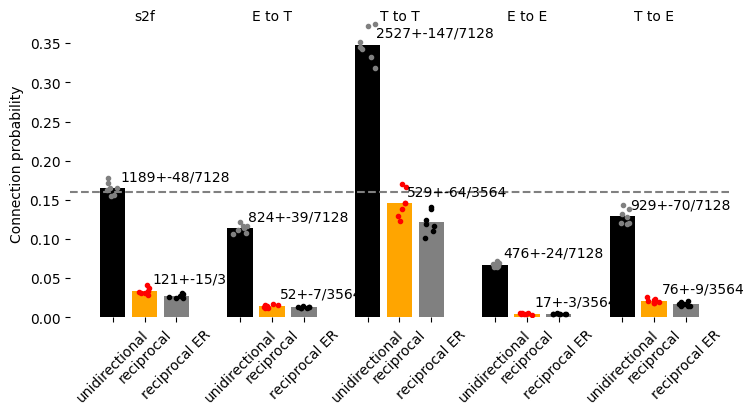

In [23]:
fig = plt.figure(figsize=(1.5 * len(df_Ps) + 1, 4))
i = 1
xticks = []; xticklbls = []; ttls = []
for k, df_P in df_Ps.items():
    ax = fig.gca()

    x = 0.5 * (numpy.random.rand(len(df_P)) - 0.5) + 0 + i
    y = df_P["connected"].sum() / df_P["sorted_pairs"].sum()
    mn = int(df_P["connected"].mean()); sd = int(df_P["connected"].std())
    ax.bar(i, y, color="black")
    ax.plot(x, df_P["connected"] / df_P["sorted_pairs"], marker='.', color="grey", ls="None")
    ax.text(i + 0.25, y + 0.01, "{0}+-{1}/{2}".format(mn, sd, count))

    x = 0.5 * (numpy.random.rand(len(df_P)) - 0.5) + 1 + i
    y = df_P["reciprocal_pairs"].sum() / df_P["pairs"].sum()
    mn = int(df_P["reciprocal_pairs"].mean()); sd = int(df_P["reciprocal_pairs"].std())
    ax.bar(i + 1, y, color="orange")
    ax.plot(x, df_P["reciprocal_pairs"] / df_P["pairs"], marker='.', color="red", ls="None")
    ax.text(i + 1.25, y + 0.01, "{0}+-{1}/{2}".format(mn, sd, count_b))

    x = 0.5 * (numpy.random.rand(len(df_P)) - 0.5) + 2 + i
    y = (df_P["connected"].sum() / df_P["sorted_pairs"].sum()) ** 2
    smpls = df_P["pairs"] * (df_P["connected"] / df_P["sorted_pairs"]) ** 2
    mn = int(smpls.mean()); sd = int(smpls.std())
    ax.bar(i + 2, y, color="grey")
    ax.plot(x, (df_P["connected"] / df_P["sorted_pairs"]) ** 2, marker='.', color="black", ls="None")
    # ax.text(2.25, y + 0.01, "{0}+-{1}/{2}".format(mn, sd, count_b))
    
    xticks.extend([i, i + 1, i + 2])
    xticklbls.extend(["unidirectional", "reciprocal", "reciprocal ER"])
    ttls.append(k)
    i = i + 4

ax.set_xticks(xticks); ax.set_xticklabels(xticklbls, rotation=45)
ax.set_frame_on(False)
ax.set_ylabel("Connection probability")
ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(), [0.16, 0.16], color="grey", ls="--")

ymx = ax.get_ylim()[1]
for _ttl, _x in zip(ttls, xticks[1::3]):
    ax.text(_x, ymx, _ttl, horizontalalignment="center", verticalalignment="top")

### Part IIa: Reciprocal connectivity at different scales

Systematic sampling at different scales

In [ ]:
szs = [40, 80, 120, 160, 200, 240, 280, 320, 360, 400]
all_counts = []
all_P = []
for sz_arg in szs:
    campaign_cfg = {
        "mv_cv": [[sz_arg**2, 0], [0, sz_arg**2]], # Describes the patch sampling spatial dimensions. 40 ** 2 will sample neuron pairs up to ~100 um.
        "patch_kwargs": {
            "slice_thickness": sz_arg * 2.5,
            "n_samples": 200, # The number of times the patch sampling procedure will be applied
            "n_patch": 12 # Up to this number of neurons will be sampled together
        }
    }

    counts, deltas, P = execute_slice_and_patch_campaign(M, campaign_cfg)
    all_counts.append(counts)
    all_P.append(P)
    
all_counts = pandas.concat(all_counts, axis=0, keys=szs, names=["scale"])
all_P = pandas.concat(all_P, axis=0, keys=szs, names=["scale"])  

In [30]:
P_uni_ttl = M.matrix.nnz / (len(M) * (len(M) - 1))
P_rec_ttl = M.to_reciprocal().matrix.nnz / (len(M) * (len(M) - 1))

In [ ]:
deltas["horizontal"] = numpy.abs(deltas["horizontal"])
deltas = deltas[numpy.any(deltas != 0, axis=1)]

hbins = numpy.arange(0, 300, 75)
hbinc = 0.5 * (hbins[:-1] + hbins[1:])
vbins = numpy.arange(-225, 300, 75)
vbinc = 0.5 * (vbins[:-1] + vbins[1:])
deltas["hbins"] = numpy.digitize(deltas["horizontal"], bins=hbins[:-1]) - 1
deltas["vbins"] = numpy.digitize(deltas["vertical"], bins=vbins[:-1]) - 1



fig = plt.figure(figsize=(3.5, 6.))
ax_c = fig.add_axes([0.1, 0.1, 0.6, 0.6])
ax_t = fig.add_axes([0.1, 0.8, 0.6, 0.15])
ax_r = fig.add_axes([0.85, 0.1, 0.15, 0.6])

tst = deltas.reset_index().groupby("hbins")["level_1"].value_counts().unstack("level_1", fill_value=0)
tst["pairs"] = tst.sum(axis=1)
ax_t.plot(hbinc[tst.index], 100 * tst["reciprocal"] / tst["pairs"], color="red")
ax_t.plot(hbinc[tst.index], 100 * (tst["reciprocal"] + tst["unidirectional"]) / tst["pairs"], color="blue")
ax_t.set_xlabel("Horizontal dist. (um)")
ax_t.set_ylabel("Connection prob. (%)")
ax_t.set_frame_on(False)

tst = deltas.reset_index().groupby("vbins")["level_1"].value_counts().unstack("level_1", fill_value=0).drop(-1)
tst["pairs"] = tst.sum(axis=1)
ax_r.plot(100 * tst["reciprocal"] / tst["pairs"], vbinc[tst.index], color="red")
ax_r.plot(100 * (tst["reciprocal"] + tst["unidirectional"]) / tst["pairs"], vbinc[tst.index], color="blue")
ax_r.set_ylabel("Vert. offset (um)")
ax_r.set_xlabel("Connection prob. (%)")
ax_r.set_frame_on(False)

tst = deltas.reset_index().groupby(["hbins", "vbins"])["level_1"].value_counts().unstack("level_1", fill_value=0)
tst["pairs"] = tst.sum(axis=1)

tstP = (tst["reciprocal"] + tst["unidirectional"]) / tst["pairs"]

ax_c.imshow(tstP.unstack("hbins").drop(-1), cmap="Blues", clim=[-0.05, 0.4],
           extent=[hbins[0], hbins[-1], vbins[-1], vbins[0]])
ax_c.set_ylim(sorted(ax_c.set_ylim()))
ax_c.set_xticks([]); ax_c.set_yticks([]); ax_c.set_frame_on(False)

for hb, hv in enumerate(hbinc):
    for vb, vv in enumerate(vbinc):
        v = tstP[(hb, vb)]
        ax_c.text(hv, vv, "{0}%".format(int(numpy.round(100 * v))),
                 verticalalignment="center", horizontalalignment="center")

#### Show that distance matters
Second panel shows that when sampling at higher distances the reciprocity increases.

Black arrow indicates where a Peng et al.-like sampling is found

In [ ]:
fig = plt.figure(figsize=(3, 2.0))
ax = fig.gca()

x = all_P.index.to_frame()["scale"].values
x_extra = x[-1] + 1.5 * numpy.mean(numpy.diff(x))
ax.bar(x, all_P['reciprocal'] / (all_P['unidirectional'] ** 2), width=35)
ax.bar(x_extra, P_rec_ttl / (P_uni_ttl ** 2), width=35, color="red")
ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(), [1, 1], color="grey", ls="--")
ax.quiver([130], [4], [0], [-2])
ticks = x[::4]
ax.set_xticks(list(ticks) + [x_extra])
ax.set_xticklabels(list(ticks) + ["total"])
ax.set_xlabel("Sampling scale (um)")
ax.set_ylabel("Reciprocal overexpression")
ax.set_frame_on(False)

#### Part IIa: Triad motifs at different scales

In [ ]:
from matplotlib import cm
fig = plt.figure(figsize=(5, 2.75))
ax = fig.add_axes([0.025, 0.025, 0.8, 0.9])

lvls = all_counts.index.levels[0]
cols = cm.copper(numpy.linspace(0, 1, len(lvls)))

for lvl, col in zip(lvls, cols):
    x = all_counts.columns + 0.4 * (numpy.random.rand(len(all_counts.columns)) - 0.5)
    ax.plot(x, all_counts.loc[lvl].mean(), color=col, ls="None", marker='o', ms=3)
    ax.plot([0, 13], [0, 0], color="grey", lw=0.5)
ax.set_frame_on(False)
ax.set_xlabel("Triad #")
ax.set_ylabel("Z-score")

ax = fig.add_axes([0.85, 0.15, 0.035, 0.6])
c = cols.reshape((-1, 1, 4))
ax.imshow(c)
ax.set_xticks([]); ax.yaxis.tick_right()
ticks = numpy.arange(0, len(lvls), 3)
ax.set_yticks(ticks)
ax.set_yticklabels(lvls.values[ticks])
ax.set_ylabel("Sampling scale(um)")